# The Efficacy of Body-Mass Index and Child Mortality Rate In Indicating the Causes of Mortality In a Country

By Cao Yueran

## Table of Contents
1. [Introduction](#intro)
2. [Methodology](#methodology)
    1. [Data Acquisition](#dataAcquisition)
        1. [Mortality Data](#mortalityDataAcq)
        2. [BMI Data](#bmiDataAcq)
        3. [CMR Data](#cmrDataAcq)
        4. [Miscellaneous](#miscellaneous)
    2. [Data Wrangling](#dataWrangling)
        1. [Mortality Data](#mortalityDataWra)
        2. [BMI Data](#bmiDataWra)
        3. [CMR Data](#cmrDataWra)
        4. [HDI Data](#hdi)
        5. [Post-Cleaning](#postcleaning)
3. [Questions](#questions)
    1. [How has the leading cause of mortality in a country changed over time?](#causeOverTime)
        1. [Result](#result1)
        2. [EDA](#eda1)
            1. [Lineplots](#lineplots1)
            2. [Animated Choropleth Maps](#aniChoro1)
            3. [Boxplots](#boxplots1)
    2. [How does the average BMI correlate with the causes of mortality at any point in time?](#bmiVsMortality)
        1. [Result](#result2)
        2. [EDA](#eda2)
    3. [How does the average Child Mortality Rate (CMR) correlate with the causes of mortality at any point in time?](#cmrVsMortality)
        1. [Result](#result3)
        2. [EDA](#eda3)
    4. [Using an index consisting of BMI and CMR, is it possible to predict the trend of some major causes of death globally?](#index)
        1. [Result](#result4)
        2. [EDA](#eda4)
4. [Testing and Verification](#testing)
5. [Conclusions and Recommendations](#conclusion)

## Introduction
<a id = 'intro'></a>

[Previous studies](https://www.who.int/data/gho/indicator-metadata-registry/imr-details/90) on years of lives lost  have shown that in general, the lives of the citizens of more developed countries are cut short due to degenerative diseases such as stroke and heart disease, while for developing countries, infectious disease still remains a leading cause of death. However, previous measurements of "development" use GDP per capita or qualitative analysis which does not take into account the inequality of a country. <b>This projects attempts to find a correlation between the causes of mortality and two indexes that are relatively resistant to inequality, BMI and CMR.</b>

Specific causes of mortality is generally a very difficult type of census data to gather, especially for less financially capable countries. These countries also tend to be the ones most in need of accurate data as to why their citizens are dying young. If BMI and CMR, two widely availabe indexes could accurately indicate a country's developmental status in regards to healthcare (as reflected in causes of mortality), then countries would be able to use them as a basis for targeted healthcare policies instead of causes of mortality.

## Methodology
<a id='methodology'/>

### Data Acquisition
<a id='dataAcquisition'/>

#### Mortality Data
<a id='mortalityDataAcq'/>

Mortality data is acquired from https://apps.who.int/healthinfo/statistics/mortality/whodpms/. The website is very difficult for a machine to navigate, so 16 .xml files were chosen and downloaded manually, each pertaining to a general cause of death. The .xml files were subsequently converted to .csv files for easy import. Each .xml contains Age-Standardized Death Rates (ASDRs) by country, by year (1979-2016).

The [WHO world standard population](https://apps.who.int/healthinfo/statistics/mortality/whodpms/definitions/pop.htm) were used to calibrate the mortality data. The ASDRs were calculated by WHO, so it is using the same formula as the one used in the BMI dataset (also by WHO). This should make the results a bit more indicative.

#### BMI Data
<a id='bmiDataAcq'/>

The [WHO BMI dataset](https://apps.who.int/gho/data/view.main.CTRY12461?lang=en) contains 25000 datapoints of the mean male, female and combined BMI of each country, per year (1975-2016). I am only interested in the combined BMI, for the ASDR are combined as well. Within each data cell, it also has the uncertainty bounds, but I will only be using the mean BMI.

#### CMR Data
<a id='cmrDataAcq'/>

The [UNICEF child mortality dataset](https://data.unicef.org/wp-content/uploads/2020/09/Infant-mortality-rate_2020.xlsx) contains 20000 datapoints of median child mortality rate by country, by year (1950-2019). It contains both sexes, male and female statistics, but once again we are only interested in both sexes.

#### Miscellaneous
<a id='miscellaneous'/>

HDI indexes to determine a country's state of development is taken from http://hdr.undp.org/sites/default/files/hdro_statistical_data_tables_1_15_d1_d5.xlsxv

### Data Wrangling
<a id='dataWrangling'/>

#### Mortality Data
<a id='mortalityDataWra'/>

The index for diseases is available locally.

In [1]:
import numpy as np, pandas as pd
import requests
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

pd.options.display.max_rows = 20
pd.options.mode.chained_assignment = None

disease_codes = pd.read_csv("disease_codes.csv", dtype={"disease": str})
disease_codes.index = np.arange(1, len(disease_codes) + 1)
disease_codes

disease                                               name
1     1001          Certain infectious and parasitic diseases
2     1026                                          Neoplasms
3     1048  Diseases of the blood and blood-forming organs...
4     1051      Endocrine, nutritional and metabolic diseases
5     1055                   Mental and behavioural disorders
6     1058                     Diseases of the nervous system
7     1062                     Diseases of the eye and adnexa
8     1063            Diseases of the ear and mastoid process
9     1064                 Diseases of the circulatory system
10    1072                 Diseases of the respiratory system
11    1078                   Diseases of the digestive system
12    1082       Diseases of the skin and subcutaneous tissue
13    1083  Diseases of the musculoskeletal system and con...
14    1084               Diseases of the genitourinary system
15    1087           Pregnancy, childbirth and the puerperium
16    1093  Congenital malformations, deformations and chr...

16 .xml files containing ASDRs will now be imported and merged into one DataFrame.

In [2]:
forConcat = []
for x in range(1, len(disease_codes) + 1):
    temp = pd.read_csv(str(x) + ".csv", header=1)
    temp.insert(1, "Cause", x)
    forConcat.append(temp)

mdf = pd.concat(forConcat, ignore_index=True)
mdf = mdf.loc[mdf.Countries != "Total reporting countries"]
mdf.rename({"Countries": "Country"}, axis=1, inplace=True)
mdf.reset_index(inplace=True, drop=True)
mdf.replace(" ", np.nan, inplace=True)
mdf

Country  Cause  2016  2015  2014  2013  2012  \
0                                Albania      1   NaN   NaN   NaN   NaN   NaN   
1                               Anguilla      1   NaN   NaN   NaN   NaN   NaN   
2                    Antigua and Barbuda      1   NaN  28.4  39.5  29.8  38.3   
3                              Argentina      1   NaN  23.9  26.0  26.3  25.6   
4                                Armenia      1   7.1   9.0   8.4   7.4   8.5   
...                                  ...    ...   ...   ...   ...   ...   ...   
2251                             Uruguay     16   NaN   5.9   5.2   6.3   6.4   
2252                          Uzbekistan     16   NaN   NaN   2.4   1.7   1.5   
2253  Venezuela (Bolivarian Republic of)     16   NaN   NaN   NaN   7.5   7.6   
2254                Virgin Islands (USA)     16   NaN   0.8   NaN   NaN   2.4   
2255                            Zimbabwe     16   NaN   NaN   NaN   NaN   NaN   

      2011  2010  2009  ...  1988  1987  1986  1985  1984  1983  1982  1981  \
0      NaN   1.2   1.1  ...   8.9  11.4   NaN   NaN   NaN   NaN   NaN   NaN   
1      NaN   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2      NaN   NaN  21.6  ...  15.8  10.2  20.6  11.7   NaN   NaN   NaN   NaN   
3     27.0  27.6  27.2  ...  25.6  26.5  24.7  23.5  25.3  25.3  23.3  27.7   
4      8.2   9.8   9.2  ...  11.7  15.2  12.8  13.7   NaN   NaN  12.6  13.6   
...    ...   ...   ...  ...   ...   ...   ...   ...   ...   ...   ...   ...   
2251   NaN   5.1   5.3  ...   8.6   9.0   8.2   8.8   9.1   9.1   8.4   8.2   
2252   1.3   1.3   1.7  ...   5.0   6.5   7.4   7.4   NaN   NaN   6.7   6.2   
2253   7.1   7.5   6.7  ...   6.9   6.4   6.4   6.0   NaN   6.8   6.7   6.3   
2254   3.5   4.1   1.1  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2255   NaN   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

      1980   1979  
0      NaN    NaN  
1      NaN    NaN  
2      NaN    NaN  
3     28.0  29.8   
4      NaN    NaN  
...    ...    ...  
2251  10.2    NaN  
2252   NaN    NaN  
2253   6.0   5.6   
2254   8.7    NaN  
2255   NaN    NaN  

[2256 rows x 40 columns]

Let us proceed to map the names of causes onto `Cause`.

In [3]:
mdf.insert(
    2, "CauseName", mdf.Cause.map(dict(zip(disease_codes.index, disease_codes.name)))
)
mdf.sort_values(by=["Country", "Cause"], inplace=True)
mdf.reset_index(inplace=True, drop=True)
mdf

Country  Cause                                          CauseName  \
0      Albania      1          Certain infectious and parasitic diseases   
1      Albania      2                                          Neoplasms   
2      Albania      3  Diseases of the blood and blood-forming organs...   
3      Albania      4      Endocrine, nutritional and metabolic diseases   
4      Albania      5                   Mental and behavioural disorders   
...        ...    ...                                                ...   
2251  Zimbabwe     12       Diseases of the skin and subcutaneous tissue   
2252  Zimbabwe     13  Diseases of the musculoskeletal system and con...   
2253  Zimbabwe     14               Diseases of the genitourinary system   
2254  Zimbabwe     15           Pregnancy, childbirth and the puerperium   
2255  Zimbabwe     16  Congenital malformations, deformations and chr...   

      2016  2015  2014  2013  2012  2011  2010  ...   1988  1987  1986  1985  \
0      NaN   NaN   NaN   NaN   NaN   NaN   1.2  ...    8.9  11.4   NaN   NaN   
1      NaN   NaN   NaN   NaN   NaN   NaN  56.4  ...  106.9  95.8   NaN   NaN   
2      NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    NaN   NaN   NaN   NaN   
3      NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    NaN   NaN   NaN   NaN   
4      NaN   NaN   NaN   NaN   NaN   NaN   1.7  ...    0.0   0.0   NaN   NaN   
...    ...   ...   ...   ...   ...   ...   ...  ...    ...   ...   ...   ...   
2251   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    NaN   NaN   NaN   NaN   
2252   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    NaN   NaN   NaN   NaN   
2253   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    NaN   NaN   NaN   NaN   
2254   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    NaN   NaN   NaN   NaN   
2255   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    NaN   NaN   NaN   NaN   

      1984  1983  1982  1981  1980  1979  
0      NaN   NaN   NaN   NaN   NaN   NaN  
1      NaN   NaN   NaN   NaN   NaN   NaN  
2      NaN   NaN   NaN   NaN   NaN   NaN  
3      NaN   NaN   NaN   NaN   NaN   NaN  
4      NaN   NaN   NaN   NaN   NaN   NaN  
...    ...   ...   ...   ...   ...   ...  
2251   NaN   NaN   NaN   NaN   NaN   NaN  
2252   NaN   NaN   NaN   NaN   NaN   NaN  
2253   NaN   NaN   NaN   NaN   NaN   NaN  
2254   NaN   NaN   NaN   NaN   NaN   NaN  
2255   NaN   NaN   NaN   NaN   NaN   NaN  

[2256 rows x 41 columns]

Let us remove the countries with no datapoints from 1979 until 2016. They are of no use to our analysis. The other missing data points would be left in for now, as it may come in handy during the plotting of a choropleth map to show which countries' infrastructure are so bad that they have no mortality data.

In [4]:
missingPerCountry = (
    mdf.groupby("Country")
    .apply(lambda x: x.notna().sum())
    .sum(axis=1)
    .sort_values(ascending=False)
)
noDataCountries = list(missingPerCountry[missingPerCountry <= 48].index)
mdf.drop(mdf[mdf.Country.isin(noDataCountries)].index, inplace=True)
mdf.reset_index(inplace=True, drop=True)
mdf

Country  Cause  \
0                  Albania      1   
1                  Albania      2   
2                  Albania      3   
3                  Albania      4   
4                  Albania      5   
...                    ...    ...   
1787  Virgin Islands (USA)     12   
1788  Virgin Islands (USA)     13   
1789  Virgin Islands (USA)     14   
1790  Virgin Islands (USA)     15   
1791  Virgin Islands (USA)     16   

                                              CauseName  2016  2015  2014  \
0             Certain infectious and parasitic diseases   NaN   NaN   NaN   
1                                             Neoplasms   NaN   NaN   NaN   
2     Diseases of the blood and blood-forming organs...   NaN   NaN   NaN   
3         Endocrine, nutritional and metabolic diseases   NaN   NaN   NaN   
4                      Mental and behavioural disorders   NaN   NaN   NaN   
...                                                 ...   ...   ...   ...   
1787       Diseases of the skin and subcutaneous tissue   NaN   1.0   NaN   
1788  Diseases of the musculoskeletal system and con...   NaN   1.6   NaN   
1789               Diseases of the genitourinary system   NaN   8.3   NaN   
1790           Pregnancy, childbirth and the puerperium   NaN   0.0   NaN   
1791  Congenital malformations, deformations and chr...   NaN   0.8   NaN   

      2013  2012  2011  2010  ...   1988  1987  1986  1985  1984  1983  1982  \
0      NaN   NaN   NaN   1.2  ...    8.9  11.4   NaN   NaN   NaN   NaN   NaN   
1      NaN   NaN   NaN  56.4  ...  106.9  95.8   NaN   NaN   NaN   NaN   NaN   
2      NaN   NaN   NaN   NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   
3      NaN   NaN   NaN   NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   
4      NaN   NaN   NaN   1.7  ...    0.0   0.0   NaN   NaN   NaN   NaN   NaN   
...    ...   ...   ...   ...  ...    ...   ...   ...   ...   ...   ...   ...   
1787   NaN   0.6   1.8   4.1  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1788   NaN   4.3   2.4   2.9  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1789   NaN   7.7   7.1  13.8  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1790   NaN   0.0   0.0   0.0  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1791   NaN   2.4   3.5   4.1  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   

      1981  1980  1979  
0      NaN   NaN   NaN  
1      NaN   NaN   NaN  
2      NaN   NaN   NaN  
3      NaN   NaN   NaN  
4      NaN   NaN   NaN  
...    ...   ...   ...  
1787   NaN   3.0   NaN  
1788   NaN   3.2   NaN  
1789   NaN  13.9   NaN  
1790   NaN  14.7   NaN  
1791   NaN   8.7   NaN  

[1792 rows x 41 columns]

Reverse the year numbers for easier graph plotting.

In [5]:
mdf = mdf[
    ["Country", "Cause", "CauseName"] + list(mdf.columns[:2:-1])
]  # I don't get why this is [:0:-1] instead of [1::-1] but ok.
mdf

Country  Cause  \
0                  Albania      1   
1                  Albania      2   
2                  Albania      3   
3                  Albania      4   
4                  Albania      5   
...                    ...    ...   
1787  Virgin Islands (USA)     12   
1788  Virgin Islands (USA)     13   
1789  Virgin Islands (USA)     14   
1790  Virgin Islands (USA)     15   
1791  Virgin Islands (USA)     16   

                                              CauseName 1979  1980  1981  \
0             Certain infectious and parasitic diseases  NaN   NaN   NaN   
1                                             Neoplasms  NaN   NaN   NaN   
2     Diseases of the blood and blood-forming organs...  NaN   NaN   NaN   
3         Endocrine, nutritional and metabolic diseases  NaN   NaN   NaN   
4                      Mental and behavioural disorders  NaN   NaN   NaN   
...                                                 ...  ...   ...   ...   
1787       Diseases of the skin and subcutaneous tissue  NaN   3.0   NaN   
1788  Diseases of the musculoskeletal system and con...  NaN   3.2   NaN   
1789               Diseases of the genitourinary system  NaN  13.9   NaN   
1790           Pregnancy, childbirth and the puerperium  NaN  14.7   NaN   
1791  Congenital malformations, deformations and chr...  NaN   8.7   NaN   

      1982  1983  1984  1985  ...  2007  2008  2009  2010  2011  2012  2013  \
0      NaN   NaN   NaN   NaN  ...   2.0   2.0   1.1   1.2   NaN   NaN   NaN   
1      NaN   NaN   NaN   NaN  ...  74.2  80.5  74.7  56.4   NaN   NaN   NaN   
2      NaN   NaN   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
3      NaN   NaN   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
4      NaN   NaN   NaN   NaN  ...   1.8   1.6   1.5   1.7   NaN   NaN   NaN   
...    ...   ...   ...   ...  ...   ...   ...   ...   ...   ...   ...   ...   
1787   NaN   NaN   NaN   NaN  ...   2.5   1.4   0.7   4.1   1.8   0.6   NaN   
1788   NaN   NaN   NaN   NaN  ...   3.6   3.0   1.7   2.9   2.4   4.3   NaN   
1789   NaN   NaN   NaN   NaN  ...   8.6   6.8   7.5  13.8   7.1   7.7   NaN   
1790   NaN   NaN   NaN   NaN  ...   0.0   0.0   0.0   0.0   0.0   0.0   NaN   
1791   NaN   NaN   NaN   NaN  ...   7.1   4.0   1.1   4.1   3.5   2.4   NaN   

      2014  2015  2016  
0      NaN   NaN   NaN  
1      NaN   NaN   NaN  
2      NaN   NaN   NaN  
3      NaN   NaN   NaN  
4      NaN   NaN   NaN  
...    ...   ...   ...  
1787   NaN   1.0   NaN  
1788   NaN   1.6   NaN  
1789   NaN   8.3   NaN  
1790   NaN   0.0   NaN  
1791   NaN   0.8   NaN  

[1792 rows x 41 columns]

Let us assign ISO codes for each country and remove the locations that are not countries. We will also remove the rows with not a single data point. I chose to use `get` instead of `search_fuzzy` because the latter is way too slow.

I will also map the codes back onto the name to remove any inconsistencies as pycountry is not a 1-to-1 mapping.

In [6]:
import pycountry


def get_country_code(name):
    try:
        return pycountry.countries.lookup(name).alpha_3
    except:
        return None


def get_country_name(code):
    try:
        return pycountry.countries.get(alpha_3=code).name
    except:
        return None


mdf.insert(0, "CountryCode", mdf.Country.apply(get_country_code))
mdf2 = mdf.copy()

mdf.drop(mdf[mdf.CountryCode.isna()].index, inplace=True)
mdf.dropna(thresh=5, inplace=True)
mdf.reset_index(inplace=True, drop=True)
mdf[mdf.CountryCode == "MDK"]

Empty DataFrame
Columns: [CountryCode, Country, Cause, CauseName, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
Index: []

[0 rows x 42 columns]

We have to check that the countries left out are actually not countries, not just incorrectly named. If they are actually countries, then we should rename them and concatenate them back into `mdf`.

In [7]:
leftOut = mdf2[mdf2.CountryCode.isna()]
display(leftOut.Country.value_counts())
countryMapping = {
    "Hong Kong SAR": "Hong Kong",
    "Macau": "Macao",
    "Reunion": "Réunion",
    "Saint Vincent and Grenadines": "Saint Vincent and the Grenadines",
    "Virgin Islands (USA)": "Virgin Islands, U.S.",
    "TFYR Macedonia": "North Macedonia",
    "Iran (Islamic Rep of)": "Iran, Islamic Republic of",
    "Republic of Korea": "Korea, Republic of",
    "Venezuela (Bolivarian Republic of)": "Venezuela, Bolivarian Republic of",
}
leftOut.replace(countryMapping, inplace=True)
leftOut.drop("CountryCode", inplace=True, axis=1)
leftOut.insert(0, "CountryCode", leftOut.Country.apply(get_country_code))
print("number of nan: " + str(leftOut.CountryCode.isna().sum()))

mdf = pd.concat([mdf, leftOut], ignore_index=True)
mdf

Iran (Islamic Rep of)                 16
Venezuela (Bolivarian Republic of)    16
Virgin Islands (USA)                  16
Reunion                               16
Republic of Korea                     16
Macau                                 16
Saint Vincent and Grenadines          16
Hong Kong SAR                         16
TFYR Macedonia                        16
Name: Country, dtype: int64

number of nan: 0


CountryCode               Country  Cause  \
0            ALB               Albania      1   
1            ALB               Albania      2   
2            ALB               Albania      5   
3            ALB               Albania      6   
4            ALB               Albania      7   
...          ...                   ...    ...   
1776         VIR  Virgin Islands, U.S.     12   
1777         VIR  Virgin Islands, U.S.     13   
1778         VIR  Virgin Islands, U.S.     14   
1779         VIR  Virgin Islands, U.S.     15   
1780         VIR  Virgin Islands, U.S.     16   

                                              CauseName 1979  1980  1981  \
0             Certain infectious and parasitic diseases  NaN   NaN   NaN   
1                                             Neoplasms  NaN   NaN   NaN   
2                      Mental and behavioural disorders  NaN   NaN   NaN   
3                        Diseases of the nervous system  NaN   NaN   NaN   
4                        Diseases of the eye and adnexa  NaN   NaN   NaN   
...                                                 ...  ...   ...   ...   
1776       Diseases of the skin and subcutaneous tissue  NaN   3.0   NaN   
1777  Diseases of the musculoskeletal system and con...  NaN   3.2   NaN   
1778               Diseases of the genitourinary system  NaN  13.9   NaN   
1779           Pregnancy, childbirth and the puerperium  NaN  14.7   NaN   
1780  Congenital malformations, deformations and chr...  NaN   8.7   NaN   

      1982  1983  1984  ...  2007  2008  2009  2010  2011  2012  2013  2014  \
0      NaN   NaN   NaN  ...   2.0   2.0   1.1   1.2   NaN   NaN   NaN   NaN   
1      NaN   NaN   NaN  ...  74.2  80.5  74.7  56.4   NaN   NaN   NaN   NaN   
2      NaN   NaN   NaN  ...   1.8   1.6   1.5   1.7   NaN   NaN   NaN   NaN   
3      NaN   NaN   NaN  ...  12.7   4.8   4.8   7.3   NaN   NaN   NaN   NaN   
4      NaN   NaN   NaN  ...   0.1   0.1   0.1   0.1   NaN   NaN   NaN   NaN   
...    ...   ...   ...  ...   ...   ...   ...   ...   ...   ...   ...   ...   
1776   NaN   NaN   NaN  ...   2.5   1.4   0.7   4.1   1.8   0.6   NaN   NaN   
1777   NaN   NaN   NaN  ...   3.6   3.0   1.7   2.9   2.4   4.3   NaN   NaN   
1778   NaN   NaN   NaN  ...   8.6   6.8   7.5  13.8   7.1   7.7   NaN   NaN   
1779   NaN   NaN   NaN  ...   0.0   0.0   0.0   0.0   0.0   0.0   NaN   NaN   
1780   NaN   NaN   NaN  ...   7.1   4.0   1.1   4.1   3.5   2.4   NaN   NaN   

      2015  2016  
0      NaN   NaN  
1      NaN   NaN  
2      NaN   NaN  
3      NaN   NaN  
4      NaN   NaN  
...    ...   ...  
1776   1.0   NaN  
1777   1.6   NaN  
1778   8.3   NaN  
1779   0.0   NaN  
1780   0.8   NaN  

[1781 rows x 42 columns]

In [8]:
mdf.Country = mdf.CountryCode.apply(get_country_name)
mdf.CountryCode.isna().sum()

0

#### BMI Data
<a id='bmiDataWra'/>

In [9]:
bmidf = pd.read_csv("bmi.csv")
bmidf.drop([0, 1], inplace=True)
bmidf.rename({"Unnamed: 0": "Country"}, axis=1, inplace=True)
bmidf.reset_index(inplace=True, drop=True)
criteria = (bmidf.loc[0] == " Both sexes") | (bmidf.loc[0] == "Country")
bmidf = bmidf[
    criteria.index[criteria]
]  # This is a really good way to boolean index columns
bmidf

Country              2016              2015  \
0                               Country        Both sexes        Both sexes   
1                           Afghanistan  23.4 [22.0-24.8]  23.3 [21.9-24.6]   
2                               Albania  26.7 [25.8-27.5]  26.6 [25.8-27.4]   
3                               Algeria  25.5 [24.5-26.5]  25.5 [24.5-26.4]   
4                               Andorra  26.7 [24.6-28.7]  26.7 [24.7-28.7]   
..                                  ...               ...               ...   
191  Venezuela (Bolivarian Republic of)  26.7 [26.2-27.2]  26.7 [26.2-27.2]   
192                            Viet Nam  21.9 [21.5-22.3]  21.7 [21.4-22.1]   
193                               Yemen  23.8 [23.1-24.5]  23.7 [23.1-24.3]   
194                              Zambia  22.6 [21.7-23.4]  22.5 [21.6-23.3]   
195                            Zimbabwe  23.8 [23.3-24.3]  23.8 [23.4-24.2]   

                 2014              2013              2012              2011  \
0          Both sexes        Both sexes        Both sexes        Both sexes   
1    23.2 [21.8-24.5]  23.0 [21.7-24.4]  22.9 [21.6-24.3]  22.8 [21.6-24.1]   
2    26.5 [25.8-27.2]  26.4 [25.7-27.1]  26.3 [25.6-26.9]  26.2 [25.6-26.8]   
3    25.4 [24.5-26.2]  25.3 [24.5-26.1]  25.2 [24.5-26.0]  25.1 [24.4-25.8]   
4    26.7 [24.7-28.7]  26.8 [24.8-28.7]  26.8 [24.8-28.7]  26.8 [24.9-28.7]   
..                ...               ...               ...               ...   
191  26.6 [26.2-27.1]  26.6 [26.2-27.1]  26.6 [26.2-27.1]  26.6 [26.1-27.0]   
192  21.6 [21.3-21.9]  21.5 [21.2-21.7]  21.3 [21.1-21.6]  21.2 [20.9-21.4]   
193  23.6 [23.1-24.2]  23.5 [23.1-24.0]  23.4 [23.0-23.9]  23.4 [23.0-23.8]   
194  22.4 [21.6-23.2]  22.4 [21.6-23.1]  22.3 [21.6-23.0]  22.2 [21.6-22.9]   
195  23.8 [23.4-24.2]  23.7 [23.4-24.1]  23.7 [23.4-24.0]  23.7 [23.3-24.0]   

                 2010              2009              2008  ...  \
0          Both sexes        Both sexes        Both sexes  ...   
1    22.7 [21.5-24.0]  22.6 [21.4-23.9]  22.5 [21.3-23.8]  ...   
2    26.1 [25.5-26.7]  26.0 [25.5-26.5]  25.9 [25.4-26.4]  ...   
3    25.1 [24.4-25.7]  25.0 [24.4-25.6]  24.9 [24.3-25.5]  ...   
4    26.8 [24.9-28.7]  26.8 [25.0-28.7]  26.8 [25.0-28.7]  ...   
..                ...               ...               ...  ...   
191  26.6 [26.1-27.0]  26.6 [26.1-27.0]  26.5 [26.1-27.0]  ...   
192  21.0 [20.8-21.3]  20.9 [20.7-21.1]  20.8 [20.6-21.0]  ...   
193  23.3 [22.9-23.6]  23.2 [22.8-23.5]  23.1 [22.8-23.4]  ...   
194  22.2 [21.5-22.8]  22.1 [21.5-22.7]  22.0 [21.4-22.6]  ...   
195  23.6 [23.3-24.0]  23.6 [23.3-23.9]  23.6 [23.3-23.9]  ...   

                 1984              1983              1982              1981  \
0          Both sexes        Both sexes        Both sexes        Both sexes   
1    20.0 [18.3-21.6]  19.9 [18.2-21.6]  19.8 [18.1-21.5]  19.6 [17.9-21.4]   
2    24.3 [23.1-25.5]  24.2 [23.0-25.5]  24.2 [22.9-25.5]  24.1 [22.8-25.5]   
3    22.7 [21.5-23.9]  22.6 [21.4-23.9]  22.5 [21.2-23.8]  22.4 [21.1-23.8]   
4    26.0 [24.1-28.0]  26.0 [24.0-27.9]  25.9 [23.9-27.9]  25.9 [23.8-27.9]   
..                ...               ...               ...               ...   
191  24.9 [23.7-26.1]  24.8 [23.6-26.0]  24.7 [23.4-26.0]  24.6 [23.3-26.0]   
192  18.8 [18.3-19.3]  18.7 [18.2-19.2]  18.6 [18.0-19.2]  18.6 [17.9-19.2]   
193  20.6 [19.6-21.7]  20.5 [19.4-21.7]  20.4 [19.2-21.6]  20.3 [19.1-21.6]   
194  20.5 [19.6-21.5]  20.5 [19.5-21.5]  20.4 [19.3-21.5]  20.2 [19.1-21.4]   
195  22.6 [21.8-23.4]  22.5 [21.6-23.4]  22.4 [21.5-23.4]  22.4 [21.4-23.4]   

                 1980              1979              1978              1977  \
0          Both sexes        Both sexes        Both sexes        Both sexes   
1    19.5 [17.7-21.3]  19.4 [17.6-21.3]  19.3 [17.4-21.2]  19.2 [17.2-21.1]   
2    24.1 [22.6-25.5]  24.0 [22.5-25.5]  23.9 [22.4-25.5]  23.9 [22.3-25.5]   
3    22.3 [20.9-23.8]  22.2 [20.8-23.7]  22.1 [20.6-23.7]  22.0 [20.4-23.7] 

As one can see, `bmidf` only contains the BMI values for both sexes, so we can remove that row. We can also remove the uncertainty bounds, keeping only the first number which indicates the mean BMI.

In [10]:
bmidf.drop(0, inplace=True)
bmidf.reset_index(inplace=True, drop=True)
bmidf

Country              2016              2015  \
0                           Afghanistan  23.4 [22.0-24.8]  23.3 [21.9-24.6]   
1                               Albania  26.7 [25.8-27.5]  26.6 [25.8-27.4]   
2                               Algeria  25.5 [24.5-26.5]  25.5 [24.5-26.4]   
3                               Andorra  26.7 [24.6-28.7]  26.7 [24.7-28.7]   
4                                Angola  23.3 [21.2-25.6]  23.2 [21.1-25.4]   
..                                  ...               ...               ...   
190  Venezuela (Bolivarian Republic of)  26.7 [26.2-27.2]  26.7 [26.2-27.2]   
191                            Viet Nam  21.9 [21.5-22.3]  21.7 [21.4-22.1]   
192                               Yemen  23.8 [23.1-24.5]  23.7 [23.1-24.3]   
193                              Zambia  22.6 [21.7-23.4]  22.5 [21.6-23.3]   
194                            Zimbabwe  23.8 [23.3-24.3]  23.8 [23.4-24.2]   

                 2014              2013              2012              2011  \
0    23.2 [21.8-24.5]  23.0 [21.7-24.4]  22.9 [21.6-24.3]  22.8 [21.6-24.1]   
1    26.5 [25.8-27.2]  26.4 [25.7-27.1]  26.3 [25.6-26.9]  26.2 [25.6-26.8]   
2    25.4 [24.5-26.2]  25.3 [24.5-26.1]  25.2 [24.5-26.0]  25.1 [24.4-25.8]   
3    26.7 [24.7-28.7]  26.8 [24.8-28.7]  26.8 [24.8-28.7]  26.8 [24.9-28.7]   
4    23.2 [21.1-25.3]  23.1 [21.0-25.2]  23.0 [21.0-25.0]  22.9 [20.9-24.9]   
..                ...               ...               ...               ...   
190  26.6 [26.2-27.1]  26.6 [26.2-27.1]  26.6 [26.2-27.1]  26.6 [26.1-27.0]   
191  21.6 [21.3-21.9]  21.5 [21.2-21.7]  21.3 [21.1-21.6]  21.2 [20.9-21.4]   
192  23.6 [23.1-24.2]  23.5 [23.1-24.0]  23.4 [23.0-23.9]  23.4 [23.0-23.8]   
193  22.4 [21.6-23.2]  22.4 [21.6-23.1]  22.3 [21.6-23.0]  22.2 [21.6-22.9]   
194  23.8 [23.4-24.2]  23.7 [23.4-24.1]  23.7 [23.4-24.0]  23.7 [23.3-24.0]   

                 2010              2009              2008  ...  \
0    22.7 [21.5-24.0]  22.6 [21.4-23.9]  22.5 [21.3-23.8]  ...   
1    26.1 [25.5-26.7]  26.0 [25.5-26.5]  25.9 [25.4-26.4]  ...   
2    25.1 [24.4-25.7]  25.0 [24.4-25.6]  24.9 [24.3-25.5]  ...   
3    26.8 [24.9-28.7]  26.8 [25.0-28.7]  26.8 [25.0-28.7]  ...   
4    22.8 [20.8-24.8]  22.7 [20.7-24.7]  22.6 [20.6-24.5]  ...   
..                ...               ...               ...  ...   
190  26.6 [26.1-27.0]  26.6 [26.1-27.0]  26.5 [26.1-27.0]  ...   
191  21.0 [20.8-21.3]  20.9 [20.7-21.1]  20.8 [20.6-21.0]  ...   
192  23.3 [22.9-23.6]  23.2 [22.8-23.5]  23.1 [22.8-23.4]  ...   
193  22.2 [21.5-22.8]  22.1 [21.5-22.7]  22.0 [21.4-22.6]  ...   
194  23.6 [23.3-24.0]  23.6 [23.3-23.9]  23.6 [23.3-23.9]  ...   

                 1984              1983              1982              1981  \
0    20.0 [18.3-21.6]  19.9 [18.2-21.6]  19.8 [18.1-21.5]  19.6 [17.9-21.4]   
1    24.3 [23.1-25.5]  24.2 [23.0-25.5]  24.2 [22.9-25.5]  24.1 [22.8-25.5]   
2    22.7 [21.5-23.9]  22.6 [21.4-23.9]  22.5 [21.2-23.8]  22.4 [21.1-23.8]   
3    26.0 [24.1-28.0]  26.0 [24.0-27.9]  25.9 [23.9-27.9]  25.9 [23.8-27.9]   
4    19.9 [17.8-21.9]  19.8 [17.6-21.8]  19.6 [17.5-21.7]  19.5 [17.3-21.7]   
..                ...               ...               ...               ...   
190  24.9 [23.7-26.1]  24.8 [23.6-26.0]  24.7 [23.4-26.0]  24.6 [23.3-26.0]   
191  18.8 [18.3-19.3]  18.7 [18.2-19.2]  18.6 [18.0-19.2]  18.6 [17.9-19.2]   
192  20.6 [19.6-21.7]  20.5 [19.4-21.7]  20.4 [19.2-21.6]  20.3 [19.1-21.6]   
193  20.5 [19.6-21.5]  20.5 [19.5-21.5]  20.4 [19.3-21.5]  20.2 [19.1-21.4]   
194  22.6 [21.8-23.4]  22.5 [21.6-23.4]  22.4 [21.5-23.4]  22.4 [21.4-23.4]   

                 1980              1979              1978              1977  \
0    19.5 [17.7-21.3]  19.4 [17.6-21.3]  19.3 [17.4-21.2]  19.2 [17.2-21.1]   
1    24.1 [22.6-25.5]  24.0 [22.5-25.5]  23.9 [22.4-25.5]  23.9 [22.3-25.5]   
2    22.3 [20.9-23.8]  22.2 [20.8-23.7]  22.1 [20.6-23.7]  22.0 [20.4-23.7]   
3    25.8 [23.7-27.8]  25.7 [23.6-27.8]  25.6 [23.5-27.7]  25.6 [23.4-27.7] 

In [11]:
bmicountries = bmidf.loc[:, "Country"]


def check_float(f):
    try:
        float(f)
        return True
    except ValueError:
        return False


bmidf = bmidf.loc[:, "2016":].applymap(
    lambda x: float(x.split(" ")[0]) if check_float(x.split(" ")[0]) else None
)

bmidf.insert(0, "Country", bmicountries)
bmidf

Country  2016  2015  2014  2013  2012  2011  \
0                           Afghanistan  23.4  23.3  23.2  23.0  22.9  22.8   
1                               Albania  26.7  26.6  26.5  26.4  26.3  26.2   
2                               Algeria  25.5  25.5  25.4  25.3  25.2  25.1   
3                               Andorra  26.7  26.7  26.7  26.8  26.8  26.8   
4                                Angola  23.3  23.2  23.2  23.1  23.0  22.9   
..                                  ...   ...   ...   ...   ...   ...   ...   
190  Venezuela (Bolivarian Republic of)  26.7  26.7  26.6  26.6  26.6  26.6   
191                            Viet Nam  21.9  21.7  21.6  21.5  21.3  21.2   
192                               Yemen  23.8  23.7  23.6  23.5  23.4  23.4   
193                              Zambia  22.6  22.5  22.4  22.4  22.3  22.2   
194                            Zimbabwe  23.8  23.8  23.8  23.7  23.7  23.7   

     2010  2009  2008  ...  1984  1983  1982  1981  1980  1979  1978  1977  \
0    22.7  22.6  22.5  ...  20.0  19.9  19.8  19.6  19.5  19.4  19.3  19.2   
1    26.1  26.0  25.9  ...  24.3  24.2  24.2  24.1  24.1  24.0  23.9  23.9   
2    25.1  25.0  24.9  ...  22.7  22.6  22.5  22.4  22.3  22.2  22.1  22.0   
3    26.8  26.8  26.8  ...  26.0  26.0  25.9  25.9  25.8  25.7  25.6  25.6   
4    22.8  22.7  22.6  ...  19.9  19.8  19.6  19.5  19.4  19.3  19.2  19.0   
..    ...   ...   ...  ...   ...   ...   ...   ...   ...   ...   ...   ...   
190  26.6  26.6  26.5  ...  24.9  24.8  24.7  24.6  24.5  24.4  24.3  24.2   
191  21.0  20.9  20.8  ...  18.8  18.7  18.6  18.6  18.5  18.4  18.4  18.3   
192  23.3  23.2  23.1  ...  20.6  20.5  20.4  20.3  20.2  20.1  20.0  19.9   
193  22.2  22.1  22.0  ...  20.5  20.5  20.4  20.2  20.1  20.0  19.9  19.8   
194  23.6  23.6  23.6  ...  22.6  22.5  22.4  22.4  22.3  22.3  22.2  22.1   

     1976  1975  
0    19.0  18.9  
1    23.8  23.8  
2    22.0  21.9  
3    25.5  25.4  
4    18.9  18.8  
..    ...   ...  
190  24.0  23.9  
191  18.2  18.2  
192  19.8  19.7  
193  19.6  19.5  
194  22.1  22.0  

[195 rows x 43 columns]

Similar to mortality data, BMI data also has some country names inconsistent with the ISO standard. We should be able to fix it using the same map as the one before.

In [12]:
bmidf.replace(countryMapping, inplace=True)
bmidf.insert(0, "CountryCode", bmidf.Country.apply(get_country_code))
bmidf.dropna(inplace=True)
bmidf.Country = bmidf.CountryCode.apply(get_country_name)
display(bmidf.CountryCode.isna().sum())
display(bmidf)

0

CountryCode                            Country  2016  2015  2014  2013  \
0           AFG                        Afghanistan  23.4  23.3  23.2  23.0   
1           ALB                            Albania  26.7  26.6  26.5  26.4   
2           DZA                            Algeria  25.5  25.5  25.4  25.3   
3           AND                            Andorra  26.7  26.7  26.7  26.8   
4           AGO                             Angola  23.3  23.2  23.2  23.1   
..          ...                                ...   ...   ...   ...   ...   
190         VEN  Venezuela, Bolivarian Republic of  26.7  26.7  26.6  26.6   
191         VNM                           Viet Nam  21.9  21.7  21.6  21.5   
192         YEM                              Yemen  23.8  23.7  23.6  23.5   
193         ZMB                             Zambia  22.6  22.5  22.4  22.4   
194         ZWE                           Zimbabwe  23.8  23.8  23.8  23.7   

     2012  2011  2010  2009  ...  1984  1983  1982  1981  1980  1979  1978  \
0    22.9  22.8  22.7  22.6  ...  20.0  19.9  19.8  19.6  19.5  19.4  19.3   
1    26.3  26.2  26.1  26.0  ...  24.3  24.2  24.2  24.1  24.1  24.0  23.9   
2    25.2  25.1  25.1  25.0  ...  22.7  22.6  22.5  22.4  22.3  22.2  22.1   
3    26.8  26.8  26.8  26.8  ...  26.0  26.0  25.9  25.9  25.8  25.7  25.6   
4    23.0  22.9  22.8  22.7  ...  19.9  19.8  19.6  19.5  19.4  19.3  19.2   
..    ...   ...   ...   ...  ...   ...   ...   ...   ...   ...   ...   ...   
190  26.6  26.6  26.6  26.6  ...  24.9  24.8  24.7  24.6  24.5  24.4  24.3   
191  21.3  21.2  21.0  20.9  ...  18.8  18.7  18.6  18.6  18.5  18.4  18.4   
192  23.4  23.4  23.3  23.2  ...  20.6  20.5  20.4  20.3  20.2  20.1  20.0   
193  22.3  22.2  22.2  22.1  ...  20.5  20.5  20.4  20.2  20.1  20.0  19.9   
194  23.7  23.7  23.6  23.6  ...  22.6  22.5  22.4  22.4  22.3  22.3  22.2   

     1977  1976  1975  
0    19.2  19.0  18.9  
1    23.9  23.8  23.8  
2    22.0  22.0  21.9  
3    25.6  25.5  25.4  
4    19.0  18.9  18.8  
..    ...   ...   ...  
190  24.2  24.0  23.9  
191  18.3  18.2  18.2  
192  19.9  19.8  19.7  
193  19.8  19.6  19.5  
194  22.1  22.1  22.0  

[186 rows x 44 columns]

Also reverse the year numbers to make plotting graphs easier.

In [13]:
bmidf = bmidf[["CountryCode", "Country"] + list(bmidf.columns[:1:-1])]
bmidf

CountryCode                            Country  1975  1976  1977  1978  \
0           AFG                        Afghanistan  18.9  19.0  19.2  19.3   
1           ALB                            Albania  23.8  23.8  23.9  23.9   
2           DZA                            Algeria  21.9  22.0  22.0  22.1   
3           AND                            Andorra  25.4  25.5  25.6  25.6   
4           AGO                             Angola  18.8  18.9  19.0  19.2   
..          ...                                ...   ...   ...   ...   ...   
190         VEN  Venezuela, Bolivarian Republic of  23.9  24.0  24.2  24.3   
191         VNM                           Viet Nam  18.2  18.2  18.3  18.4   
192         YEM                              Yemen  19.7  19.8  19.9  20.0   
193         ZMB                             Zambia  19.5  19.6  19.8  19.9   
194         ZWE                           Zimbabwe  22.0  22.1  22.1  22.2   

     1979  1980  1981  1982  ...  2007  2008  2009  2010  2011  2012  2013  \
0    19.4  19.5  19.6  19.8  ...  22.4  22.5  22.6  22.7  22.8  22.9  23.0   
1    24.0  24.1  24.1  24.2  ...  25.8  25.9  26.0  26.1  26.2  26.3  26.4   
2    22.2  22.3  22.4  22.5  ...  24.8  24.9  25.0  25.1  25.1  25.2  25.3   
3    25.7  25.8  25.9  25.9  ...  26.8  26.8  26.8  26.8  26.8  26.8  26.8   
4    19.3  19.4  19.5  19.6  ...  22.5  22.6  22.7  22.8  22.9  23.0  23.1   
..    ...   ...   ...   ...  ...   ...   ...   ...   ...   ...   ...   ...   
190  24.4  24.5  24.6  24.7  ...  26.5  26.5  26.6  26.6  26.6  26.6  26.6   
191  18.4  18.5  18.6  18.6  ...  20.7  20.8  20.9  21.0  21.2  21.3  21.5   
192  20.1  20.2  20.3  20.4  ...  23.0  23.1  23.2  23.3  23.4  23.4  23.5   
193  20.0  20.1  20.2  20.4  ...  22.0  22.0  22.1  22.2  22.2  22.3  22.4   
194  22.3  22.3  22.4  22.4  ...  23.5  23.6  23.6  23.6  23.7  23.7  23.7   

     2014  2015  2016  
0    23.2  23.3  23.4  
1    26.5  26.6  26.7  
2    25.4  25.5  25.5  
3    26.7  26.7  26.7  
4    23.2  23.2  23.3  
..    ...   ...   ...  
190  26.6  26.7  26.7  
191  21.6  21.7  21.9  
192  23.6  23.7  23.8  
193  22.4  22.5  22.6  
194  23.8  23.8  23.8  

[186 rows x 44 columns]

Remove data prior to 1979:

In [14]:
bmidf.drop([str(x) for x in range(1975, 1979)], axis=1, inplace=True)
bmidf.reset_index(inplace=True, drop=True)
bmidf

CountryCode                            Country  1979  1980  1981  1982  \
0           AFG                        Afghanistan  19.4  19.5  19.6  19.8   
1           ALB                            Albania  24.0  24.1  24.1  24.2   
2           DZA                            Algeria  22.2  22.3  22.4  22.5   
3           AND                            Andorra  25.7  25.8  25.9  25.9   
4           AGO                             Angola  19.3  19.4  19.5  19.6   
..          ...                                ...   ...   ...   ...   ...   
181         VEN  Venezuela, Bolivarian Republic of  24.4  24.5  24.6  24.7   
182         VNM                           Viet Nam  18.4  18.5  18.6  18.6   
183         YEM                              Yemen  20.1  20.2  20.3  20.4   
184         ZMB                             Zambia  20.0  20.1  20.2  20.4   
185         ZWE                           Zimbabwe  22.3  22.3  22.4  22.4   

     1983  1984  1985  1986  ...  2007  2008  2009  2010  2011  2012  2013  \
0    19.9  20.0  20.1  20.2  ...  22.4  22.5  22.6  22.7  22.8  22.9  23.0   
1    24.2  24.3  24.3  24.4  ...  25.8  25.9  26.0  26.1  26.2  26.3  26.4   
2    22.6  22.7  22.8  22.9  ...  24.8  24.9  25.0  25.1  25.1  25.2  25.3   
3    26.0  26.0  26.1  26.2  ...  26.8  26.8  26.8  26.8  26.8  26.8  26.8   
4    19.8  19.9  20.0  20.1  ...  22.5  22.6  22.7  22.8  22.9  23.0  23.1   
..    ...   ...   ...   ...  ...   ...   ...   ...   ...   ...   ...   ...   
181  24.8  24.9  25.0  25.1  ...  26.5  26.5  26.6  26.6  26.6  26.6  26.6   
182  18.7  18.8  18.8  18.9  ...  20.7  20.8  20.9  21.0  21.2  21.3  21.5   
183  20.5  20.6  20.7  20.8  ...  23.0  23.1  23.2  23.3  23.4  23.4  23.5   
184  20.5  20.5  20.6  20.7  ...  22.0  22.0  22.1  22.2  22.2  22.3  22.4   
185  22.5  22.6  22.6  22.7  ...  23.5  23.6  23.6  23.6  23.7  23.7  23.7   

     2014  2015  2016  
0    23.2  23.3  23.4  
1    26.5  26.6  26.7  
2    25.4  25.5  25.5  
3    26.7  26.7  26.7  
4    23.2  23.2  23.3  
..    ...   ...   ...  
181  26.6  26.7  26.7  
182  21.6  21.7  21.9  
183  23.6  23.7  23.8  
184  22.4  22.5  22.6  
185  23.8  23.8  23.8  

[186 rows x 40 columns]

Check for missing data:

In [15]:
display(bmidf.dtypes.value_counts())
display(bmidf.isna().sum().sum())

float64    38
object      2
dtype: int64

0

#### CMR Data
<a id='cmrDataWra'/>

In [16]:
cmrdf = pd.read_excel("cmr.xlsx", sheet_name=0, header=14)
cmrdf = cmrdf.loc[:584]
cmrdf

ISO.Code Country.Name Uncertainty.Bounds*  1950.5  1951.5  1952.5  \
0        AFG  Afghanistan               Lower     NaN     NaN     NaN   
1        AFG  Afghanistan              Median     NaN     NaN     NaN   
2        AFG  Afghanistan               Upper     NaN     NaN     NaN   
3        ALB      Albania               Lower     NaN     NaN     NaN   
4        ALB      Albania              Median     NaN     NaN     NaN   
..       ...          ...                 ...     ...     ...     ...   
580      ZMB       Zambia              Median     NaN     NaN     NaN   
581      ZMB       Zambia               Upper     NaN     NaN     NaN   
582      ZWE     Zimbabwe               Lower     NaN     NaN     NaN   
583      ZWE     Zimbabwe              Median     NaN     NaN     NaN   
584      ZWE     Zimbabwe               Upper     NaN     NaN     NaN   

         1953.5      1954.5      1955.5      1956.5  ...     2010.5  \
0           NaN         NaN         NaN         NaN  ...  59.418411   
1           NaN         NaN         NaN         NaN  ...  64.100567   
2           NaN         NaN         NaN         NaN  ...  69.265736   
3           NaN         NaN         NaN         NaN  ...  11.453889   
4           NaN         NaN         NaN         NaN  ...  11.828097   
..          ...         ...         ...         ...  ...        ...   
580  138.522662  135.831489  133.228545  130.723865  ...  52.323193   
581  183.501394  171.798482  162.555913  154.748751  ...  56.131591   
582         NaN   79.678893   82.530744   84.233003  ...  50.099059   
583         NaN  104.305814  102.558033  100.831113  ...  53.776518   
584         NaN  139.889589  129.061901  121.647595  ...  57.893104   

        2011.5     2012.5     2013.5     2014.5     2015.5     2016.5  \
0    56.920935  54.351492  51.909067  49.342518  46.814268  44.356079   
1    61.726441  59.454642  57.225151  55.160932  53.169807  51.319141   
2    67.089883  65.032220  63.113255  61.386848  59.787768  58.378906   
3    10.469362   9.625089   8.963378   8.495364   8.205437   8.071430   
4    10.825056   9.963018   9.284420   8.805975   8.509460   8.378718   
..         ...        ...        ...        ...        ...        ...   
580  51.028241  49.923447  48.746112  47.472249  46.721240  45.789160   
581  54.938805  53.856176  52.769114  51.695715  51.369981  51.129050   
582  47.932403  44.146881  41.985616  40.191513  38.455971  36.468988   
583  51.631998  47.853394  45.864949  44.245706  42.868009  41.392057   
584  55.636366  51.758305  49.938442  48.541491  47.714346  46.917564   

        2017.5     2018.5     2019.5  
0    42.077671  39.944302  37.705916  
1    49.611428  48.043335  46.512825  
2    57.226683  56.320057  55.818684  
3     8.043587   8.064059   8.064743  
4     8.377771   8.473569   8.614279  
..         ...        ...        ...  
580  44.124429  43.364637  42.415261  
581  50.416010  50.962951  51.185193  
582  34.735030  32.471826  30.455060  
583  40.517294  39.273756  38.423776  
584  47.059759  47.225792  47.928436  

[585 rows x 73 columns]

Note that we only need the `Median` rows of CMR. I will also standardize the column names.

In [17]:
cmrdf = cmrdf[cmrdf["Uncertainty.Bounds*"] == "Median"]
cmrdf.reset_index(inplace=True, drop=True)
cmrdf.drop("Uncertainty.Bounds*", axis=1, inplace=True)
cmrdf.rename(
    {"ISO.Code": "CountryCode", "Country.Name": "Country"}, axis=1, inplace=True
)
cmrdf

CountryCode                             Country  1950.5     1951.5  \
0           AFG                         Afghanistan     NaN        NaN   
1           ALB                             Albania     NaN        NaN   
2           DZA                             Algeria     NaN        NaN   
3           AND                             Andorra     NaN        NaN   
4           AGO                              Angola     NaN        NaN   
..          ...                                 ...     ...        ...   
190         VEN  Venezuela (Bolivarian Republic of)     NaN  81.653269   
191         VNM                            Viet Nam     NaN        NaN   
192         YEM                               Yemen     NaN        NaN   
193         ZMB                              Zambia     NaN        NaN   
194         ZWE                            Zimbabwe     NaN        NaN   

        1952.5      1953.5      1954.5      1955.5      1956.5      1957.5  \
0          NaN         NaN         NaN         NaN         NaN         NaN   
1          NaN         NaN         NaN         NaN         NaN         NaN   
2          NaN         NaN  146.488512  146.230842  146.013478  145.781106   
3          NaN         NaN         NaN         NaN         NaN         NaN   
4          NaN         NaN         NaN         NaN         NaN         NaN   
..         ...         ...         ...         ...         ...         ...   
190  78.394203   75.444734   72.594348   69.931813   67.321776   64.899605   
191        NaN         NaN         NaN         NaN         NaN         NaN   
192        NaN         NaN         NaN         NaN         NaN         NaN   
193        NaN  138.522662  135.831489  133.228545  130.723865  128.427292   
194        NaN         NaN  104.305814  102.558033  100.831113   99.052944   

     ...     2010.5     2011.5     2012.5     2013.5     2014.5     2015.5  \
0    ...  64.100567  61.726441  59.454642  57.225151  55.160932  53.169807   
1    ...  11.828097  10.825056   9.963018   9.284420   8.805975   8.509460   
2    ...  23.562945  22.933794  22.471525  22.137349  21.873076  21.612694   
3    ...   4.256321   4.043769   3.850386   3.665888   3.495399   3.340385   
4    ...  75.868650  71.420473  67.316445  63.715246  60.540468  57.816653   
..   ...        ...        ...        ...        ...        ...        ...   
190  ...  14.666083  14.743388  14.887073  15.119070  15.431784  16.436529   
191  ...  18.261223  18.038662  17.818400  17.617092  17.417050  17.201177   
192  ...  43.634253  43.077472  42.964150  42.962961  42.986121  43.358838   
193  ...  52.323193  51.028241  49.923447  48.746112  47.472249  46.721240   
194  ...  53.776518  51.631998  47.853394  45.864949  44.245706  42.868009   

        2016.5     2017.5     2018.5     2019.5  
0    51.319141  49.611428  48.043335  46.512825  
1     8.378718   8.377771   8.473569   8.614279  
2    21.280396  20.872521  20.429315  19.954867  
3     3.200425   3.064820   2.941386   2.831607  
4    55.562227  53.535175  51.871440  50.180155  
..         ...        ...        ...        ...  
190  21.044404  21.038954  21.038436  21.038436  
191  16.937983  16.628510  16.269846  15.884507  
192  43.310794  43.341707  43.639697  43.623031  
193  45.789160  44.124429  43.364637  42.415261  
194  41.392057  40.517294  39.273756  38.423776  

[195 rows x 72 columns]

Let us standardize the year naming scheme.

In [18]:
cmrdf.columns = cmrdf.columns.str.replace("\.5", "")
cmrdf

CountryCode                             Country  1950       1951  \
0           AFG                         Afghanistan   NaN        NaN   
1           ALB                             Albania   NaN        NaN   
2           DZA                             Algeria   NaN        NaN   
3           AND                             Andorra   NaN        NaN   
4           AGO                              Angola   NaN        NaN   
..          ...                                 ...   ...        ...   
190         VEN  Venezuela (Bolivarian Republic of)   NaN  81.653269   
191         VNM                            Viet Nam   NaN        NaN   
192         YEM                               Yemen   NaN        NaN   
193         ZMB                              Zambia   NaN        NaN   
194         ZWE                            Zimbabwe   NaN        NaN   

          1952        1953        1954        1955        1956        1957  \
0          NaN         NaN         NaN         NaN         NaN         NaN   
1          NaN         NaN         NaN         NaN         NaN         NaN   
2          NaN         NaN  146.488512  146.230842  146.013478  145.781106   
3          NaN         NaN         NaN         NaN         NaN         NaN   
4          NaN         NaN         NaN         NaN         NaN         NaN   
..         ...         ...         ...         ...         ...         ...   
190  78.394203   75.444734   72.594348   69.931813   67.321776   64.899605   
191        NaN         NaN         NaN         NaN         NaN         NaN   
192        NaN         NaN         NaN         NaN         NaN         NaN   
193        NaN  138.522662  135.831489  133.228545  130.723865  128.427292   
194        NaN         NaN  104.305814  102.558033  100.831113   99.052944   

     ...       2010       2011       2012       2013       2014       2015  \
0    ...  64.100567  61.726441  59.454642  57.225151  55.160932  53.169807   
1    ...  11.828097  10.825056   9.963018   9.284420   8.805975   8.509460   
2    ...  23.562945  22.933794  22.471525  22.137349  21.873076  21.612694   
3    ...   4.256321   4.043769   3.850386   3.665888   3.495399   3.340385   
4    ...  75.868650  71.420473  67.316445  63.715246  60.540468  57.816653   
..   ...        ...        ...        ...        ...        ...        ...   
190  ...  14.666083  14.743388  14.887073  15.119070  15.431784  16.436529   
191  ...  18.261223  18.038662  17.818400  17.617092  17.417050  17.201177   
192  ...  43.634253  43.077472  42.964150  42.962961  42.986121  43.358838   
193  ...  52.323193  51.028241  49.923447  48.746112  47.472249  46.721240   
194  ...  53.776518  51.631998  47.853394  45.864949  44.245706  42.868009   

          2016       2017       2018       2019  
0    51.319141  49.611428  48.043335  46.512825  
1     8.378718   8.377771   8.473569   8.614279  
2    21.280396  20.872521  20.429315  19.954867  
3     3.200425   3.064820   2.941386   2.831607  
4    55.562227  53.535175  51.871440  50.180155  
..         ...        ...        ...        ...  
190  21.044404  21.038954  21.038436  21.038436  
191  16.937983  16.628510  16.269846  15.884507  
192  43.310794  43.341707  43.639697  43.623031  
193  45.789160  44.124429  43.364637  42.415261  
194  41.392057  40.517294  39.273756  38.423776  

[195 rows x 72 columns]

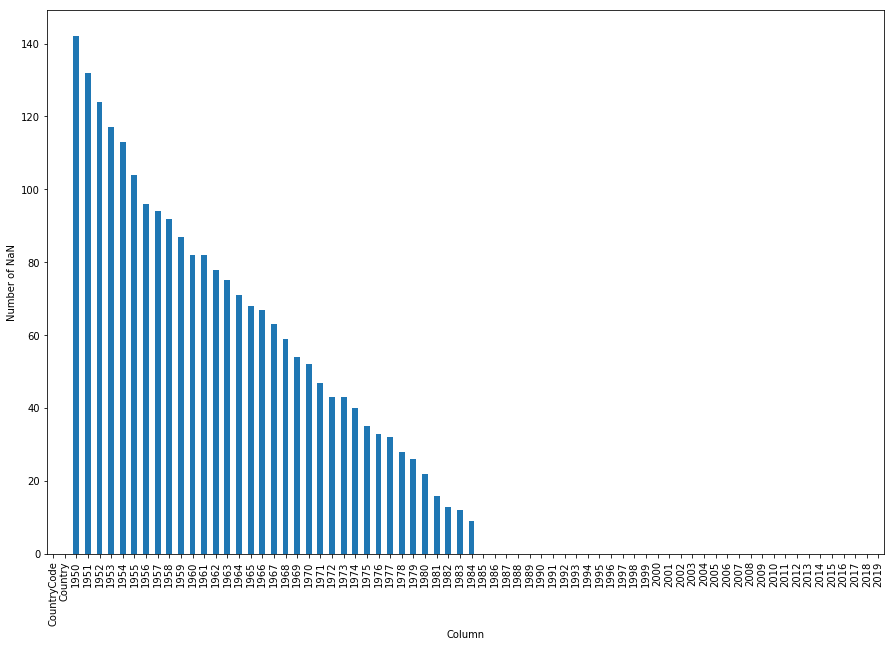

In [19]:
display(
    cmrdf.isna()
    .sum()
    .plot(kind="bar", figsize=(15, 10), xlabel="Column", ylabel="Number of NaN")
)

The NaN values seem to be concentrated towards the datapoints taken earlier, mostly before the 1980s. Data before 1979 is useless anyways, so there shouldn't be too much impact leaving a few nans in.

Let us remove the data prior to 1979 and after 2016.

In [20]:
cmrdf.drop(
    [str(x) for x in list(range(1950, 1979)) + list(range(2017, 2020))],
    axis=1,
    inplace=True,
)
cmrdf

CountryCode                             Country        1979        1980  \
0           AFG                         Afghanistan  165.257379  161.028132   
1           ALB                             Albania   71.181438   66.155752   
2           DZA                             Algeria  108.045384  101.794747   
3           AND                             Andorra         NaN         NaN   
4           AGO                              Angola         NaN  140.238393   
..          ...                                 ...         ...         ...   
190         VEN  Venezuela (Bolivarian Republic of)   36.571065   35.186548   
191         VNM                            Viet Nam   47.531900   46.631146   
192         YEM                               Yemen  147.133742  139.228105   
193         ZMB                              Zambia   95.096937   95.596715   
194         ZWE                            Zimbabwe   70.143121   68.574404   

           1981        1982        1983        1984        1985        1986  \
0    156.763436  152.481639  148.354144  144.321605  140.257604  136.247094   
1     61.475555   57.115470   53.214275   49.681820   46.508865   43.680472   
2     94.546163   86.274384   77.023313   67.696731   59.545794   53.206759   
3           NaN         NaN         NaN         NaN   10.106871    9.893521   
4    138.636313  137.023220  135.410888  134.155570  133.220981  132.510430   
..          ...         ...         ...         ...         ...         ...   
190   33.864139   32.649864   31.545204   30.547752   29.618986   28.669964   
191   45.737060   44.938104   44.172720   43.422350   42.616956   41.720032   
192  131.385962  123.940729  117.077235  111.019952  105.715362  101.186844   
193   96.032758   96.717562   97.831035   99.456249  101.373502  103.377671   
194   66.204777   63.317586   60.084513   56.855553   53.973998   51.651692   

     ...       2007       2008       2009       2010       2011       2012  \
0    ...  71.660270  69.035406  66.525823  64.100567  61.726441  59.454642   
1    ...  15.292477  14.077470  12.914518  11.828097  10.825056   9.963018   
2    ...  26.437225  25.349898  24.381526  23.562945  22.933794  22.471525   
3    ...   4.916380   4.680900   4.459207   4.256321   4.043769   3.850386   
4    ...  90.490680  85.345245  80.484163  75.868650  71.420473  67.316445   
..   ...        ...        ...        ...        ...        ...        ...   
190  ...  14.982381  14.745607  14.653889  14.666083  14.743388  14.887073   
191  ...  19.067110  18.766418  18.495580  18.261223  18.038662  17.818400   
192  ...  49.343347  46.984256  44.940469  43.634253  43.077472  42.964150   
193  ...  58.374573  55.919851  54.130195  52.323193  51.028241  49.923447   
194  ...  56.202805  56.418056  55.866004  53.776518  51.631998  47.853394   

          2013       2014       2015       2016  
0    57.225151  55.160932  53.169807  51.319141  
1     9.284420   8.805975   8.509460   8.378718  
2    22.137349  21.873076  21.612694  21.280396  
3     3.665888   3.495399   3.340385   3.200425  
4    63.715246  60.540468  57.816653  55.562227  
..         ...        ...        ...        ...  
190  15.119070  15.431784  16.436529  21.044404  
191  17.617092  17.417050  17.201177  16.937983  
192  42.962961  42.986121  43.358838  43.310794  
193  48.746112  47.472249  46.721240  45.789160  
194  45.864949  44.245706  42.868009  41.392057  

[195 rows x 40 columns]

`cmrdf` suffers from the same problem of iso-uncompliant country names, so let's fix that right now.

In [21]:
cmrdf.Country = cmrdf.CountryCode.apply(get_country_name)
display(cmrdf)

CountryCode                            Country        1979        1980  \
0           AFG                        Afghanistan  165.257379  161.028132   
1           ALB                            Albania   71.181438   66.155752   
2           DZA                            Algeria  108.045384  101.794747   
3           AND                            Andorra         NaN         NaN   
4           AGO                             Angola         NaN  140.238393   
..          ...                                ...         ...         ...   
190         VEN  Venezuela, Bolivarian Republic of   36.571065   35.186548   
191         VNM                           Viet Nam   47.531900   46.631146   
192         YEM                              Yemen  147.133742  139.228105   
193         ZMB                             Zambia   95.096937   95.596715   
194         ZWE                           Zimbabwe   70.143121   68.574404   

           1981        1982        1983        1984        1985        1986  \
0    156.763436  152.481639  148.354144  144.321605  140.257604  136.247094   
1     61.475555   57.115470   53.214275   49.681820   46.508865   43.680472   
2     94.546163   86.274384   77.023313   67.696731   59.545794   53.206759   
3           NaN         NaN         NaN         NaN   10.106871    9.893521   
4    138.636313  137.023220  135.410888  134.155570  133.220981  132.510430   
..          ...         ...         ...         ...         ...         ...   
190   33.864139   32.649864   31.545204   30.547752   29.618986   28.669964   
191   45.737060   44.938104   44.172720   43.422350   42.616956   41.720032   
192  131.385962  123.940729  117.077235  111.019952  105.715362  101.186844   
193   96.032758   96.717562   97.831035   99.456249  101.373502  103.377671   
194   66.204777   63.317586   60.084513   56.855553   53.973998   51.651692   

     ...       2007       2008       2009       2010       2011       2012  \
0    ...  71.660270  69.035406  66.525823  64.100567  61.726441  59.454642   
1    ...  15.292477  14.077470  12.914518  11.828097  10.825056   9.963018   
2    ...  26.437225  25.349898  24.381526  23.562945  22.933794  22.471525   
3    ...   4.916380   4.680900   4.459207   4.256321   4.043769   3.850386   
4    ...  90.490680  85.345245  80.484163  75.868650  71.420473  67.316445   
..   ...        ...        ...        ...        ...        ...        ...   
190  ...  14.982381  14.745607  14.653889  14.666083  14.743388  14.887073   
191  ...  19.067110  18.766418  18.495580  18.261223  18.038662  17.818400   
192  ...  49.343347  46.984256  44.940469  43.634253  43.077472  42.964150   
193  ...  58.374573  55.919851  54.130195  52.323193  51.028241  49.923447   
194  ...  56.202805  56.418056  55.866004  53.776518  51.631998  47.853394   

          2013       2014       2015       2016  
0    57.225151  55.160932  53.169807  51.319141  
1     9.284420   8.805975   8.509460   8.378718  
2    22.137349  21.873076  21.612694  21.280396  
3     3.665888   3.495399   3.340385   3.200425  
4    63.715246  60.540468  57.816653  55.562227  
..         ...        ...        ...        ...  
190  15.119070  15.431784  16.436529  21.044404  
191  17.617092  17.417050  17.201177  16.937983  
192  42.962961  42.986121  43.358838  43.310794  
193  48.746112  47.472249  46.721240  45.789160  
194  45.864949  44.245706  42.868009  41.392057  

[195 rows x 40 columns]

##### HDI Data
<a id='hdi'>

In [22]:
df = pd.read_excel("hdi.xlsx", sheet_name=0)
with pd.option_context("display.max_rows", None):
    display(df)

Unnamed: 0 Table 1. Human Development Index and its components   \
0          NaN                                                NaN     
1          NaN                                                NaN     
2          NaN                                                NaN     
3          NaN                                                NaN     
4     HDI rank                                            Country     
5          NaN                                                NaN     
6          NaN                        VERY HIGH HUMAN DEVELOPMENT     
7            1                                             Norway     
8            2                                        Switzerland     
9            3                                            Ireland     
10           4                                            Germany     
11           4                             Hong Kong, China (SAR)     
12           6                                          Australia     
13           6                                            Iceland     
14           8                                             Sweden     
15           9                                          Singapore     
16          10                                        Netherlands     
17          11                                            Denmark     
18          12                                            Finland     
19          13                                             Canada     
20          14                                        New Zealand     
21          15                                     United Kingdom     
22          15                                      United States     
23          17                                            Belgium     
24          18                                      Liechtenstein     
25          19                                              Japan     
26          20                                            Austria     
27          21                                         Luxembourg     
28          22                                             Israel     
29          22                                Korea (Republic of)     
30          24                                           Slovenia     
31          25                                              Spain     
32          26                                            Czechia     
33          26                                             France     
34          28                                              Malta     
35          29                                              Italy     
36          30                                            Estonia     
37          31                                             Cyprus     
38          32                                             Greece     
39          32                                             Poland     
40          34                                          Lithuania     
41          35                               United Arab Emirates     
42          36                                            Andorra     
43          36                                       Saudi Arabia     
44          36                                           Slovakia     
45          39                                             Latvia     
46          40                                           Portugal     
47          41                                              Qatar     
48          42                                              Chile     
49          43                                  Brunei Darussalam     
50          43                                            Hungary     
51          45                                            Bahrain     
52          46                                            Croatia     
53          47                                               Oman     
54          48                                          Argentina     
55          49              

Why doesn't a single database use standardised country codes?????? This is the same thing as before, only this time I was too lazy to type out the entire mapping so I just used pycountry's `fuzzy_search` instead. The country codes and names have been standardised, so it should be the same as that of the `df`s before it.

In [23]:
hdidf = df.iloc[7:199, [1, 2]].reset_index(drop=True)
hdidf.columns = ["Country", "HDI"]
hdidf.Country.replace(
    {"Congo (Democratic Republic of the)": "Congo, the Democratic Republic of the"},
    inplace=True,
)
hdidf.insert(0, "CountryCode", hdidf.Country.apply(get_country_code))
not_matched = hdidf[hdidf.CountryCode.isna()]
hdidf = hdidf[~hdidf.CountryCode.isna()]
display(hdidf)
not_matched = not_matched[~not_matched.Country.str.contains("DEVELOPMENT")]
not_matched.Country = not_matched.Country.str.split(",|\(", expand=True)[0]
not_matched.CountryCode = not_matched.Country.apply(
    lambda x: pycountry.countries.search_fuzzy(x)[0].alpha_3
)
hdidf = pd.concat([hdidf, not_matched])
hdidf.Country = hdidf.CountryCode.apply(get_country_name)
hdidf.sort_values(by="CountryCode", inplace=True)
hdidf.reset_index(inplace=True, drop=True)
display(not_matched)
display(hdidf)

CountryCode                   Country       HDI
0           NOR                    Norway  0.953688
1           CHE               Switzerland  0.945936
2           IRL                   Ireland  0.942473
3           DEU                   Germany  0.938785
5           AUS                 Australia  0.938379
..          ...                       ...       ...
187         BDI                   Burundi  0.422882
188         SSD               South Sudan   0.41277
189         TCD                      Chad  0.401176
190         CAF  Central African Republic  0.380662
191         NER                     Niger  0.376591

[180 rows x 3 columns]

CountryCode      Country       HDI
4           HKG    Hong Kong  0.938809
22          PRK       Korea   0.905832
65          IRN        Iran   0.797483
97          VEN   Venezuela   0.725773
107         MDA     Moldova   0.711452
114         BOL     Bolivia   0.702842
137         FSM  Micronesia   0.614158
140         SWZ    Eswatini   0.608082
161         TZA    Tanzania   0.528303

CountryCode               Country       HDI
0           AFG           Afghanistan   0.49596
1           AGO                Angola  0.574488
2           ALB               Albania  0.791406
3           AND               Andorra  0.856781
4           ARE  United Arab Emirates  0.866438
..          ...                   ...       ...
184         WSM                 Samoa  0.706771
185         YEM                 Yemen  0.462717
186         ZAF          South Africa  0.704937
187         ZMB                Zambia  0.591462
188         ZWE              Zimbabwe    0.5631

[189 rows x 3 columns]

#### Post-Cleaning
<a id='postcleaning'>

Data cleaning is now complete, and the datasets are as follows:

In [24]:
display(HTML("<h5>Mortality Causes DataFrame: </h5>"))
display(mdf)
display(HTML("<h5>BMI DataFrame: </h5>"))
display(bmidf)
display(HTML("<h5>CMR DataFrame: </h5>"))
display(cmrdf)
display(HTML("<h5>HDI DataFrame: </h5>"))
display(hdidf)

CountryCode               Country  Cause  \
0            ALB               Albania      1   
1            ALB               Albania      2   
2            ALB               Albania      5   
3            ALB               Albania      6   
4            ALB               Albania      7   
...          ...                   ...    ...   
1776         VIR  Virgin Islands, U.S.     12   
1777         VIR  Virgin Islands, U.S.     13   
1778         VIR  Virgin Islands, U.S.     14   
1779         VIR  Virgin Islands, U.S.     15   
1780         VIR  Virgin Islands, U.S.     16   

                                              CauseName 1979  1980  1981  \
0             Certain infectious and parasitic diseases  NaN   NaN   NaN   
1                                             Neoplasms  NaN   NaN   NaN   
2                      Mental and behavioural disorders  NaN   NaN   NaN   
3                        Diseases of the nervous system  NaN   NaN   NaN   
4                        Diseases of the eye and adnexa  NaN   NaN   NaN   
...                                                 ...  ...   ...   ...   
1776       Diseases of the skin and subcutaneous tissue  NaN   3.0   NaN   
1777  Diseases of the musculoskeletal system and con...  NaN   3.2   NaN   
1778               Diseases of the genitourinary system  NaN  13.9   NaN   
1779           Pregnancy, childbirth and the puerperium  NaN  14.7   NaN   
1780  Congenital malformations, deformations and chr...  NaN   8.7   NaN   

      1982  1983  1984  ...  2007  2008  2009  2010  2011  2012  2013  2014  \
0      NaN   NaN   NaN  ...   2.0   2.0   1.1   1.2   NaN   NaN   NaN   NaN   
1      NaN   NaN   NaN  ...  74.2  80.5  74.7  56.4   NaN   NaN   NaN   NaN   
2      NaN   NaN   NaN  ...   1.8   1.6   1.5   1.7   NaN   NaN   NaN   NaN   
3      NaN   NaN   NaN  ...  12.7   4.8   4.8   7.3   NaN   NaN   NaN   NaN   
4      NaN   NaN   NaN  ...   0.1   0.1   0.1   0.1   NaN   NaN   NaN   NaN   
...    ...   ...   ...  ...   ...   ...   ...   ...   ...   ...   ...   ...   
1776   NaN   NaN   NaN  ...   2.5   1.4   0.7   4.1   1.8   0.6   NaN   NaN   
1777   NaN   NaN   NaN  ...   3.6   3.0   1.7   2.9   2.4   4.3   NaN   NaN   
1778   NaN   NaN   NaN  ...   8.6   6.8   7.5  13.8   7.1   7.7   NaN   NaN   
1779   NaN   NaN   NaN  ...   0.0   0.0   0.0   0.0   0.0   0.0   NaN   NaN   
1780   NaN   NaN   NaN  ...   7.1   4.0   1.1   4.1   3.5   2.4   NaN   NaN   

      2015  2016  
0      NaN   NaN  
1      NaN   NaN  
2      NaN   NaN  
3      NaN   NaN  
4      NaN   NaN  
...    ...   ...  
1776   1.0   NaN  
1777   1.6   NaN  
1778   8.3   NaN  
1779   0.0   NaN  
1780   0.8   NaN  

[1781 rows x 42 columns]

CountryCode                            Country  1979  1980  1981  1982  \
0           AFG                        Afghanistan  19.4  19.5  19.6  19.8   
1           ALB                            Albania  24.0  24.1  24.1  24.2   
2           DZA                            Algeria  22.2  22.3  22.4  22.5   
3           AND                            Andorra  25.7  25.8  25.9  25.9   
4           AGO                             Angola  19.3  19.4  19.5  19.6   
..          ...                                ...   ...   ...   ...   ...   
181         VEN  Venezuela, Bolivarian Republic of  24.4  24.5  24.6  24.7   
182         VNM                           Viet Nam  18.4  18.5  18.6  18.6   
183         YEM                              Yemen  20.1  20.2  20.3  20.4   
184         ZMB                             Zambia  20.0  20.1  20.2  20.4   
185         ZWE                           Zimbabwe  22.3  22.3  22.4  22.4   

     1983  1984  1985  1986  ...  2007  2008  2009  2010  2011  2012  2013  \
0    19.9  20.0  20.1  20.2  ...  22.4  22.5  22.6  22.7  22.8  22.9  23.0   
1    24.2  24.3  24.3  24.4  ...  25.8  25.9  26.0  26.1  26.2  26.3  26.4   
2    22.6  22.7  22.8  22.9  ...  24.8  24.9  25.0  25.1  25.1  25.2  25.3   
3    26.0  26.0  26.1  26.2  ...  26.8  26.8  26.8  26.8  26.8  26.8  26.8   
4    19.8  19.9  20.0  20.1  ...  22.5  22.6  22.7  22.8  22.9  23.0  23.1   
..    ...   ...   ...   ...  ...   ...   ...   ...   ...   ...   ...   ...   
181  24.8  24.9  25.0  25.1  ...  26.5  26.5  26.6  26.6  26.6  26.6  26.6   
182  18.7  18.8  18.8  18.9  ...  20.7  20.8  20.9  21.0  21.2  21.3  21.5   
183  20.5  20.6  20.7  20.8  ...  23.0  23.1  23.2  23.3  23.4  23.4  23.5   
184  20.5  20.5  20.6  20.7  ...  22.0  22.0  22.1  22.2  22.2  22.3  22.4   
185  22.5  22.6  22.6  22.7  ...  23.5  23.6  23.6  23.6  23.7  23.7  23.7   

     2014  2015  2016  
0    23.2  23.3  23.4  
1    26.5  26.6  26.7  
2    25.4  25.5  25.5  
3    26.7  26.7  26.7  
4    23.2  23.2  23.3  
..    ...   ...   ...  
181  26.6  26.7  26.7  
182  21.6  21.7  21.9  
183  23.6  23.7  23.8  
184  22.4  22.5  22.6  
185  23.8  23.8  23.8  

[186 rows x 40 columns]

CountryCode                            Country        1979        1980  \
0           AFG                        Afghanistan  165.257379  161.028132   
1           ALB                            Albania   71.181438   66.155752   
2           DZA                            Algeria  108.045384  101.794747   
3           AND                            Andorra         NaN         NaN   
4           AGO                             Angola         NaN  140.238393   
..          ...                                ...         ...         ...   
190         VEN  Venezuela, Bolivarian Republic of   36.571065   35.186548   
191         VNM                           Viet Nam   47.531900   46.631146   
192         YEM                              Yemen  147.133742  139.228105   
193         ZMB                             Zambia   95.096937   95.596715   
194         ZWE                           Zimbabwe   70.143121   68.574404   

           1981        1982        1983        1984        1985        1986  \
0    156.763436  152.481639  148.354144  144.321605  140.257604  136.247094   
1     61.475555   57.115470   53.214275   49.681820   46.508865   43.680472   
2     94.546163   86.274384   77.023313   67.696731   59.545794   53.206759   
3           NaN         NaN         NaN         NaN   10.106871    9.893521   
4    138.636313  137.023220  135.410888  134.155570  133.220981  132.510430   
..          ...         ...         ...         ...         ...         ...   
190   33.864139   32.649864   31.545204   30.547752   29.618986   28.669964   
191   45.737060   44.938104   44.172720   43.422350   42.616956   41.720032   
192  131.385962  123.940729  117.077235  111.019952  105.715362  101.186844   
193   96.032758   96.717562   97.831035   99.456249  101.373502  103.377671   
194   66.204777   63.317586   60.084513   56.855553   53.973998   51.651692   

     ...       2007       2008       2009       2010       2011       2012  \
0    ...  71.660270  69.035406  66.525823  64.100567  61.726441  59.454642   
1    ...  15.292477  14.077470  12.914518  11.828097  10.825056   9.963018   
2    ...  26.437225  25.349898  24.381526  23.562945  22.933794  22.471525   
3    ...   4.916380   4.680900   4.459207   4.256321   4.043769   3.850386   
4    ...  90.490680  85.345245  80.484163  75.868650  71.420473  67.316445   
..   ...        ...        ...        ...        ...        ...        ...   
190  ...  14.982381  14.745607  14.653889  14.666083  14.743388  14.887073   
191  ...  19.067110  18.766418  18.495580  18.261223  18.038662  17.818400   
192  ...  49.343347  46.984256  44.940469  43.634253  43.077472  42.964150   
193  ...  58.374573  55.919851  54.130195  52.323193  51.028241  49.923447   
194  ...  56.202805  56.418056  55.866004  53.776518  51.631998  47.853394   

          2013       2014       2015       2016  
0    57.225151  55.160932  53.169807  51.319141  
1     9.284420   8.805975   8.509460   8.378718  
2    22.137349  21.873076  21.612694  21.280396  
3     3.665888   3.495399   3.340385   3.200425  
4    63.715246  60.540468  57.816653  55.562227  
..         ...        ...        ...        ...  
190  15.119070  15.431784  16.436529  21.044404  
191  17.617092  17.417050  17.201177  16.937983  
192  42.962961  42.986121  43.358838  43.310794  
193  48.746112  47.472249  46.721240  45.789160  
194  45.864949  44.245706  42.868009  41.392057  

[195 rows x 40 columns]

CountryCode               Country       HDI
0           AFG           Afghanistan   0.49596
1           AGO                Angola  0.574488
2           ALB               Albania  0.791406
3           AND               Andorra  0.856781
4           ARE  United Arab Emirates  0.866438
..          ...                   ...       ...
184         WSM                 Samoa  0.706771
185         YEM                 Yemen  0.462717
186         ZAF          South Africa  0.704937
187         ZMB                Zambia  0.591462
188         ZWE              Zimbabwe    0.5631

[189 rows x 3 columns]

Let us create some long versions of the DataFrames as well.

In [25]:
longmdf = pd.melt(
    mdf,
    id_vars=["CountryCode", "Country", "Cause", "CauseName"],
    var_name="Year",
    value_name="DeathsPer100k",
)
longbmidf = pd.melt(
    bmidf, id_vars=["CountryCode", "Country"], var_name="Year", value_name="BMI"
)
longcmrdf = pd.melt(
    cmrdf, id_vars=["CountryCode", "Country"], var_name="Year", value_name="CMR"
)
display(longmdf)
display(longbmidf)
display(longcmrdf)

CountryCode               Country  Cause  \
0             ALB               Albania      1   
1             ALB               Albania      2   
2             ALB               Albania      5   
3             ALB               Albania      6   
4             ALB               Albania      7   
...           ...                   ...    ...   
67673         VIR  Virgin Islands, U.S.     12   
67674         VIR  Virgin Islands, U.S.     13   
67675         VIR  Virgin Islands, U.S.     14   
67676         VIR  Virgin Islands, U.S.     15   
67677         VIR  Virgin Islands, U.S.     16   

                                               CauseName  Year DeathsPer100k  
0              Certain infectious and parasitic diseases  1979           NaN  
1                                              Neoplasms  1979           NaN  
2                       Mental and behavioural disorders  1979           NaN  
3                         Diseases of the nervous system  1979           NaN  
4                         Diseases of the eye and adnexa  1979           NaN  
...                                                  ...   ...           ...  
67673       Diseases of the skin and subcutaneous tissue  2016           NaN  
67674  Diseases of the musculoskeletal system and con...  2016           NaN  
67675               Diseases of the genitourinary system  2016           NaN  
67676           Pregnancy, childbirth and the puerperium  2016           NaN  
67677  Congenital malformations, deformations and chr...  2016           NaN  

[67678 rows x 6 columns]

CountryCode                            Country  Year   BMI
0            AFG                        Afghanistan  1979  19.4
1            ALB                            Albania  1979  24.0
2            DZA                            Algeria  1979  22.2
3            AND                            Andorra  1979  25.7
4            AGO                             Angola  1979  19.3
...          ...                                ...   ...   ...
7063         VEN  Venezuela, Bolivarian Republic of  2016  26.7
7064         VNM                           Viet Nam  2016  21.9
7065         YEM                              Yemen  2016  23.8
7066         ZMB                             Zambia  2016  22.6
7067         ZWE                           Zimbabwe  2016  23.8

[7068 rows x 4 columns]

CountryCode                            Country  Year         CMR
0            AFG                        Afghanistan  1979  165.257379
1            ALB                            Albania  1979   71.181438
2            DZA                            Algeria  1979  108.045384
3            AND                            Andorra  1979         NaN
4            AGO                             Angola  1979         NaN
...          ...                                ...   ...         ...
7405         VEN  Venezuela, Bolivarian Republic of  2016   21.044404
7406         VNM                           Viet Nam  2016   16.937983
7407         YEM                              Yemen  2016   43.310794
7408         ZMB                             Zambia  2016   45.789160
7409         ZWE                           Zimbabwe  2016   41.392057

[7410 rows x 4 columns]

## Questions
<a id='questions'/>

### 1. How has the leading cause of mortality in a country changed over time?
<a id='causeOverTime'/>

#### Results
<a id='result1'>

In general, the leading cause of mortality has shifted from infectious and parasitic diseases to diseases of the circulatory system to neoplasms as time progresses.

Circulatory system illness remain by far the most common cause of death with neoplasms trailing behind. The other causes are far below these two.

Countries that are outliers when it comes to causes of death generally remain outliers for at least a decade. This shows that in order to be an outlier, there must be something habitual that these countries cannot fix quickly.

#### EDA
<a id='eda1'>

##### Lineplots
<a id='lineplots1'>

Let us find the proportion of deaths caused by each Cause globally. Note that the total number of deaths per year changes, so we need to divide the deaths per 100,000 per Cause by total deaths per 100,000.

Cause        1980  \
CauseName                                                               
Certain infectious and parasitic diseases               1   27.803922   
Congenital malformations, deformations and chro...     16    7.135294   
Diseases of the blood and blood-forming organs ...      3         NaN   
Diseases of the circulatory system                      9  328.562745   
Diseases of the digestive system                       11   38.401961   
Diseases of the ear and mastoid process                 8    0.126531   
Diseases of the eye and adnexa                          7    0.018367   
Diseases of the genitourinary system                   14   16.170588   
Diseases of the musculoskeletal system and conn...     13    2.301961   
Diseases of the nervous system                          6   11.232653   
Diseases of the respiratory system                     10   69.078431   
Diseases of the skin and subcutaneous tissue           12    1.605882   
Endocrine, nutritional and metabolic diseases           4         NaN   
Mental and behavioural disorders                        5    4.821569   
Neoplasms                                               2  126.821569   
Pregnancy, childbirth and the puerperium               15    2.725490   

                                                          1981        1982  \
CauseName                                                                    
Certain infectious and parasitic diseases            26.175385   22.732258   
Congenital malformations, deformations and chro...    7.244615    7.243548   
Diseases of the blood and blood-forming organs ...         NaN         NaN   
Diseases of the circulatory system                  343.403077  342.240323   
Diseases of the digestive system                     35.346154   34.383871   
Diseases of the ear and mastoid process               0.111765    0.089583   
Diseases of the eye and adnexa                        0.025490    0.027083   
Diseases of the genitourinary system                 14.744615   14.685484   
Diseases of the musculoskeletal system and conn...    2.067692    2.088710   
Diseases of the nervous system                       10.815686   10.931250   
Diseases of the respiratory system                   72.336923   68.637097   
Diseases of the skin and subcutaneous tissue          1.296923    1.341935   
Endocrine, nutritional and metabolic diseases              NaN         NaN   
Mental and behavioural disorders                      5.212308    4.556452   
Neoplasms                                           124.909231  126.882258   
Pregnancy, childbirth and the puerperium              2.200000    2.079032   

                                                          1983        1984  \
CauseName                                                                    
Certain infectious and parasitic diseases            21.658824   27.177358   
Congenital malformations, deformations and chro...    6.976471    6.639623   
Diseases of the blood and blood-forming organs ...         NaN         NaN   
Diseases of the circulatory system                  308.686275  300.616981   
Diseases of the digestive system                     32.658824   34.226415   
Diseases of the ear and mastoid process               0.097959    0.088235   
Diseases of the eye and adnexa                        0.057143    0.054902   
Diseases of the genitourinary system                 15.192157   14.401887   
Diseases of the musculoskeletal system and conn...    2.552941    2.475472   
Diseases of the nervous system                       11.522449   11.086275   
Diseases of the respiratory system                   62.301961   62.445283   
Diseases of the skin and subcutaneous tissue          1.870588    1.647170   
Endocrine, nutritional and metabolic diseases              NaN         NaN   
Mental and behavioural disorders                      4.733333    4.796226   
Neoplasms                                           129.123529  126.988679   
Pregna

Cause    136.000000
1980     636.806963
1981     645.889864
1982     637.918884
1983     599.208924
            ...    
2012     467.402162
2013     450.302819
2014     452.796591
2015     463.176471
2016     486.822222
Length: 38, dtype: float64

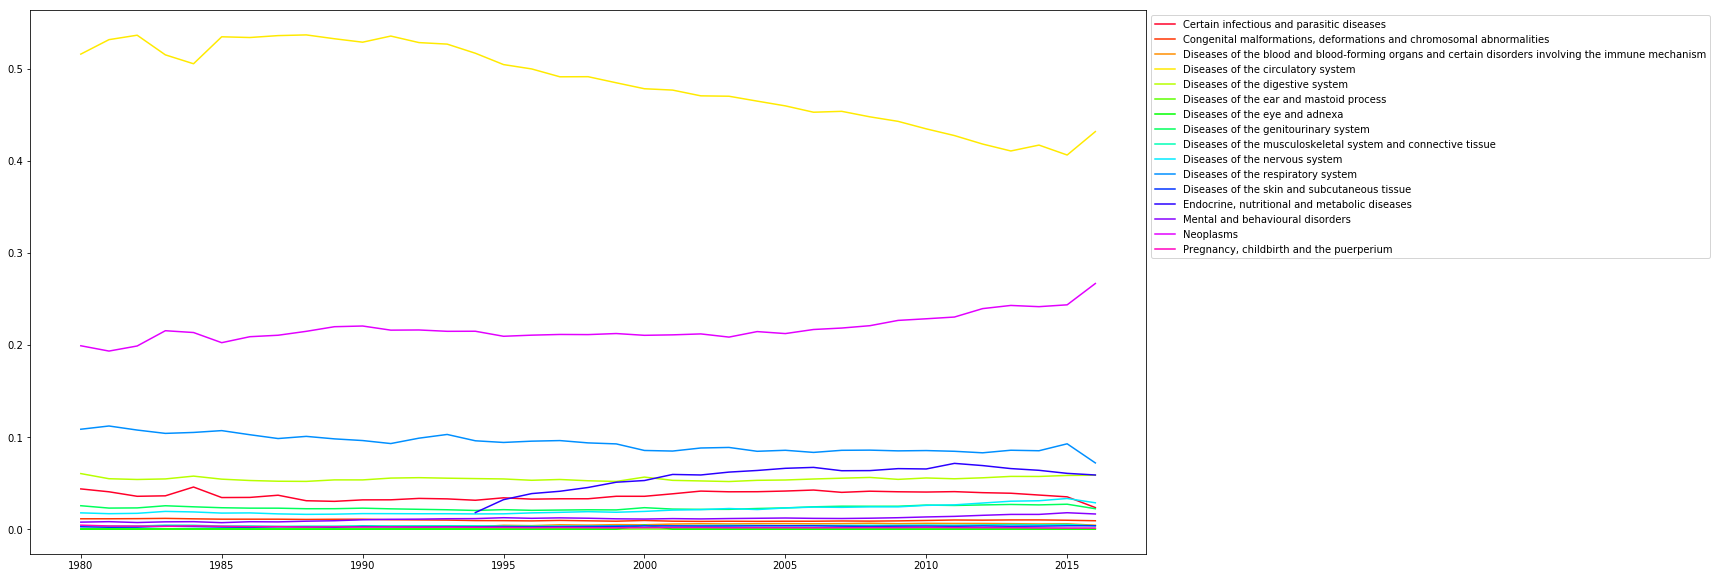

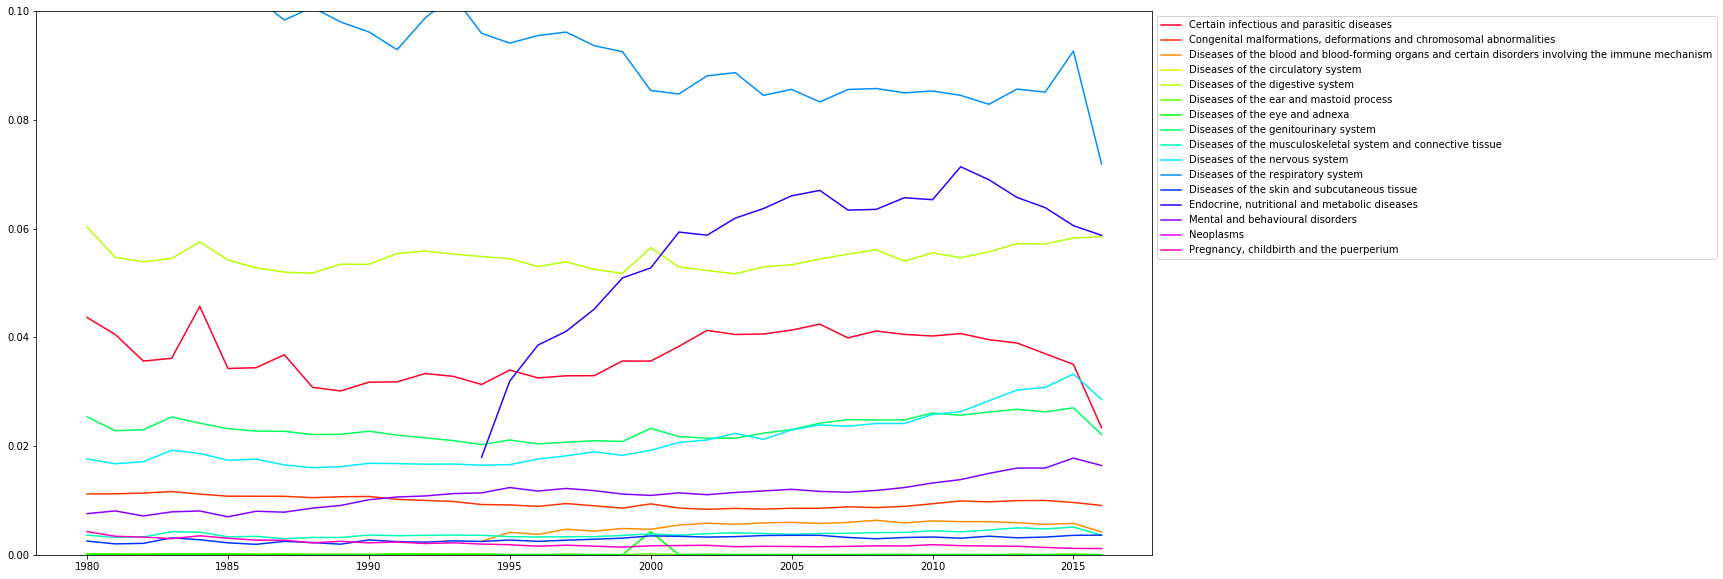

In [26]:
deathsPerYearByCause = mdf.groupby("CauseName").mean()
display(deathsPerYearByCause)
display(deathsPerYearByCause.sum())
dpybcNormal = (deathsPerYearByCause / deathsPerYearByCause.sum()).drop("Cause", axis=1)
dpybcNormal.T.plot(kind="line", figsize=(20, 10), colormap='gist_rainbow').legend(bbox_to_anchor=(1, 1))
dpybcNormal.T.plot(kind="line", figsize=(20, 10), colormap='gist_rainbow', ylim=(0, 0.1)).legend(
    bbox_to_anchor=(1, 1)
)

The cause with the highest fraction of deaths by far is that of circulatory diseases. This has been decreasing since the 1990s but have recently risen.

The second is neoplasms, which is essentially cancer. This has been gradually increasing since the 1980s, but have recently spiked.

At around 1984, cardiovascular diseases suddenly took a dip while then number 2, 4, 5 (neoplasms, digestive diseases, infectious diseases) spiked.

The third is respiratory diseases. Respiratory diseases in general have been decreasing as the world becomes more developed. 

Endocrine, nutritional and metabolic diseases have been on the rise quite rapidly since 1994.

##### Animated Choropleth Maps
<a id='aniChoro1'>

Let us make an animated map of cardiovascular disease deaths across time. The data has to be interpolated based on last recorded number of deaths. This would prevent the countries' color from snapping in between an actual color and gray.

In [27]:
import plotly.express as px
from plotly.offline import init_notebook_mode

init_notebook_mode(connected=True)
mdf.loc[:, "1979":"2016"].apply(pd.to_numeric, errors="coerce")
mdf["1979"] = mdf["1979"].astype(float)
display(mdf)

# with pd.option_context('display.max_rows', None):
mdfInterp = pd.concat(
    [mdf.iloc[:, :4], mdf.loc[:, "1979":"2016"].interpolate(method="pad", axis=1)],
    axis=1,
)
display(mdfInterp)

CountryCode               Country  Cause  \
0            ALB               Albania      1   
1            ALB               Albania      2   
2            ALB               Albania      5   
3            ALB               Albania      6   
4            ALB               Albania      7   
...          ...                   ...    ...   
1776         VIR  Virgin Islands, U.S.     12   
1777         VIR  Virgin Islands, U.S.     13   
1778         VIR  Virgin Islands, U.S.     14   
1779         VIR  Virgin Islands, U.S.     15   
1780         VIR  Virgin Islands, U.S.     16   

                                              CauseName  1979  1980  1981  \
0             Certain infectious and parasitic diseases   NaN   NaN   NaN   
1                                             Neoplasms   NaN   NaN   NaN   
2                      Mental and behavioural disorders   NaN   NaN   NaN   
3                        Diseases of the nervous system   NaN   NaN   NaN   
4                        Diseases of the eye and adnexa   NaN   NaN   NaN   
...                                                 ...   ...   ...   ...   
1776       Diseases of the skin and subcutaneous tissue   NaN   3.0   NaN   
1777  Diseases of the musculoskeletal system and con...   NaN   3.2   NaN   
1778               Diseases of the genitourinary system   NaN  13.9   NaN   
1779           Pregnancy, childbirth and the puerperium   NaN  14.7   NaN   
1780  Congenital malformations, deformations and chr...   NaN   8.7   NaN   

      1982  1983  1984  ...  2007  2008  2009  2010  2011  2012  2013  2014  \
0      NaN   NaN   NaN  ...   2.0   2.0   1.1   1.2   NaN   NaN   NaN   NaN   
1      NaN   NaN   NaN  ...  74.2  80.5  74.7  56.4   NaN   NaN   NaN   NaN   
2      NaN   NaN   NaN  ...   1.8   1.6   1.5   1.7   NaN   NaN   NaN   NaN   
3      NaN   NaN   NaN  ...  12.7   4.8   4.8   7.3   NaN   NaN   NaN   NaN   
4      NaN   NaN   NaN  ...   0.1   0.1   0.1   0.1   NaN   NaN   NaN   NaN   
...    ...   ...   ...  ...   ...   ...   ...   ...   ...   ...   ...   ...   
1776   NaN   NaN   NaN  ...   2.5   1.4   0.7   4.1   1.8   0.6   NaN   NaN   
1777   NaN   NaN   NaN  ...   3.6   3.0   1.7   2.9   2.4   4.3   NaN   NaN   
1778   NaN   NaN   NaN  ...   8.6   6.8   7.5  13.8   7.1   7.7   NaN   NaN   
1779   NaN   NaN   NaN  ...   0.0   0.0   0.0   0.0   0.0   0.0   NaN   NaN   
1780   NaN   NaN   NaN  ...   7.1   4.0   1.1   4.1   3.5   2.4   NaN   NaN   

      2015  2016  
0      NaN   NaN  
1      NaN   NaN  
2      NaN   NaN  
3      NaN   NaN  
4      NaN   NaN  
...    ...   ...  
1776   1.0   NaN  
1777   1.6   NaN  
1778   8.3   NaN  
1779   0.0   NaN  
1780   0.8   NaN  

[1781 rows x 42 columns]

CountryCode               Country  Cause  \
0            ALB               Albania      1   
1            ALB               Albania      2   
2            ALB               Albania      5   
3            ALB               Albania      6   
4            ALB               Albania      7   
...          ...                   ...    ...   
1776         VIR  Virgin Islands, U.S.     12   
1777         VIR  Virgin Islands, U.S.     13   
1778         VIR  Virgin Islands, U.S.     14   
1779         VIR  Virgin Islands, U.S.     15   
1780         VIR  Virgin Islands, U.S.     16   

                                              CauseName  1979  1980  1981  \
0             Certain infectious and parasitic diseases   NaN   NaN   NaN   
1                                             Neoplasms   NaN   NaN   NaN   
2                      Mental and behavioural disorders   NaN   NaN   NaN   
3                        Diseases of the nervous system   NaN   NaN   NaN   
4                        Diseases of the eye and adnexa   NaN   NaN   NaN   
...                                                 ...   ...   ...   ...   
1776       Diseases of the skin and subcutaneous tissue   NaN   3.0   3.0   
1777  Diseases of the musculoskeletal system and con...   NaN   3.2   3.2   
1778               Diseases of the genitourinary system   NaN  13.9  13.9   
1779           Pregnancy, childbirth and the puerperium   NaN  14.7  14.7   
1780  Congenital malformations, deformations and chr...   NaN   8.7   8.7   

      1982  1983  1984  ...  2007  2008  2009  2010  2011  2012  2013  2014  \
0      NaN   NaN   NaN  ...   2.0   2.0   1.1   1.2   1.2   1.2   1.2   1.2   
1      NaN   NaN   NaN  ...  74.2  80.5  74.7  56.4  56.4  56.4  56.4  56.4   
2      NaN   NaN   NaN  ...   1.8   1.6   1.5   1.7   1.7   1.7   1.7   1.7   
3      NaN   NaN   NaN  ...  12.7   4.8   4.8   7.3   7.3   7.3   7.3   7.3   
4      NaN   NaN   NaN  ...   0.1   0.1   0.1   0.1   0.1   0.1   0.1   0.1   
...    ...   ...   ...  ...   ...   ...   ...   ...   ...   ...   ...   ...   
1776   3.0   3.0   3.0  ...   2.5   1.4   0.7   4.1   1.8   0.6   0.6   0.6   
1777   3.2   3.2   3.2  ...   3.6   3.0   1.7   2.9   2.4   4.3   4.3   4.3   
1778  13.9  13.9  13.9  ...   8.6   6.8   7.5  13.8   7.1   7.7   7.7   7.7   
1779  14.7  14.7  14.7  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1780   8.7   8.7   8.7  ...   7.1   4.0   1.1   4.1   3.5   2.4   2.4   2.4   

      2015  2016  
0      1.2   1.2  
1     56.4  56.4  
2      1.7   1.7  
3      7.3   7.3  
4      0.1   0.1  
...    ...   ...  
1776   1.0   1.0  
1777   1.6   1.6  
1778   8.3   8.3  
1779   0.0   0.0  
1780   0.8   0.8  

[1781 rows x 42 columns]

We will now convert the DataFrame to a "long" format from the current "wide" format by using the method `melt`. This prepares the data for the choropleth visualization.

In [28]:
forMap = pd.melt(
    mdfInterp, id_vars=["CountryCode", "Country", "Cause", "CauseName"], var_name="Year"
)
forMap.reset_index(inplace=True, drop=True)
forMap.rename(columns={"value": "DeathsPer100k"}, inplace=True)
forMap.DeathsPer100k = forMap.DeathsPer100k.astype(float)

display(forMap)

CountryCode               Country  Cause  \
0             ALB               Albania      1   
1             ALB               Albania      2   
2             ALB               Albania      5   
3             ALB               Albania      6   
4             ALB               Albania      7   
...           ...                   ...    ...   
67673         VIR  Virgin Islands, U.S.     12   
67674         VIR  Virgin Islands, U.S.     13   
67675         VIR  Virgin Islands, U.S.     14   
67676         VIR  Virgin Islands, U.S.     15   
67677         VIR  Virgin Islands, U.S.     16   

                                               CauseName  Year  DeathsPer100k  
0              Certain infectious and parasitic diseases  1979            NaN  
1                                              Neoplasms  1979            NaN  
2                       Mental and behavioural disorders  1979            NaN  
3                         Diseases of the nervous system  1979            NaN  
4                         Diseases of the eye and adnexa  1979            NaN  
...                                                  ...   ...            ...  
67673       Diseases of the skin and subcutaneous tissue  2016            1.0  
67674  Diseases of the musculoskeletal system and con...  2016            1.6  
67675               Diseases of the genitourinary system  2016            8.3  
67676           Pregnancy, childbirth and the puerperium  2016            0.0  
67677  Congenital malformations, deformations and chr...  2016            0.8  

[67678 rows x 6 columns]

We will now divide `DeathsPer100k` by the total number of deaths in that country, in that year. This is because different countries have different total rates of death, and this question aims to analyse the *proportion* of deaths due to a particular cause globally across the years.

In [29]:
totalDeathsSeries = forMap.groupby(["CountryCode", "Year"]).DeathsPer100k.sum()


def calculate_death_prop(row):
    if row.DeathsPer100k != np.nan:
        totalDeaths = totalDeathsSeries.loc[(row.CountryCode, row.Year)]
        row.DeathsPer100k = row.DeathsPer100k / totalDeaths
    return row


display(forMap)
forMapCalibed = forMap.apply(
    calculate_death_prop, axis=1
)  # re-calibrated DataFrame for map creation
forMapCalibed.rename(columns={"DeathsPer100k": "DeathsProp"}, inplace=True)
display(forMapCalibed)

CountryCode               Country  Cause  \
0             ALB               Albania      1   
1             ALB               Albania      2   
2             ALB               Albania      5   
3             ALB               Albania      6   
4             ALB               Albania      7   
...           ...                   ...    ...   
67673         VIR  Virgin Islands, U.S.     12   
67674         VIR  Virgin Islands, U.S.     13   
67675         VIR  Virgin Islands, U.S.     14   
67676         VIR  Virgin Islands, U.S.     15   
67677         VIR  Virgin Islands, U.S.     16   

                                               CauseName  Year  DeathsPer100k  
0              Certain infectious and parasitic diseases  1979            NaN  
1                                              Neoplasms  1979            NaN  
2                       Mental and behavioural disorders  1979            NaN  
3                         Diseases of the nervous system  1979            NaN  
4                         Diseases of the eye and adnexa  1979            NaN  
...                                                  ...   ...            ...  
67673       Diseases of the skin and subcutaneous tissue  2016            1.0  
67674  Diseases of the musculoskeletal system and con...  2016            1.6  
67675               Diseases of the genitourinary system  2016            8.3  
67676           Pregnancy, childbirth and the puerperium  2016            0.0  
67677  Congenital malformations, deformations and chr...  2016            0.8  

[67678 rows x 6 columns]

CountryCode               Country  Cause  \
0             ALB               Albania      1   
1             ALB               Albania      2   
2             ALB               Albania      5   
3             ALB               Albania      6   
4             ALB               Albania      7   
...           ...                   ...    ...   
67673         VIR  Virgin Islands, U.S.     12   
67674         VIR  Virgin Islands, U.S.     13   
67675         VIR  Virgin Islands, U.S.     14   
67676         VIR  Virgin Islands, U.S.     15   
67677         VIR  Virgin Islands, U.S.     16   

                                               CauseName  Year  DeathsProp  
0              Certain infectious and parasitic diseases  1979         NaN  
1                                              Neoplasms  1979         NaN  
2                       Mental and behavioural disorders  1979         NaN  
3                         Diseases of the nervous system  1979         NaN  
4                         Diseases of the eye and adnexa  1979         NaN  
...                                                  ...   ...         ...  
67673       Diseases of the skin and subcutaneous tissue  2016    0.003338  
67674  Diseases of the musculoskeletal system and con...  2016    0.005340  
67675               Diseases of the genitourinary system  2016    0.027704  
67676           Pregnancy, childbirth and the puerperium  2016    0.000000  
67677  Congenital malformations, deformations and chr...  2016    0.002670  

[67678 rows x 6 columns]

We will now normalize the data using the min-max method.

In [30]:
forMapCalibed.DeathsProp /= (
    forMapCalibed.DeathsProp.max() - forMapCalibed.DeathsProp.min()
)
forMapCalibed

CountryCode               Country  Cause  \
0             ALB               Albania      1   
1             ALB               Albania      2   
2             ALB               Albania      5   
3             ALB               Albania      6   
4             ALB               Albania      7   
...           ...                   ...    ...   
67673         VIR  Virgin Islands, U.S.     12   
67674         VIR  Virgin Islands, U.S.     13   
67675         VIR  Virgin Islands, U.S.     14   
67676         VIR  Virgin Islands, U.S.     15   
67677         VIR  Virgin Islands, U.S.     16   

                                               CauseName  Year  DeathsProp  
0              Certain infectious and parasitic diseases  1979         NaN  
1                                              Neoplasms  1979         NaN  
2                       Mental and behavioural disorders  1979         NaN  
3                         Diseases of the nervous system  1979         NaN  
4                         Diseases of the eye and adnexa  1979         NaN  
...                                                  ...   ...         ...  
67673       Diseases of the skin and subcutaneous tissue  2016    0.004068  
67674  Diseases of the musculoskeletal system and con...  2016    0.006509  
67675               Diseases of the genitourinary system  2016    0.033764  
67676           Pregnancy, childbirth and the puerperium  2016    0.000000  
67677  Congenital malformations, deformations and chr...  2016    0.003254  

[67678 rows x 6 columns]

As one can see, the DeathsPer100k have been successfully converted to DeathsProp and the normalization has also done its job. For instance, the deaths figure for `CountryCode=VIR` and `Cause=14` has been converted from 8.3 originally to 0.027 after calibration to 0.033 after normalization. Now we can make our animated choropleth maps.

Note: Please see individual .html files for the results.

In [31]:
for cause in range(1, 17):
    forMapWithCause = forMapCalibed[forMapCalibed.Cause == cause]
    fig = px.choropleth(
        forMapWithCause,  # Input Dataframe
        locations="CountryCode",  # identify country code column
        color="DeathsProp",  # identify representing column
        hover_name="Country",  # identify hover name
        animation_frame="Year",  # identify date column
        projection="natural earth",  # select projection
        color_continuous_scale="Viridis",  # select preferred color scale
        range_color=[0, forMapWithCause.DeathsProp.max()],  # select range of dataset
        title=str(cause) + ". " + disease_codes.loc[cause, "name"],
    )
    fig.write_html("q1choropleth" + format(cause, "02d") + ".html", full_html=False)

I will go over some graphs that I find to be interesting.

Graph 9, diseases of the circulatory system: You can see a clear trend of the American countries gradually having circulatory system diseases become a smaller part of their causes of death. Most of Europe is exhibiting the same trend as well, with Eastern Bloc nations lagging behind the First World by about 30 years. Kazakhstan is the exception here, as it has reduced its circulatory disease deaths proportion significant in recent years. Egypt is roughly following the same trend as the Eastern Bloc.

Surprisingly, Mexico and Guatemala has since 1979 shown a very low proportion of deaths due to this cause. This breaks the trend of more developed countries having a lower proportion.

Graph 2, neoplasms: Compared to graph 9, the trend here is much less clear. In recent years, many developed countries have started to have a high proportion of this cause of death. In contrast to cardiovascular diseases, the countries' colors also tend to fluctuate a bit more between light and dark, indicating that the trend is much less obvious.

Graph 5, mental and behavioural disorders: First World countries have been experiencing a higher number of deaths due to this cause in the past 20 years, starting with Finland. I think this may be due to mental health becoming better documented in developed countries. Moreover, in many developing countries, parents would discreetly kill their child if they perceive something to be wrong with their minds early on, which makes this statistic a tad unreliable.

Graph 11, digestive system: Mexico and Guatemala has consistently shown a higher proportion of deaths due to this cause. Egypt and Eastern Bloc countries have also been especially vulnerable in recent years.

Graph 10, respiratory system: Guatemala is exceptionally high here. Most of South America as well as Kazakhstan have seen increases in this cause in the past few years.

Now we shall plot the leading cause of death globally over time. This will be similar to the choropleth plotted above but this time the data is discrete rather than continous. We have to first make a `DataFrame` of leading cause of death and number of deaths (for easy reference) per year by country.

__Note from the future Steve:__

Plotly is open-source so expect bugs. The following chunk of code creates placeholder datapoints. Without them, the only shown leading causes of deaths would the ones during the first year (1979). In the following years, if another leading cause of death appears, the choropleth map will simply not show it. This persists until the original leading causes are no longer present in the current year.

This is clearly a bug on their part, so I will take the liberty of using some comparatively inefficient `for` loops to sort out the issue.

In [32]:
leadingCauses = list(
    pd.DataFrame(
        forMap.replace(np.nan, 0)
        .groupby(["Country", "Year"])
        .apply(
            lambda x: x.rename(
                {"Country": "ColumnCountry", "Year": "ColumnYear"}, axis=1
            ).loc[x.DeathsPer100k.idxmax()]
        )
    ).Cause.unique()
)
vat = {
    "CountryCode": [],
    "Country": [],
    "Cause": [],
    "CauseName": [],
    "Year": [],
    "DeathsPer100k": [],
}
for x in range(1979, 2017):
    for y in leadingCauses:
        vat["CountryCode"].append("ph" + str(y))
        vat["Country"].append("ph" + str(y))
        vat["Cause"].append(y)
        vat["CauseName"].append(disease_codes.loc[y, "name"])
        vat["Year"].append(str(x))
        vat["DeathsPer100k"].append(0)
vatdf = pd.DataFrame(vat)
forDMap = pd.concat([forMap, vatdf], ignore_index=True)

In [33]:
display(forDMap)
maxCauseOfDeath = pd.DataFrame(
    forDMap.replace(np.nan, 0)
    .groupby(["Country", "Year"])
    .apply(
        lambda x: x.rename(
            {"Country": "ColumnCountry", "Year": "ColumnYear"}, axis=1
        ).loc[x.DeathsPer100k.idxmax()]
    )
)

CountryCode  Country  Cause                                  CauseName  \
0             ALB  Albania      1  Certain infectious and parasitic diseases   
1             ALB  Albania      2                                  Neoplasms   
2             ALB  Albania      5           Mental and behavioural disorders   
3             ALB  Albania      6             Diseases of the nervous system   
4             ALB  Albania      7             Diseases of the eye and adnexa   
...           ...      ...    ...                                        ...   
67863         ph1      ph1      1  Certain infectious and parasitic diseases   
67864         ph9      ph9      9         Diseases of the circulatory system   
67865         ph2      ph2      2                                  Neoplasms   
67866        ph10     ph10     10         Diseases of the respiratory system   
67867         ph7      ph7      7             Diseases of the eye and adnexa   

       Year  DeathsPer100k  
0      1979            NaN  
1      1979            NaN  
2      1979            NaN  
3      1979            NaN  
4      1979            NaN  
...     ...            ...  
67863  2016            0.0  
67864  2016            0.0  
67865  2016            0.0  
67866  2016            0.0  
67867  2016            0.0  

[67868 rows x 6 columns]

Now, we can plot a discrete choropleth map.

In [34]:
maxCauseOfDeath.ColumnYear = maxCauseOfDeath.ColumnYear.astype(int)
maxCauseOfDeath.Cause = maxCauseOfDeath.Cause.astype(str)
fig = px.choropleth(
    maxCauseOfDeath,
    color="CauseName",
    locations="CountryCode",
    hover_data=["ColumnCountry", "DeathsPer100k"],
    animation_frame="ColumnYear",
)
fig.update_layout(legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.9))
fig.write_html("q1discretechoro.html")

With the exception of Guatemala, which has consistently had respiratory illnesses as it's primary cause of death, the rest of the nations experience the causes of death roughly in this order as they become more developed: infectious, circulatory and then neoplasms.

I believe the reasons are as follows. Infectious diseases used to be commonplace as the healthcare infrastructure of many Second and Third World countries were unsatisfactory. Once this problem has been resolved, the two remaining are both degenerative diseases. Circulatory diseases are partially due to lifestyle decisions such as diet and exercise, and so as the citizens of very developed countries educate themselves in these regards, proportion of deaths due to circulatory diseases have decreased. Lastly, there is still no cure for cancer, so neoplasms is the final major cause of death that even exceptionally developed countries are struggling with today.

##### Boxplots
<a id='boxplots1'>

Let us also plot some boxplots to identify the outlier countries of each cause of death each year.

In [35]:
topCauses = (
    mdf.groupby("Cause").sum().sum(axis=1).sort_values(ascending=False).index[:5]
)
forBoxplot = longmdf.copy()
forBoxplot.reset_index(inplace=True, drop=True)
forBoxplot.DeathsPer100k = forBoxplot.DeathsPer100k.astype(float)

# This is similar to the calibrated data used to create choropleth maps except there is no interpolation.
totalDeathsSeries = forBoxplot.groupby(["CountryCode", "Year"]).DeathsPer100k.sum()
display(forBoxplot)
forBoxplotCalibed = forBoxplot.apply(
    calculate_death_prop, axis=1
)  # re-calibrated DataFrame for Boxplot creation
forBoxplotCalibed.rename(columns={"DeathsPer100k": "DeathsProp"}, inplace=True)
forBoxplotCalibed.DeathsProp /= (
    forBoxplotCalibed.DeathsProp.max() - forBoxplotCalibed.DeathsProp.min()
)
display(forBoxplotCalibed)

CountryCode               Country  Cause  \
0             ALB               Albania      1   
1             ALB               Albania      2   
2             ALB               Albania      5   
3             ALB               Albania      6   
4             ALB               Albania      7   
...           ...                   ...    ...   
67673         VIR  Virgin Islands, U.S.     12   
67674         VIR  Virgin Islands, U.S.     13   
67675         VIR  Virgin Islands, U.S.     14   
67676         VIR  Virgin Islands, U.S.     15   
67677         VIR  Virgin Islands, U.S.     16   

                                               CauseName  Year  DeathsPer100k  
0              Certain infectious and parasitic diseases  1979            NaN  
1                                              Neoplasms  1979            NaN  
2                       Mental and behavioural disorders  1979            NaN  
3                         Diseases of the nervous system  1979            NaN  
4                         Diseases of the eye and adnexa  1979            NaN  
...                                                  ...   ...            ...  
67673       Diseases of the skin and subcutaneous tissue  2016            NaN  
67674  Diseases of the musculoskeletal system and con...  2016            NaN  
67675               Diseases of the genitourinary system  2016            NaN  
67676           Pregnancy, childbirth and the puerperium  2016            NaN  
67677  Congenital malformations, deformations and chr...  2016            NaN  

[67678 rows x 6 columns]

CountryCode               Country  Cause  \
0             ALB               Albania      1   
1             ALB               Albania      2   
2             ALB               Albania      5   
3             ALB               Albania      6   
4             ALB               Albania      7   
...           ...                   ...    ...   
67673         VIR  Virgin Islands, U.S.     12   
67674         VIR  Virgin Islands, U.S.     13   
67675         VIR  Virgin Islands, U.S.     14   
67676         VIR  Virgin Islands, U.S.     15   
67677         VIR  Virgin Islands, U.S.     16   

                                               CauseName  Year  DeathsProp  
0              Certain infectious and parasitic diseases  1979         NaN  
1                                              Neoplasms  1979         NaN  
2                       Mental and behavioural disorders  1979         NaN  
3                         Diseases of the nervous system  1979         NaN  
4                         Diseases of the eye and adnexa  1979         NaN  
...                                                  ...   ...         ...  
67673       Diseases of the skin and subcutaneous tissue  2016         NaN  
67674  Diseases of the musculoskeletal system and con...  2016         NaN  
67675               Diseases of the genitourinary system  2016         NaN  
67676           Pregnancy, childbirth and the puerperium  2016         NaN  
67677  Congenital malformations, deformations and chr...  2016         NaN  

[67678 rows x 6 columns]

Now, onto plotting the boxplots. I will be using a whisker size of 2 IQR instead of the conventional 1.5 IQR because this dataset has high kurtosis, and too many outliers makes the plot very cluttered. I will also be labelling the outliers so as to get a clear indication of which nations have been outlying throughout the years.

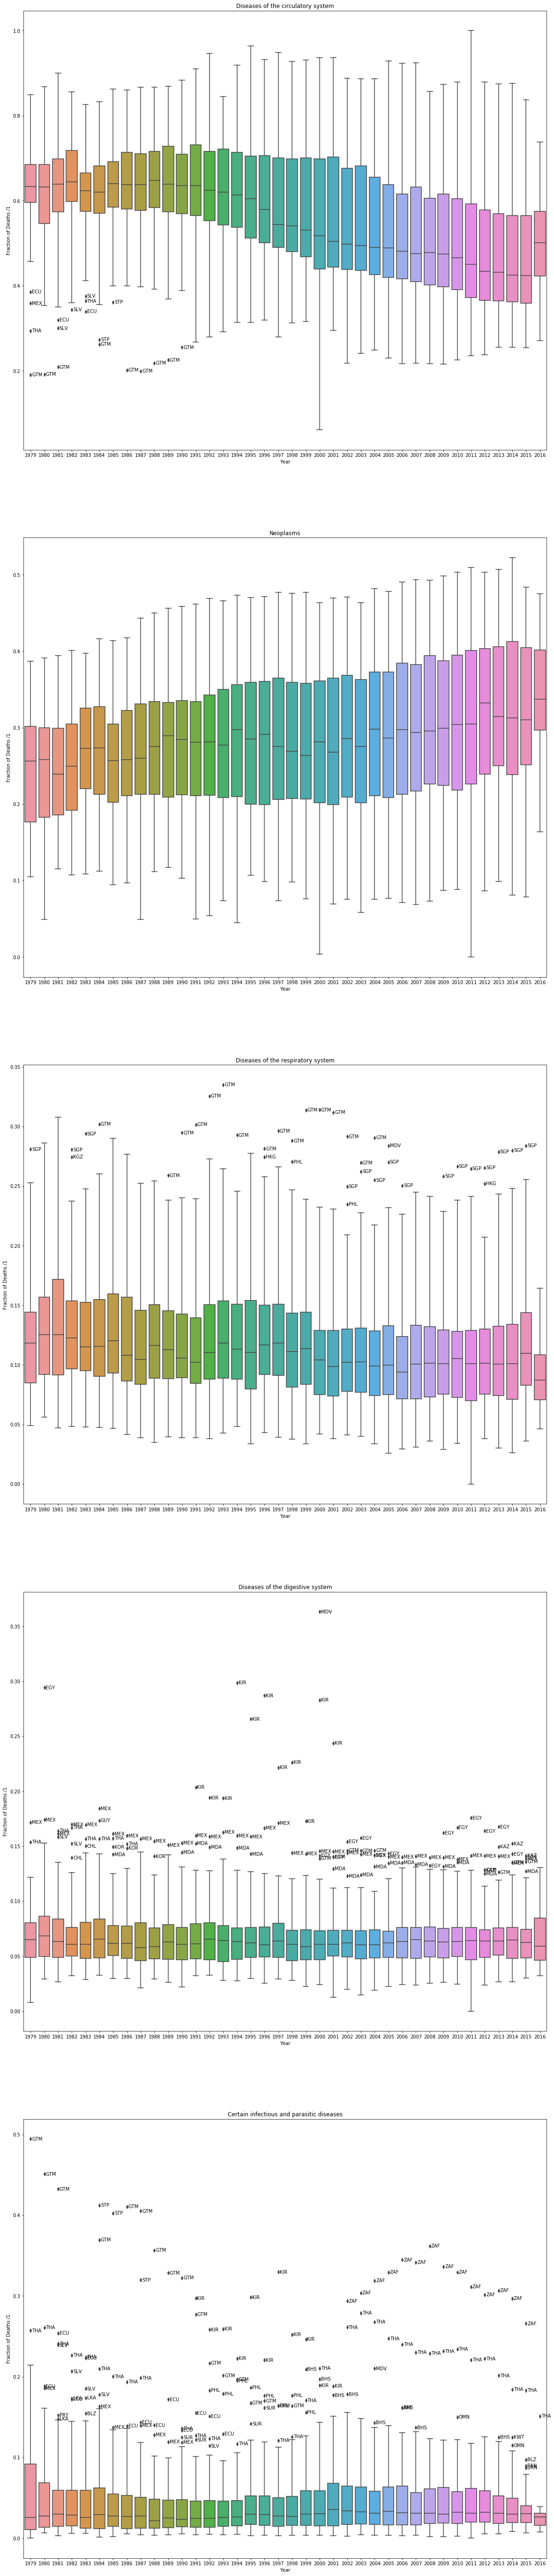

In [36]:
fig, axs = plt.subplots(len(topCauses), figsize=(20, 100))
forBoxplotCondensed = forBoxplotCalibed[forBoxplotCalibed.Cause.isin(topCauses)]
for x in range(len(topCauses)):
    # Label outliers:
    # dptc stands for DeathsPerTopCause
    dptc = forBoxplotCondensed[forBoxplotCondensed.Cause == topCauses[x]]
    q1 = dptc.groupby(dptc.Year).quantile(0.25)["DeathsProp"].to_numpy()
    q3 = dptc.groupby(dptc.Year).quantile(0.75)["DeathsProp"].to_numpy()
    outlier_top_lim = q3 + 2 * (q3 - q1)
    outlier_bottom_lim = q1 - 2 * (q3 - q1)
    #     print(outlier_top_lim)
    for row in dptc.itertuples():
        year = int(row.Year) - 1979
        #         print(type(year), year)
        val = row.DeathsProp
        if val > outlier_top_lim[year] or val < outlier_bottom_lim[year]:
            axs[x].text(year + 0.1, val, row.CountryCode, ha="left", va="center")

    sns.boxplot(data=dptc, y="DeathsProp", x="Year", ax=axs[x], whis=2)
    axs[x].set_title(disease_codes.loc[topCauses[x], "name"])
    axs[x].set_ylabel("Fraction of Deaths /1")

Circulatory: Guatemala had notably lower proportion of deaths due to this cause prior to 1991.

Neoplasms: Quite a large IQR with few outliers, indicating that no matter how developed a country is, cancer will still take away roughly the same proportion of lives. However, it has been increasing in recent years, as evidenced by the choropleths as well.

Respiratory: Before 2006, Guatemala had exceptionally high proportion of deaths due to this cause. After 2006, Singapore took its position and has maintained this outlier status for the past 10 years. I think this may be due to the high number of smokers after Singapore's GDP per capita rose and people could afford cigarettes.

Digestive: Egypt, North Macedonia and Mexico have all had high proportions of deaths due to this cause, with the latter 2's outlier status persevering from the 1980s until now. Kiribati also experienced a spike in this statistic in the 1990s. Perhaps it is due to the ulcer-inducing spicy food found in the borders of these countries.

Infectious and Parasitic: Guatemala and Kiribati have had notably higher proportions of death due to this cause from the 1980s to the 1990s. In recent years, Thailand and South Africa have dominated the charts, both being significantly outside of the range of 2 IQR. These countries have quite a bit of inequality (e.g. South Africa had apartheid) when it comes to urbanisation, so that may be why.

### 2. How does the average BMI correlate with the causes of mortality at any point in time?
<a id='bmiVsMortality'/>

#### Result
<a id='result2'>

As BMI increases, the death rate for most causes of death decreases. This is probably because BMI only increases when a country becomes more developed and people can eat more nutritious meals.

The only exceptions are nervous system and behavioural disorders, which are positively correlated with BMI. I will give further explanation below.

On a country level, Russia appears to be an exception as it's number of deaths due to digestive system illnesses is also positively correlated with BMI.

#### EDA
<a id='eda2'>

<a id='correl2'>
    <h5> Correlation and Regplots</h5>
</a>
Let us find out which causes of death are most correlated with BMI through correlation values and regplots.


In [37]:
bmiMort = pd.merge(
    longmdf, longbmidf, on=["CountryCode", "Country", "Year"], how="inner"
)
_bmiMort = pd.merge(longmdf, longbmidf, on=["CountryCode", "Year"], how="inner")
bmiMort.DeathsPer100k = bmiMort.DeathsPer100k.astype(float)
display(bmiMort)
display(_bmiMort)

CountryCode                            Country  Cause  \
0             ALB                            Albania      1   
1             ALB                            Albania      2   
2             ALB                            Albania      5   
3             ALB                            Albania      6   
4             ALB                            Albania      7   
...           ...                                ...    ...   
60985         VEN  Venezuela, Bolivarian Republic of     12   
60986         VEN  Venezuela, Bolivarian Republic of     13   
60987         VEN  Venezuela, Bolivarian Republic of     14   
60988         VEN  Venezuela, Bolivarian Republic of     15   
60989         VEN  Venezuela, Bolivarian Republic of     16   

                                               CauseName  Year  DeathsPer100k  \
0              Certain infectious and parasitic diseases  1979            NaN   
1                                              Neoplasms  1979            NaN   
2                       Mental and behavioural disorders  1979            NaN   
3                         Diseases of the nervous system  1979            NaN   
4                         Diseases of the eye and adnexa  1979            NaN   
...                                                  ...   ...            ...   
60985       Diseases of the skin and subcutaneous tissue  2016            NaN   
60986  Diseases of the musculoskeletal system and con...  2016            NaN   
60987               Diseases of the genitourinary system  2016            NaN   
60988           Pregnancy, childbirth and the puerperium  2016            NaN   
60989  Congenital malformations, deformations and chr...  2016            NaN   

        BMI  
0      24.0  
1      24.0  
2      24.0  
3      24.0  
4      24.0  
...     ...  
60985  26.7  
60986  26.7  
60987  26.7  
60988  26.7  
60989  26.7  

[60990 rows x 7 columns]

CountryCode                          Country_x  Cause  \
0             ALB                            Albania      1   
1             ALB                            Albania      2   
2             ALB                            Albania      5   
3             ALB                            Albania      6   
4             ALB                            Albania      7   
...           ...                                ...    ...   
60985         VEN  Venezuela, Bolivarian Republic of     12   
60986         VEN  Venezuela, Bolivarian Republic of     13   
60987         VEN  Venezuela, Bolivarian Republic of     14   
60988         VEN  Venezuela, Bolivarian Republic of     15   
60989         VEN  Venezuela, Bolivarian Republic of     16   

                                               CauseName  Year DeathsPer100k  \
0              Certain infectious and parasitic diseases  1979           NaN   
1                                              Neoplasms  1979           NaN   
2                       Mental and behavioural disorders  1979           NaN   
3                         Diseases of the nervous system  1979           NaN   
4                         Diseases of the eye and adnexa  1979           NaN   
...                                                  ...   ...           ...   
60985       Diseases of the skin and subcutaneous tissue  2016           NaN   
60986  Diseases of the musculoskeletal system and con...  2016           NaN   
60987               Diseases of the genitourinary system  2016           NaN   
60988           Pregnancy, childbirth and the puerperium  2016           NaN   
60989  Congenital malformations, deformations and chr...  2016           NaN   

                               Country_y   BMI  
0                                Albania  24.0  
1                                Albania  24.0  
2                                Albania  24.0  
3                                Albania  24.0  
4                                Albania  24.0  
...                                  ...   ...  
60985  Venezuela, Bolivarian Republic of  26.7  
60986  Venezuela, Bolivarian Republic of  26.7  
60987  Venezuela, Bolivarian Republic of  26.7  
60988  Venezuela, Bolivarian Republic of  26.7  
60989  Venezuela, Bolivarian Republic of  26.7  

[60990 rows x 8 columns]

Notice how the number of rows is the same whether `Country` is include in the `on` parameter. This shows that the mapping between `Country` and `CountryCode` is 1-to-1.

We shall now proceed to plot `regplot`s of every countries data throughout the years. We will be removing the outliers (defined arbitrarily based on quantile). If you decrease the quantile range, you would see that the number of data points remaining is decreased, which shows that the code is correct.

CountryCode                            Country  Cause  \
0             ALB                            Albania      1   
1             ALB                            Albania      2   
2             ALB                            Albania      5   
3             ALB                            Albania      6   
4             ALB                            Albania      7   
...           ...                                ...    ...   
60985         VEN  Venezuela, Bolivarian Republic of     12   
60986         VEN  Venezuela, Bolivarian Republic of     13   
60987         VEN  Venezuela, Bolivarian Republic of     14   
60988         VEN  Venezuela, Bolivarian Republic of     15   
60989         VEN  Venezuela, Bolivarian Republic of     16   

                                               CauseName  Year  DeathsPer100k  \
0              Certain infectious and parasitic diseases  1979            NaN   
1                                              Neoplasms  1979            NaN   
2                       Mental and behavioural disorders  1979            NaN   
3                         Diseases of the nervous system  1979            NaN   
4                         Diseases of the eye and adnexa  1979            NaN   
...                                                  ...   ...            ...   
60985       Diseases of the skin and subcutaneous tissue  2016            NaN   
60986  Diseases of the musculoskeletal system and con...  2016            NaN   
60987               Diseases of the genitourinary system  2016            NaN   
60988           Pregnancy, childbirth and the puerperium  2016            NaN   
60989  Congenital malformations, deformations and chr...  2016            NaN   

        BMI  
0      24.0  
1      24.0  
2      24.0  
3      24.0  
4      24.0  
...     ...  
60985  26.7  
60986  26.7  
60987  26.7  
60988  26.7  
60989  26.7  

[60990 rows x 7 columns]

CountryCode        Country  Cause  \
30            ARG      Argentina      1   
31            ARG      Argentina      2   
34            ARG      Argentina      5   
35            ARG      Argentina      6   
36            ARG      Argentina      7   
...           ...            ...    ...   
60889         USA  United States     12   
60890         USA  United States     13   
60891         USA  United States     14   
60892         USA  United States     15   
60893         USA  United States     16   

                                               CauseName  Year  DeathsPer100k  \
30             Certain infectious and parasitic diseases  1979           29.8   
31                                             Neoplasms  1979          155.2   
34                      Mental and behavioural disorders  1979            3.6   
35                        Diseases of the nervous system  1979            9.9   
36                        Diseases of the eye and adnexa  1979            0.0   
...                                                  ...   ...            ...   
60889       Diseases of the skin and subcutaneous tissue  2016            0.8   
60890  Diseases of the musculoskeletal system and con...  2016            2.4   
60891               Diseases of the genitourinary system  2016           11.1   
60892           Pregnancy, childbirth and the puerperium  2016            0.8   
60893  Congenital malformations, deformations and chr...  2016            3.7   

        BMI  
30     24.4  
31     24.4  
34     24.4  
35     24.4  
36     24.4  
...     ...  
60889  28.9  
60890  28.9  
60891  28.9  
60892  28.9  
60893  28.9  

[37897 rows x 7 columns]

CountryCode               Country  Cause  \
0             ARG             Argentina      1   
1             AUS             Australia      1   
2             BRB              Barbados      1   
3             BEL               Belgium      1   
4             CUB                  Cuba      1   
...           ...                   ...    ...   
37892         MDA  Moldova, Republic of      4   
37893         ROU               Romania      4   
37894         SWE                Sweden      4   
37895         THA              Thailand      4   
37896         USA         United States      4   

                                           CauseName  Year  DeathsPer100k  \
0          Certain infectious and parasitic diseases  1979           29.8   
1          Certain infectious and parasitic diseases  1979            3.4   
2          Certain infectious and parasitic diseases  1979           17.8   
3          Certain infectious and parasitic diseases  1979            5.4   
4          Certain infectious and parasitic diseases  1979           11.9   
...                                              ...   ...            ...   
37892  Endocrine, nutritional and metabolic diseases  2016            8.7   
37893  Endocrine, nutritional and metabolic diseases  2016            7.3   
37894  Endocrine, nutritional and metabolic diseases  2016           10.5   
37895  Endocrine, nutritional and metabolic diseases  2016           18.9   
37896  Endocrine, nutritional and metabolic diseases  2016           21.5   

        BMI    Correl        pValue  
0      24.4 -0.127130  1.409419e-10  
1      24.2 -0.127130  1.409419e-10  
2      25.3 -0.127130  1.409419e-10  
3      24.9 -0.127130  1.409419e-10  
4      23.0 -0.127130  1.409419e-10  
...     ...       ...           ...  
37892  27.0  0.217845  1.302295e-15  
37893  26.9  0.217845  1.302295e-15  
37894  26.0  0.217845  1.302295e-15  
37895  24.4  0.217845  1.302295e-15  
37896  28.9  0.217845  1.302295e-15  

[37897 rows x 9 columns]

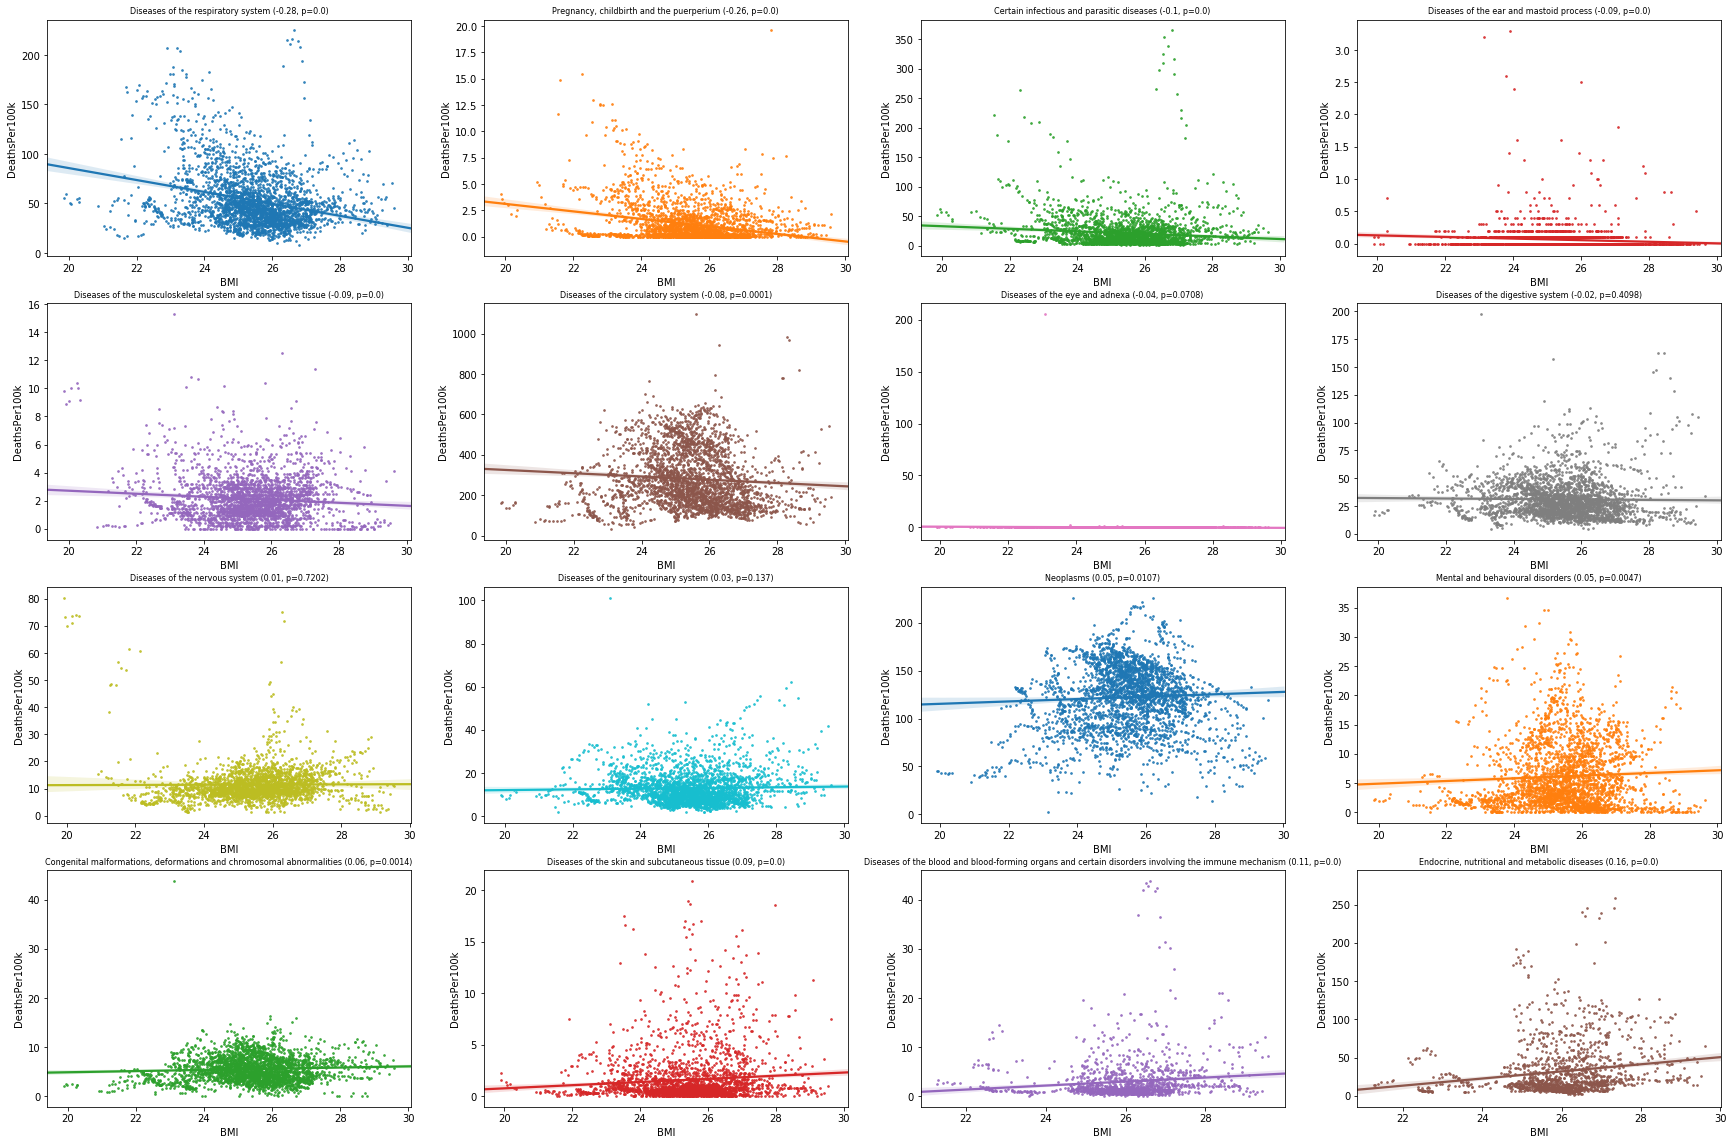

In [38]:
from scipy import stats
import math


def find_correl(df, a, b):
    dfnona = df.dropna()
    return stats.pearsonr(dfnona[a], dfnona[b])


# append correlation between two variables grouped by Cause
def append_correl(df, a1, b1):
    correls = df.groupby("Cause").apply(find_correl, a=a1, b=b1)
    diseases = df.Cause.unique()
    correldf = pd.DataFrame(
        [[a, correls[a][0], correls[a][1]] for a in diseases],
        columns=["Cause", "Correl", "pValue"],
    )
    return pd.merge(df, correldf, on="Cause")


def remove_outliers(df):
    outlier_boundaries = (
        df.groupby("Cause").DeathsPer100k.quantile([0.05, 0.95]).unstack(level=1)
    )
    nooutlier = df[
        (
            df.DeathsPer100k
            >= outlier_boundaries.iloc[df.Cause - 1, 0].reset_index(drop=True)
        )
        & (
            df.DeathsPer100k
            <= outlier_boundaries.iloc[df.Cause - 1, 1].reset_index(drop=True)
        )
    ]
    return nooutlier


# remove outliers + append_correl
display(bmiMort)
bmiMort_nooutlier = remove_outliers(bmiMort)
display(bmiMort_nooutlier)
bmiMort2 = append_correl(bmiMort_nooutlier.dropna(), "BMI", "DeathsPer100k")
display(bmiMort2)


def plot4x4reg(df, indepvar):
    # To make it work for other number of causes as well
    count = len(disease_codes)
    maxwidth = math.ceil(count**0.5)
    fig, axes = plt.subplots(maxwidth, maxwidth, figsize=(30, 20))
    diseases_sorted = df.sort_values(by="Correl").CauseName.unique()
    for ax, cause in zip(axes.ravel(), diseases_sorted):
        dfs = df.query("CauseName==@cause")
        sns.regplot(
            data=dfs,
            x=indepvar,
            y="DeathsPer100k",
            scatter_kws={"s": 3},
            x_jitter=0.05,
            ax=ax,
        ).set_title(
            cause + " (" + str(round(dfs.Correl.iloc[0], 2)) + ", p="
            # round p value to 3 d.p as anything less than 0.001 is statistically significant
            + str(round(dfs.pValue.iloc[0], 4)) + ")",
            fontsize=8,
        )


plot4x4reg(
    append_correl(bmiMort.dropna(), "BMI", "DeathsPer100k"), "BMI"
)  # with outliers

Now, without outliers the regplots are much tighter along the y-axis.

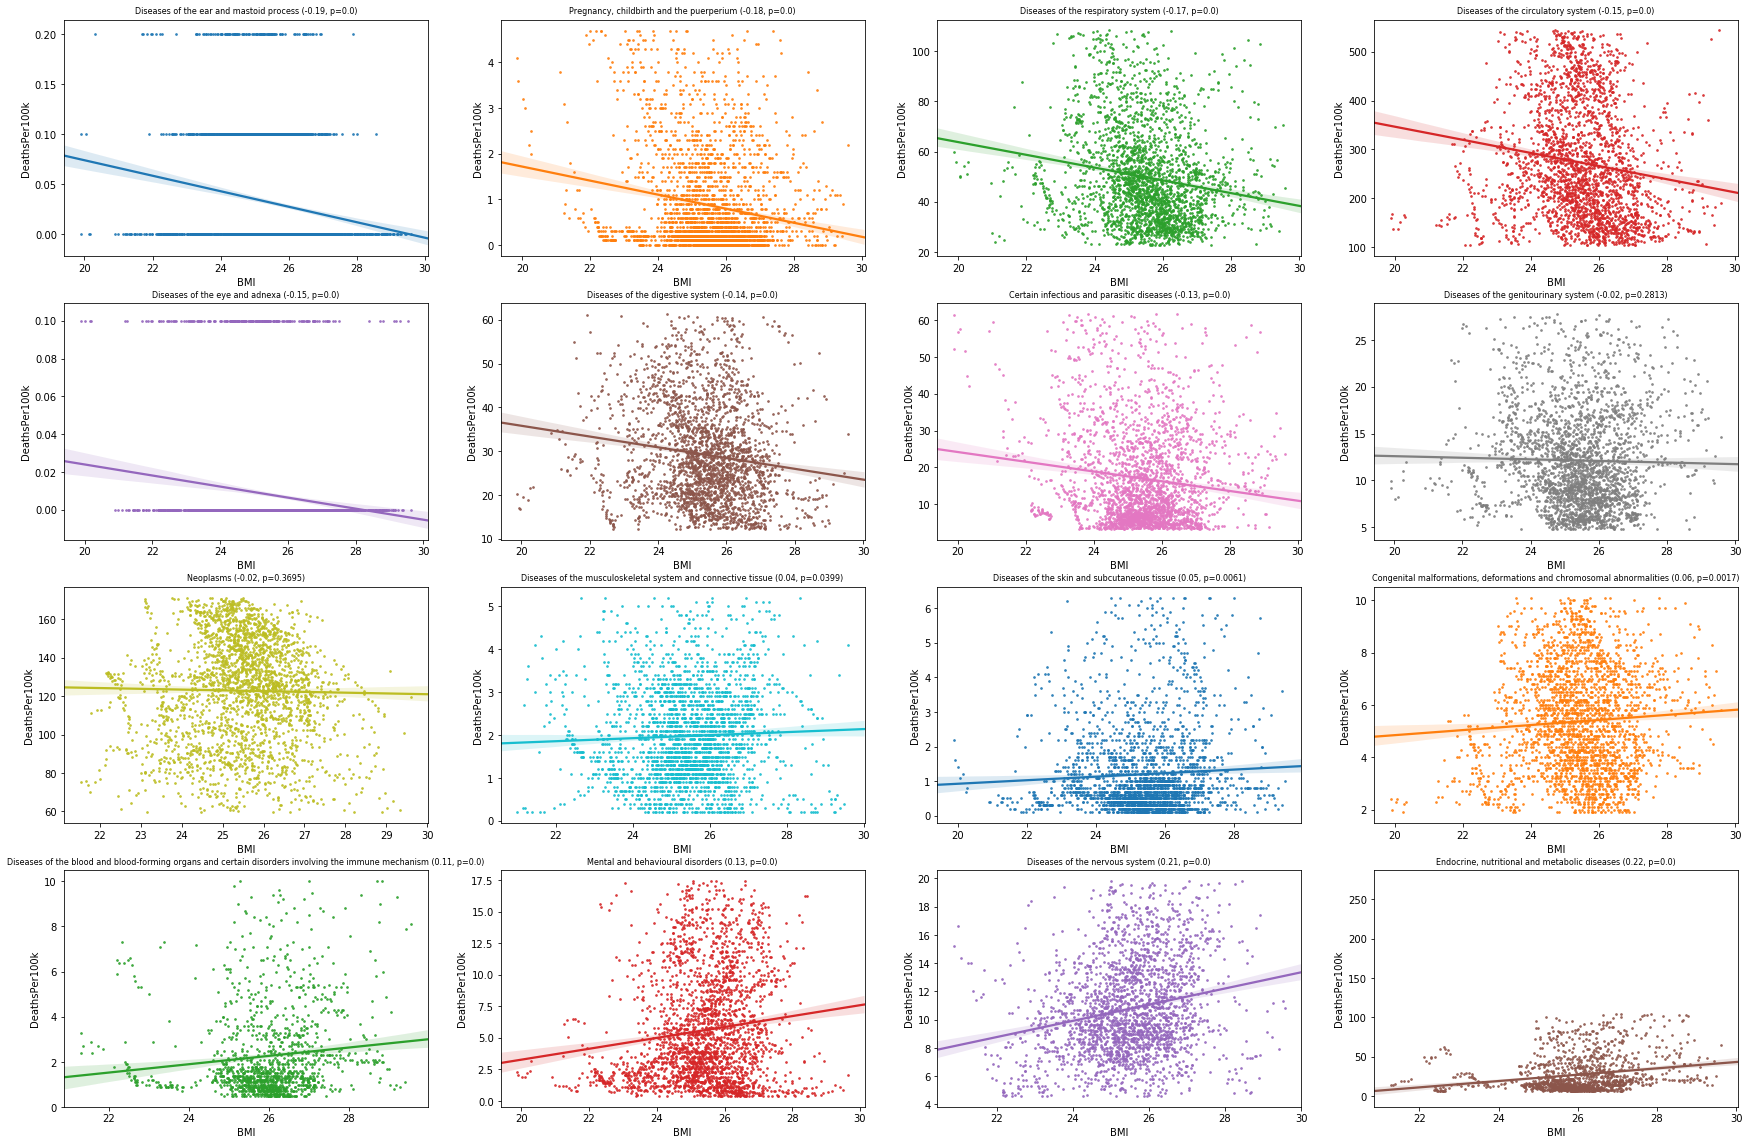

In [39]:
plot4x4reg(bmiMort2, "BMI")

As one can see, there is a huge amount of variability in the data (barring the `jitter` set in place to compensate for decimal point issues) so there is no strong correlation between death originating from major causes and BMI. However, what if we take the average of `DeathsPer100k` for every country per year. This would theoretically fix the massive amount of variation between the developed and developing countries at any point in time.

CountryCode               Country  Cause  \
0             ARG             Argentina      1   
1             AUS             Australia      1   
2             BRB              Barbados      1   
3             BEL               Belgium      1   
4             CUB                  Cuba      1   
...           ...                   ...    ...   
37892         MDA  Moldova, Republic of      4   
37893         ROU               Romania      4   
37894         SWE                Sweden      4   
37895         THA              Thailand      4   
37896         USA         United States      4   

                                           CauseName  Year  DeathsPer100k  \
0          Certain infectious and parasitic diseases  1979           29.8   
1          Certain infectious and parasitic diseases  1979            3.4   
2          Certain infectious and parasitic diseases  1979           17.8   
3          Certain infectious and parasitic diseases  1979            5.4   
4          Certain infectious and parasitic diseases  1979           11.9   
...                                              ...   ...            ...   
37892  Endocrine, nutritional and metabolic diseases  2016            8.7   
37893  Endocrine, nutritional and metabolic diseases  2016            7.3   
37894  Endocrine, nutritional and metabolic diseases  2016           10.5   
37895  Endocrine, nutritional and metabolic diseases  2016           18.9   
37896  Endocrine, nutritional and metabolic diseases  2016           21.5   

        BMI    Correl        pValue  
0      24.4 -0.127130  1.409419e-10  
1      24.2 -0.127130  1.409419e-10  
2      25.3 -0.127130  1.409419e-10  
3      24.9 -0.127130  1.409419e-10  
4      23.0 -0.127130  1.409419e-10  
...     ...       ...           ...  
37892  27.0  0.217845  1.302295e-15  
37893  26.9  0.217845  1.302295e-15  
37894  26.0  0.217845  1.302295e-15  
37895  24.4  0.217845  1.302295e-15  
37896  28.9  0.217845  1.302295e-15  

[37897 rows x 9 columns]

Year  Cause                                      CauseName  \
0    1979      1      Certain infectious and parasitic diseases   
1    1980      1      Certain infectious and parasitic diseases   
2    1981      1      Certain infectious and parasitic diseases   
3    1982      1      Certain infectious and parasitic diseases   
4    1983      1      Certain infectious and parasitic diseases   
..    ...    ...                                            ...   
573  2012      4  Endocrine, nutritional and metabolic diseases   
574  2013      4  Endocrine, nutritional and metabolic diseases   
575  2014      4  Endocrine, nutritional and metabolic diseases   
576  2015      4  Endocrine, nutritional and metabolic diseases   
577  2016      4  Endocrine, nutritional and metabolic diseases   

     DeathsPer100k        BMI    Correl        pValue  
0        20.114815  24.118519 -0.763811  2.425297e-08  
1        21.067442  24.151163 -0.763811  2.425297e-08  
2        21.580000  24.167273 -0.763811  2.425297e-08  
3        20.972222  24.283333 -0.763811  2.425297e-08  
4        18.088372  24.306977 -0.763811  2.425297e-08  
..             ...        ...       ...           ...  
573      27.324324  26.578378  0.309181  1.511319e-01  
574      26.913889  26.665278  0.309181  1.511319e-01  
575      26.654286  26.652857  0.309181  1.511319e-01  
576      23.430189  26.664151  0.309181  1.511319e-01  
577      16.120000  26.726667  0.309181  1.511319e-01  

[578 rows x 7 columns]

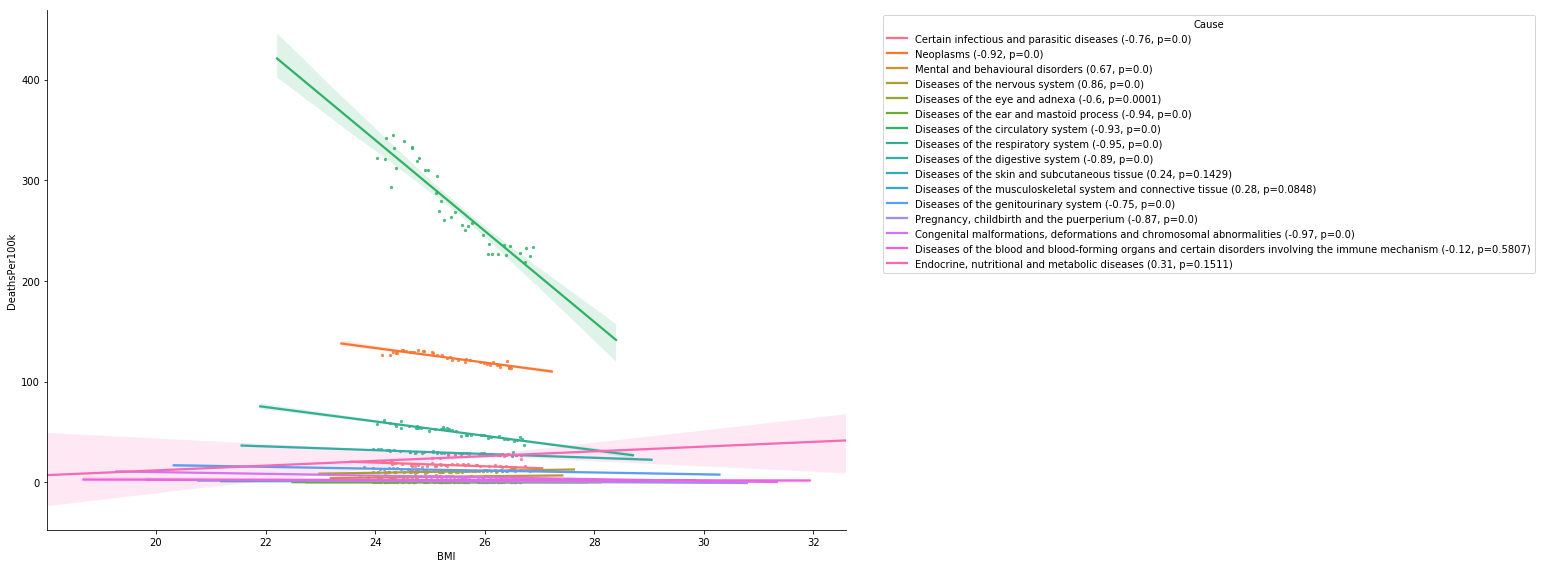

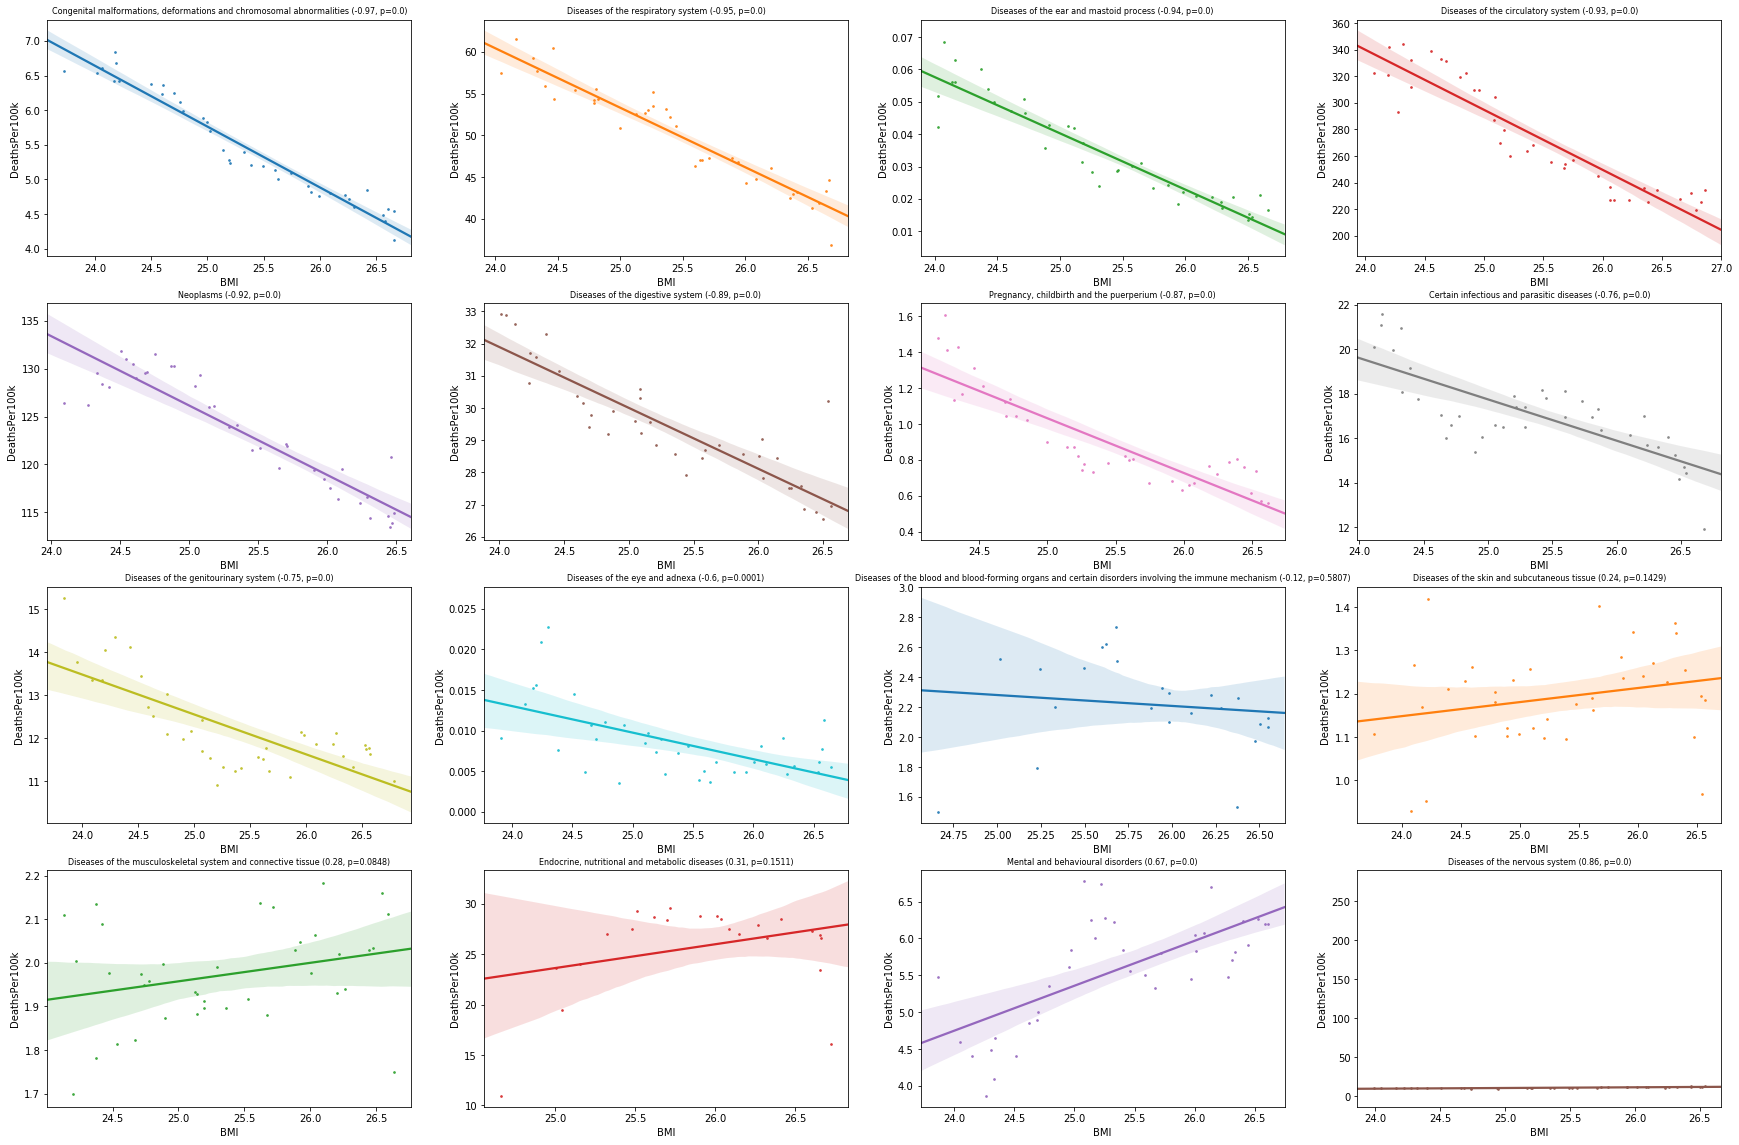

In [40]:
def get_mean_deaths(df, indepvar):
    meanDeaths = df.groupby(["Year", "Cause", "CauseName"]).agg(
        {"DeathsPer100k": ["mean"], indepvar: ["mean"]}
    )
    meanDeaths.reset_index(inplace=True)
    meanDeaths.columns = meanDeaths.columns.droplevel(1)
    return meanDeaths


def reg_mean_deaths(df, indepvar):
    meanDeaths = get_mean_deaths(df, indepvar)
    meanDeaths = append_correl(meanDeaths, indepvar, "DeathsPer100k")
    display(meanDeaths)

    sns.color_palette("bright")
    sns.lmplot(
        data=meanDeaths,
        x=indepvar,
        y="DeathsPer100k",
        hue="CauseName",
        scatter_kws={"s": 5},
        height=8,
        aspect=1.5,
        legend=False,
    )
    legend = (
        meanDeaths.CauseName
        + " ("
        + meanDeaths.Correl.round(2).astype(str)
        + ", p="
        + meanDeaths.pValue.round(4).astype(str)
        + ")"
    ).unique()
    plt.legend(title="Cause", bbox_to_anchor=(1.04, 1), loc="upper left", labels=legend)

    plot4x4reg(meanDeaths, indepvar)


display(bmiMort2)
reg_mean_deaths(bmiMort2, "BMI")

As one can see, the gradient of the regression lines (i.e. whether they are increasing or decreasing) are in line with the correlation values in the legend. This shows that this plot is correct. 

Analysis: One would expect that as BMI increases, deaths due to cardiovascular reasons would increase. However this is not the case. There is a very strong *negative* correlation (c=-0.93) between BMI and circulatory system diseases. The same is observed for many other causes of death. I think this is because a country with high BMI is a country that can cater to the nutritional needs of its citizens very well, so it is developed and healthcare standards should be high as well, and deaths due to various illnesses decrease. The only cause that shows a strong positive correlation with BMI is mental and behavioural disorders. Perhaps this is due to the same reason as the choropleth maps above. I.e., in developed countries, people with mental illnesses actually survive long enough to be considered a valid data point.

Let us now try to narrow it down to any particular country. We will keep the outliers in for this one as while the deaths figures may be outliers on the global scale, on a country-by-country basis they could still be statistically significant. NOTE: I will only be drawing conclusions from "important" countries such as the United States, but this model can be used for any country with data.

Enter alpha-3 country code: usa
United States


CountryCode        Country Cause                           CauseName  \
189         USA  United States     9  Diseases of the circulatory system   
161         USA  United States     9  Diseases of the circulatory system   
168         USA  United States     9  Diseases of the circulatory system   
167         USA  United States     9  Diseases of the circulatory system   
166         USA  United States     9  Diseases of the circulatory system   
..          ...            ...   ...                                 ...   
103         USA  United States     5    Mental and behavioural disorders   
102         USA  United States     5    Mental and behavioural disorders   
101         USA  United States     5    Mental and behavioural disorders   
100         USA  United States     5    Mental and behavioural disorders   
78          USA  United States     5    Mental and behavioural disorders   

     Year  DeathsPer100k   BMI    Correl        pValue  
189  2016          131.8  28.9 -0.993215  3.041203e-35  
161  1988          266.8  26.0 -0.993215  3.041203e-35  
168  1995          226.7  26.9 -0.993215  3.041203e-35  
167  1994          228.8  26.7 -0.993215  3.041203e-35  
166  1993          235.2  26.6 -0.993215  3.041203e-35  
..    ...            ...   ...       ...           ...  
103  2006           14.7  28.2  0.921908  2.129032e-16  
102  2005           12.1  28.1  0.921908  2.129032e-16  
101  2004           10.9  28.0  0.921908  2.129032e-16  
100  2003           10.8  27.9  0.921908  2.129032e-16  
78   1981            5.2  25.3  0.921908  2.129032e-16  

[152 rows x 9 columns]

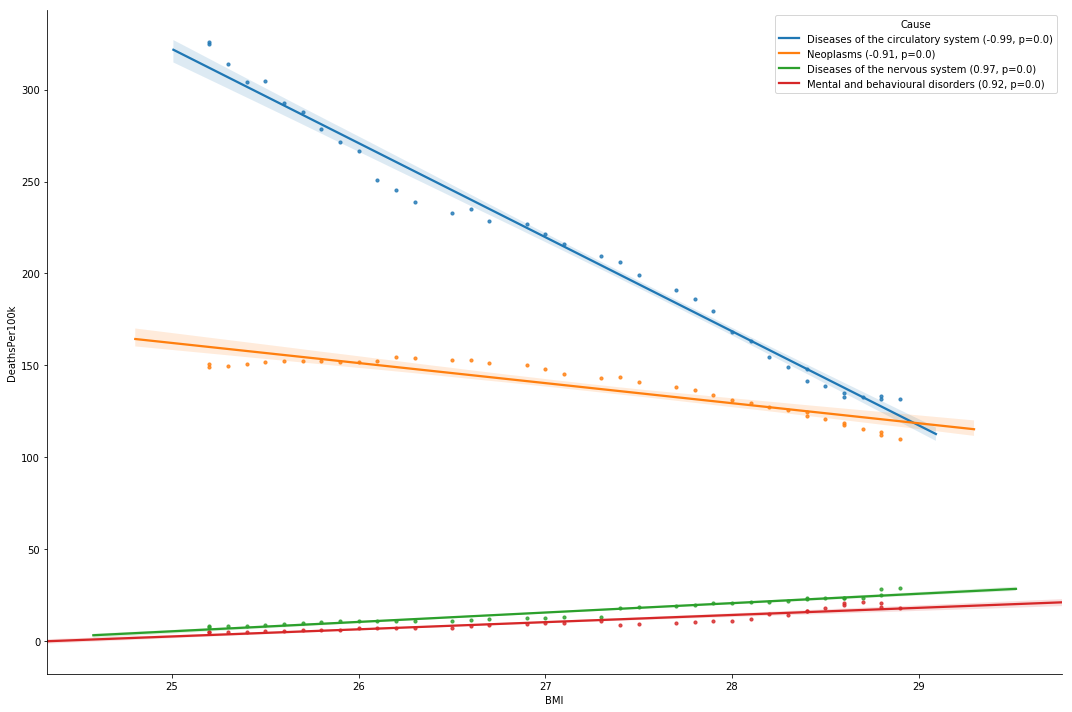

Enter alpha-3 country code: gbr
United Kingdom


CountryCode         Country Cause                           CauseName  \
112         GBR  United Kingdom     9  Diseases of the circulatory system   
138         GBR  United Kingdom     9  Diseases of the circulatory system   
131         GBR  United Kingdom     9  Diseases of the circulatory system   
132         GBR  United Kingdom     9  Diseases of the circulatory system   
133         GBR  United Kingdom     9  Diseases of the circulatory system   
..          ...             ...   ...                                 ...   
60          GBR  United Kingdom     5    Mental and behavioural disorders   
59          GBR  United Kingdom     5    Mental and behavioural disorders   
58          GBR  United Kingdom     5    Mental and behavioural disorders   
57          GBR  United Kingdom     5    Mental and behavioural disorders   
72          GBR  United Kingdom     5    Mental and behavioural disorders   

     Year  DeathsPer100k   BMI    Correl        pValue  
112  1980          361.3  24.1 -0.992869  6.316933e-34  
138  2006          146.5  26.8 -0.992869  6.316933e-34  
131  1999          205.2  26.2 -0.992869  6.316933e-34  
132  2000          191.3  26.3 -0.992869  6.316933e-34  
133  2001          191.5  26.4 -0.992869  6.316933e-34  
..    ...            ...   ...       ...           ...  
60   2002           13.0  26.5  0.730282  2.894156e-07  
59   2001           13.0  26.4  0.730282  2.894156e-07  
58   2000           10.6  26.3  0.730282  2.894156e-07  
57   1999           10.7  26.2  0.730282  2.894156e-07  
72   2014           23.4  27.1  0.730282  2.894156e-07  

[185 rows x 9 columns]

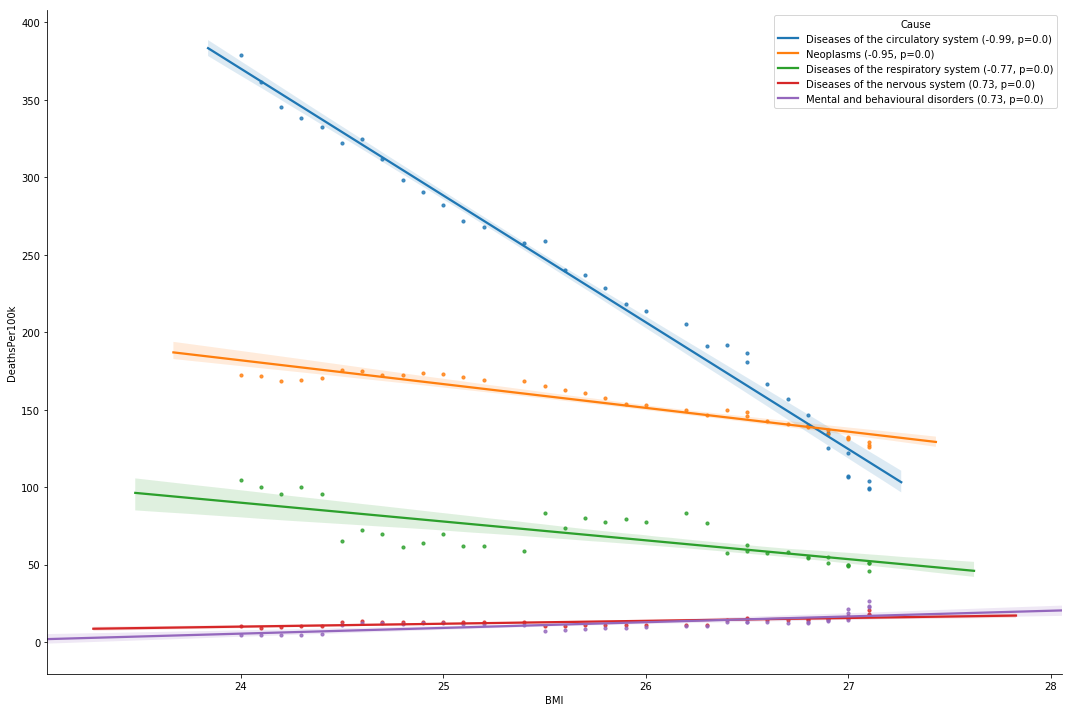

Enter alpha-3 country code: rus
Russian Federation


CountryCode             Country Cause                       CauseName  \
54         RUS  Russian Federation     2                       Neoplasms   
44         RUS  Russian Federation     2                       Neoplasms   
50         RUS  Russian Federation     2                       Neoplasms   
49         RUS  Russian Federation     2                       Neoplasms   
48         RUS  Russian Federation     2                       Neoplasms   
..         ...                 ...   ...                             ...   
83         RUS  Russian Federation     6  Diseases of the nervous system   
84         RUS  Russian Federation     6  Diseases of the nervous system   
85         RUS  Russian Federation     6  Diseases of the nervous system   
86         RUS  Russian Federation     6  Diseases of the nervous system   
80         RUS  Russian Federation     6  Diseases of the nervous system   

    Year  DeathsPer100k   BMI    Correl        pValue  
54  1998          151.7  25.7 -0.768837  4.329938e-08  
44  1988          156.0  25.5 -0.768837  4.329938e-08  
50  1994          161.8  25.6 -0.768837  4.329938e-08  
49  1993          162.9  25.6 -0.768837  4.329938e-08  
48  1992          160.9  25.6 -0.768837  4.329938e-08  
..   ...            ...   ...       ...           ...  
83  2010           10.2  26.1  0.538560  2.571789e-02  
84  2011           10.1  26.1  0.538560  2.571789e-02  
85  2012            9.7  26.1  0.538560  2.571789e-02  
86  2013           11.3  26.2  0.538560  2.571789e-02  
80  2007            8.6  26.0  0.538560  2.571789e-02  

[161 rows x 9 columns]

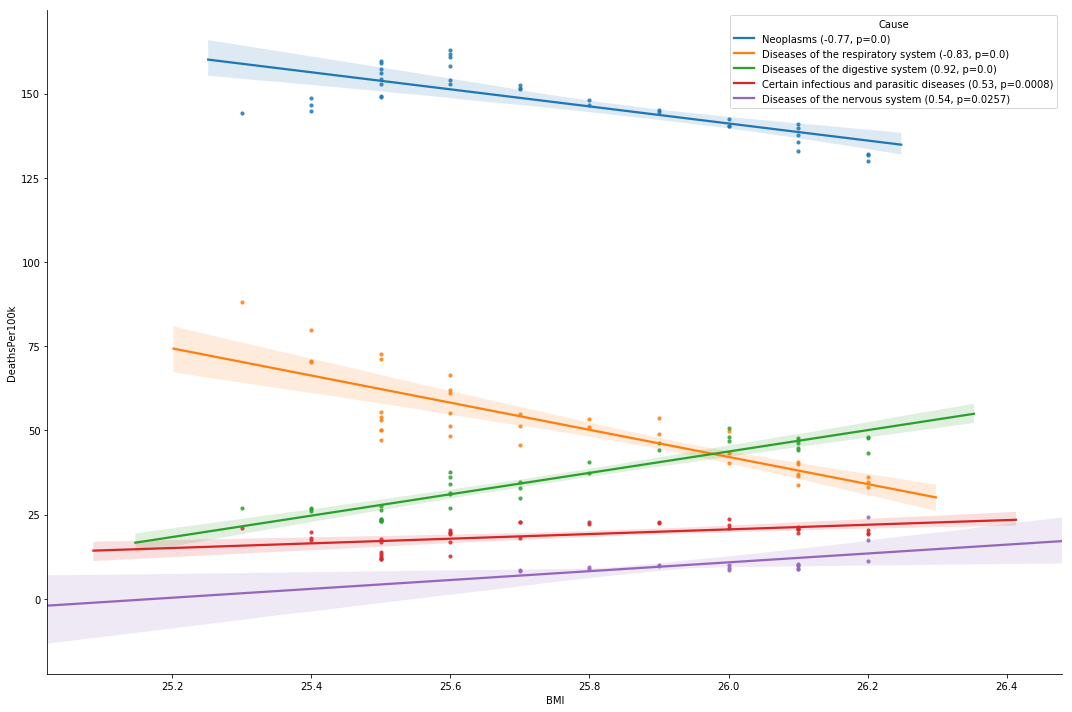

Enter alpha-3 country code: bra
Brazil


CountryCode Country Cause                                  CauseName  \
110         BRA  Brazil     9         Diseases of the circulatory system   
82          BRA  Brazil     9         Diseases of the circulatory system   
90          BRA  Brazil     9         Diseases of the circulatory system   
89          BRA  Brazil     9         Diseases of the circulatory system   
88          BRA  Brazil     9         Diseases of the circulatory system   
..          ...     ...   ...                                        ...   
24          BRA  Brazil     1  Certain infectious and parasitic diseases   
23          BRA  Brazil     1  Certain infectious and parasitic diseases   
22          BRA  Brazil     1  Certain infectious and parasitic diseases   
21          BRA  Brazil     1  Certain infectious and parasitic diseases   
0           BRA  Brazil     1  Certain infectious and parasitic diseases   

     Year  DeathsPer100k   BMI    Correl        pValue  
110  2015          167.5  26.5 -0.900032  3.513113e-14  
82   1987          237.9  23.7 -0.900032  3.513113e-14  
90   1995          285.7  24.4 -0.900032  3.513113e-14  
89   1994          292.0  24.3 -0.900032  3.513113e-14  
88   1993          299.4  24.2 -0.900032  3.513113e-14  
..    ...            ...   ...       ...           ...  
24   2003           31.5  25.1 -0.862668  6.689014e-12  
23   2002           31.1  25.0 -0.862668  6.689014e-12  
22   2001           31.7  24.9 -0.862668  6.689014e-12  
21   2000           32.0  24.8 -0.862668  6.689014e-12  
0    1979           62.6  23.0 -0.862668  6.689014e-12  

[111 rows x 9 columns]

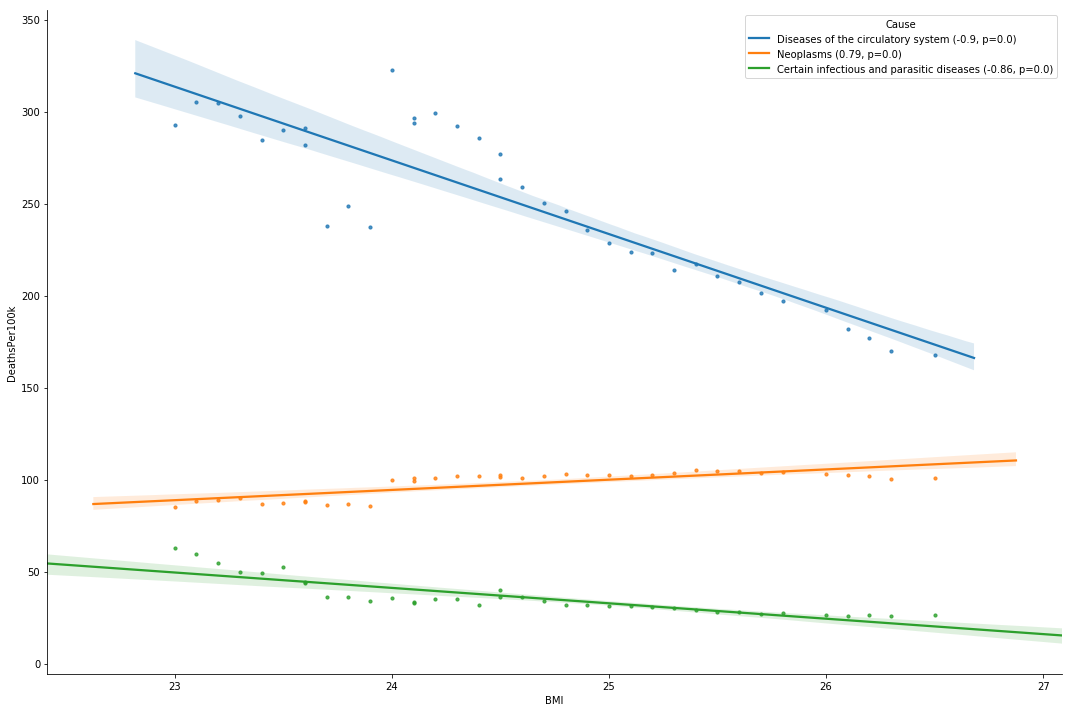

Enter alpha-3 country code: stop


In [41]:
def reg_per_country(df, indepvar):
    inp = ""
    while inp.lower() != "stop":
        inp = input("Enter alpha-3 country code: ").upper()
        if inp in df.CountryCode.values:
            country = df[df.CountryCode == inp]
            print(country.Country.iloc[0])

            # Plot only causes that have a variety of number of deaths.
            gbCause = country.groupby("Cause")
            largeDiff = gbCause.DeathsPer100k.max() - gbCause.DeathsPer100k.min() > 10
            country = country[largeDiff[country.Cause].values]
            country.drop(
                ["Correl", "pValue"], axis=1, inplace=True
            )  # recalculate correlation

            country = append_correl(country, indepvar, "DeathsPer100k")
            toPlot = country[
                # Ensure correlation is strong and valid
                (abs(country.Correl) >= 0.5)
                & (country.pValue <= 0.05)
            ]

            # Sort by sum of deaths to make the line colors a bit more in sync for easier cross-referencing.
            longmdf.DeathsPer100k = longmdf.DeathsPer100k.astype(float)
            sort_by_this = (
                longmdf.groupby("Cause").DeathsPer100k.sum().sort_values().index
            )
            toPlot.Cause = toPlot.Cause.astype("category")
            toPlot.Cause.cat.set_categories(sort_by_this, inplace=True)
            toPlot.sort_values(["Cause"], inplace=True, ascending=False)
            display(toPlot)

            plot = sns.lmplot(
                data=toPlot,
                x=indepvar,
                y="DeathsPer100k",
                hue="CauseName",
                scatter_kws={"s": 10},
                height=10,
                aspect=1.5,
                legend=False,
            )
            legend = (
                toPlot.CauseName
                + " ("
                + toPlot.Correl.round(2).astype(str)
                + ", p="
                + toPlot.pValue.round(4).astype(str)
                + ")"
            ).unique()
            plt.legend(title="Cause", loc="upper right", labels=legend)
            plt.show(plot)


reg_per_country(append_correl(bmiMort, "BMI", "DeathsPer100k").dropna(), "BMI")

United States: Nervous system illnesses and mental disorders are related, and they are both positively correlated with BMI. The only explanation I can think of is the one previously mentioned. U.S.'s data is in accordance with the rest of the world.

Russia: The main thing to note here is the strong positive correlation between digestive system diseases and BMI. Perhaps the Russians' diet is quite unhealthy, so as they consume more nutrition, their risk of digestive system illness also increase.

United Kingdom: Similar to U.S., except there is also a negative correlation bewtween respiratory system illnesses and BMI. Perhaps as the U.K. became more developed, people gained the awareness to smoke less and environmental standards went up as well, reducing the number of deaths due to this cause.

Brazil: Nothing out of the ordinary. Developing countries are not that different from developed countries in terms of this correlation.

### 3. How does the average Child Mortality Rate (CMR) correlate with the causes of mortality at any point in time?
<a id='cmrVsMortality'/>

#### Result
<a id='result3'>

As CMR increases, the death rate for most causes of death increases. This is probably because CMR is only high when a country has poor health infrastructure.

The only exceptions are nervous system and behavioural disorders, which are negatively correlated with CMR.

On a country level, Russia appears to be an exception as it's number of deaths due to digestive system illnesses is also negatively correlated with CMR.

#### EDA
<a id='eda3'>

In [42]:
cmrMort = pd.merge(
    longmdf, longcmrdf, on=["CountryCode", "Country", "Year"], how="inner"
)
_cmrMort = pd.merge(longmdf, longcmrdf, on=["CountryCode", "Year"], how="inner")
cmrMort.DeathsPer100k = cmrMort.DeathsPer100k.astype(float)
display(cmrMort)
display(_cmrMort)

CountryCode                            Country  Cause  \
0             ALB                            Albania      1   
1             ALB                            Albania      2   
2             ALB                            Albania      5   
3             ALB                            Albania      6   
4             ALB                            Albania      7   
...           ...                                ...    ...   
61593         VEN  Venezuela, Bolivarian Republic of     12   
61594         VEN  Venezuela, Bolivarian Republic of     13   
61595         VEN  Venezuela, Bolivarian Republic of     14   
61596         VEN  Venezuela, Bolivarian Republic of     15   
61597         VEN  Venezuela, Bolivarian Republic of     16   

                                               CauseName  Year  DeathsPer100k  \
0              Certain infectious and parasitic diseases  1979            NaN   
1                                              Neoplasms  1979            NaN   
2                       Mental and behavioural disorders  1979            NaN   
3                         Diseases of the nervous system  1979            NaN   
4                         Diseases of the eye and adnexa  1979            NaN   
...                                                  ...   ...            ...   
61593       Diseases of the skin and subcutaneous tissue  2016            NaN   
61594  Diseases of the musculoskeletal system and con...  2016            NaN   
61595               Diseases of the genitourinary system  2016            NaN   
61596           Pregnancy, childbirth and the puerperium  2016            NaN   
61597  Congenital malformations, deformations and chr...  2016            NaN   

             CMR  
0      71.181438  
1      71.181438  
2      71.181438  
3      71.181438  
4      71.181438  
...          ...  
61593  21.044404  
61594  21.044404  
61595  21.044404  
61596  21.044404  
61597  21.044404  

[61598 rows x 7 columns]

CountryCode                          Country_x  Cause  \
0             ALB                            Albania      1   
1             ALB                            Albania      2   
2             ALB                            Albania      5   
3             ALB                            Albania      6   
4             ALB                            Albania      7   
...           ...                                ...    ...   
61593         VEN  Venezuela, Bolivarian Republic of     12   
61594         VEN  Venezuela, Bolivarian Republic of     13   
61595         VEN  Venezuela, Bolivarian Republic of     14   
61596         VEN  Venezuela, Bolivarian Republic of     15   
61597         VEN  Venezuela, Bolivarian Republic of     16   

                                               CauseName  Year  DeathsPer100k  \
0              Certain infectious and parasitic diseases  1979            NaN   
1                                              Neoplasms  1979            NaN   
2                       Mental and behavioural disorders  1979            NaN   
3                         Diseases of the nervous system  1979            NaN   
4                         Diseases of the eye and adnexa  1979            NaN   
...                                                  ...   ...            ...   
61593       Diseases of the skin and subcutaneous tissue  2016            NaN   
61594  Diseases of the musculoskeletal system and con...  2016            NaN   
61595               Diseases of the genitourinary system  2016            NaN   
61596           Pregnancy, childbirth and the puerperium  2016            NaN   
61597  Congenital malformations, deformations and chr...  2016            NaN   

                               Country_y        CMR  
0                                Albania  71.181438  
1                                Albania  71.181438  
2                                Albania  71.181438  
3                                Albania  71.181438  
4                                Albania  71.181438  
...                                  ...        ...  
61593  Venezuela, Bolivarian Republic of  21.044404  
61594  Venezuela, Bolivarian Republic of  21.044404  
61595  Venezuela, Bolivarian Republic of  21.044404  
61596  Venezuela, Bolivarian Republic of  21.044404  
61597  Venezuela, Bolivarian Republic of  21.044404  

[61598 rows x 8 columns]

As per BMI, `cmrdf`'s `Country` column is also in accordance with that of `mdf`. Now, let's plot some regplots but without outliers.

CountryCode               Country  Cause  \
0             ARG             Argentina      1   
1             AUS             Australia      1   
2             BRB              Barbados      1   
3             BEL               Belgium      1   
4             CUB                  Cuba      1   
...           ...                   ...    ...   
37881         MDA  Moldova, Republic of      4   
37882         ROU               Romania      4   
37883         SWE                Sweden      4   
37884         THA              Thailand      4   
37885         USA         United States      4   

                                           CauseName  Year  DeathsPer100k  \
0          Certain infectious and parasitic diseases  1979           29.8   
1          Certain infectious and parasitic diseases  1979            3.4   
2          Certain infectious and parasitic diseases  1979           17.8   
3          Certain infectious and parasitic diseases  1979            5.4   
4          Certain infectious and parasitic diseases  1979           11.9   
...                                              ...   ...            ...   
37881  Endocrine, nutritional and metabolic diseases  2016            8.7   
37882  Endocrine, nutritional and metabolic diseases  2016            7.3   
37883  Endocrine, nutritional and metabolic diseases  2016           10.5   
37884  Endocrine, nutritional and metabolic diseases  2016           18.9   
37885  Endocrine, nutritional and metabolic diseases  2016           21.5   

             CMR    Correl         pValue  
0      40.094603  0.620171  2.058840e-268  
1      11.297138  0.620171  2.058840e-268  
2      24.888679  0.620171  2.058840e-268  
3      12.876635  0.620171  2.058840e-268  
4      19.279995  0.620171  2.058840e-268  
...          ...       ...            ...  
37881  13.149784  0.385809   4.247712e-48  
37882   7.112852  0.385809   4.247712e-48  
37883   2.287122  0.385809   4.247712e-48  
37884   8.854661  0.385809   4.247712e-48  
37885   5.764999  0.385809   4.247712e-48  

[37886 rows x 9 columns]

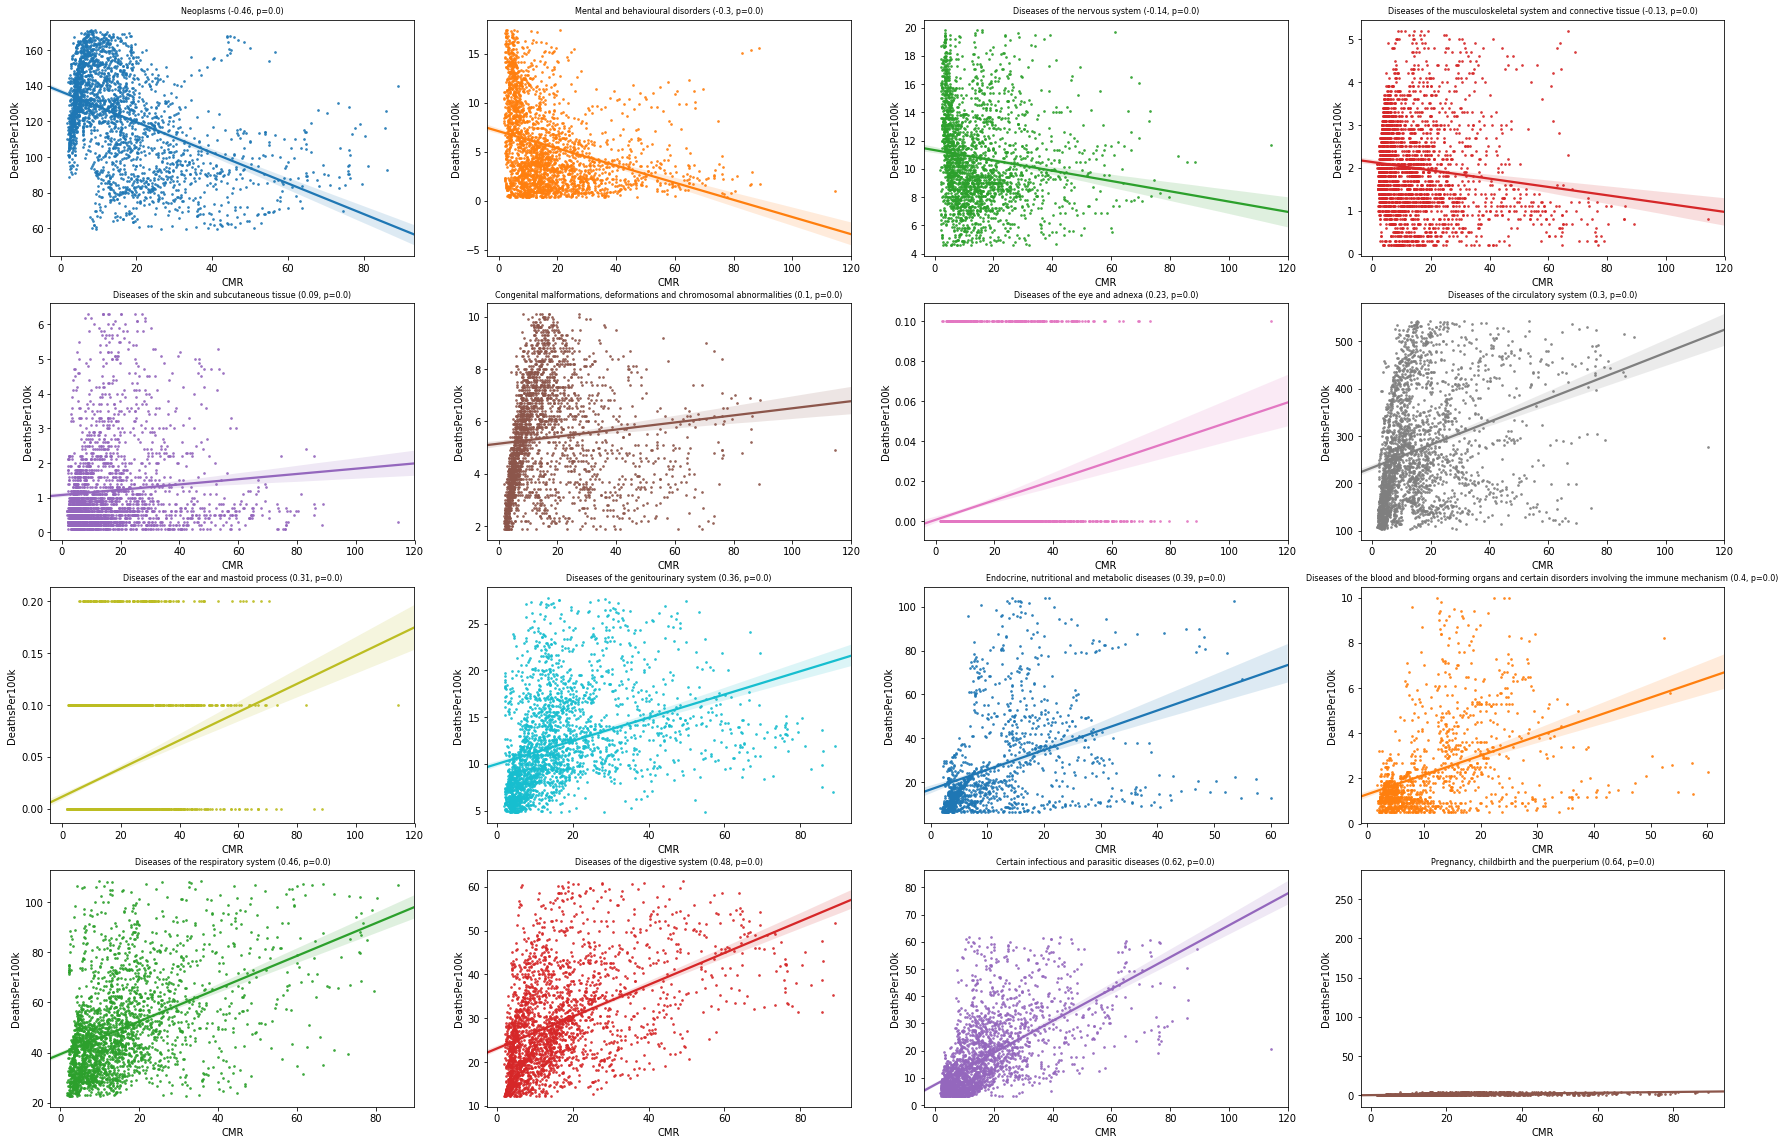

In [43]:
cmrMort2 = append_correl(remove_outliers(cmrMort).dropna(), "CMR", "DeathsPer100k")
display(cmrMort2)
plot4x4reg(cmrMort2, "CMR")

Same as BMI, correlation on a global scale has too much variance to be statistically significant. The cause with the highest correlation is related to childbirth, which makes sense as a high number of the deaths occurring due to childbirth can be classified as "child mortality".

Year  Cause                                      CauseName  \
0    1979      1      Certain infectious and parasitic diseases   
1    1980      1      Certain infectious and parasitic diseases   
2    1981      1      Certain infectious and parasitic diseases   
3    1982      1      Certain infectious and parasitic diseases   
4    1983      1      Certain infectious and parasitic diseases   
..    ...    ...                                            ...   
573  2012      4  Endocrine, nutritional and metabolic diseases   
574  2013      4  Endocrine, nutritional and metabolic diseases   
575  2014      4  Endocrine, nutritional and metabolic diseases   
576  2015      4  Endocrine, nutritional and metabolic diseases   
577  2016      4  Endocrine, nutritional and metabolic diseases   

     DeathsPer100k        CMR    Correl        pValue  
0        19.450000  21.749274  0.755045  4.318056e-08  
1        20.597619  25.321455  0.755045  4.318056e-08  
2        20.913208  27.414685  0.755045  4.318056e-08  
3        20.358491  27.987798  0.755045  4.318056e-08  
4        18.088372  20.594925  0.755045  4.318056e-08  
..             ...        ...       ...           ...  
573      27.324324   9.620851  0.325408  1.297328e-01  
574      26.827397   9.601338  0.325408  1.297328e-01  
575      26.581690   8.949516  0.325408  1.297328e-01  
576      23.637037   8.447201  0.325408  1.297328e-01  
577      16.120000   6.185677  0.325408  1.297328e-01  

[578 rows x 7 columns]

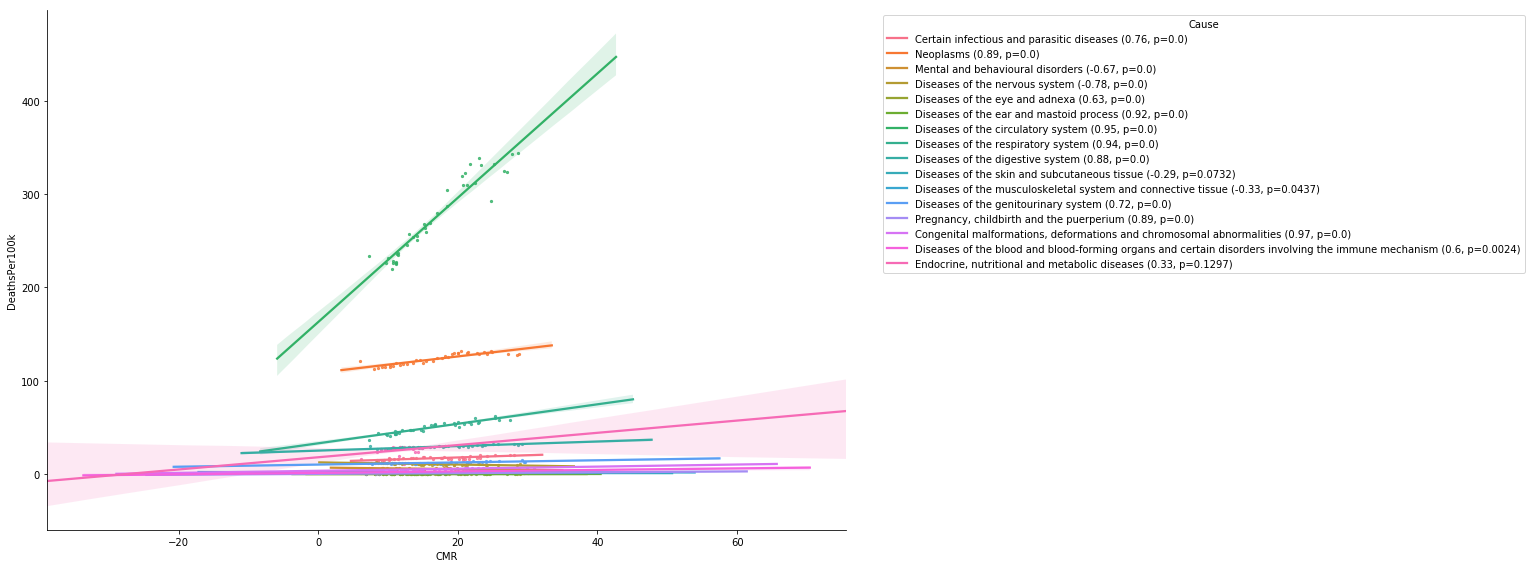

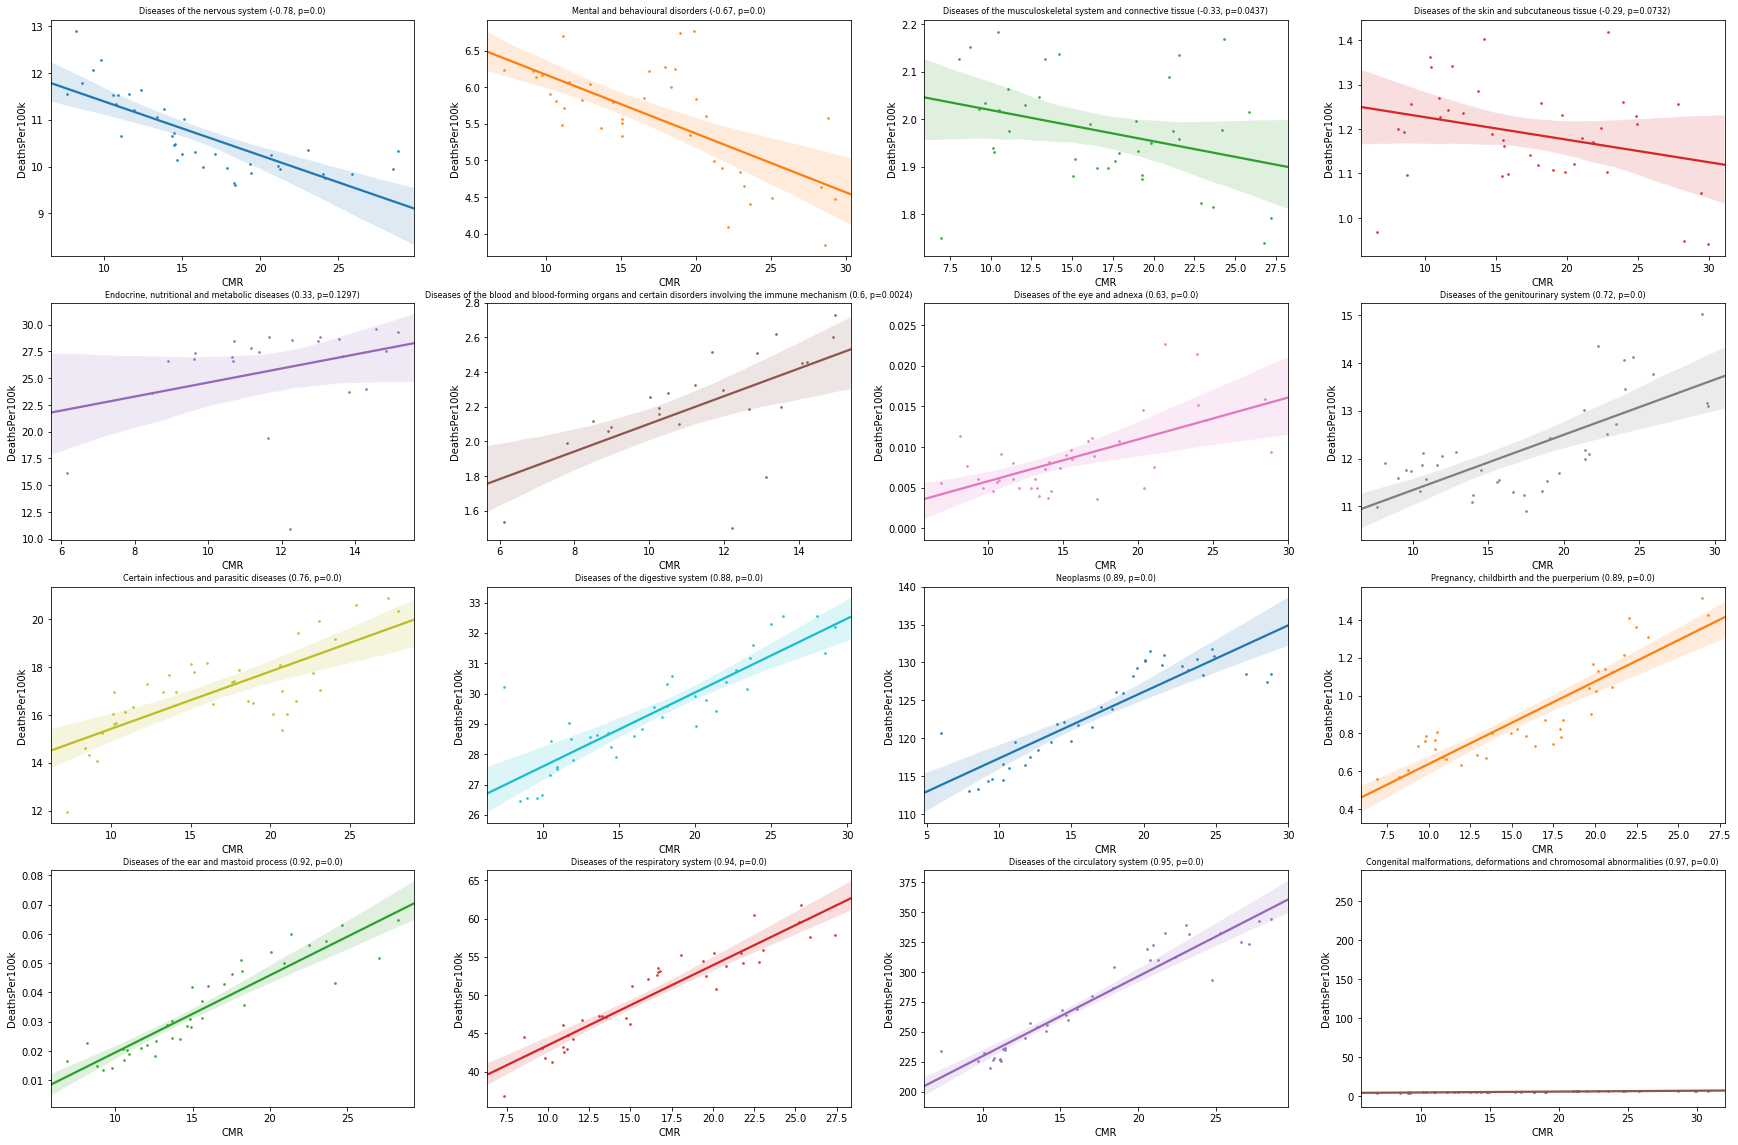

In [44]:
reg_mean_deaths(cmrMort2, "CMR")

The correlations are almost the exact opposite of that of BMI. Diseases of the nervous system and mental disorders are positively correlated with CMR, once again proving my hypothesis that many people with undiagnosed mental disorders are dying young, so they will not be tallied as a death due to those causes. 

Enter alpha-3 country code: usa
United States


CountryCode        Country Cause                           CauseName  \
189         USA  United States     9  Diseases of the circulatory system   
161         USA  United States     9  Diseases of the circulatory system   
168         USA  United States     9  Diseases of the circulatory system   
167         USA  United States     9  Diseases of the circulatory system   
166         USA  United States     9  Diseases of the circulatory system   
..          ...            ...   ...                                 ...   
103         USA  United States     5    Mental and behavioural disorders   
102         USA  United States     5    Mental and behavioural disorders   
101         USA  United States     5    Mental and behavioural disorders   
100         USA  United States     5    Mental and behavioural disorders   
78          USA  United States     5    Mental and behavioural disorders   

     Year  DeathsPer100k        CMR    Correl        pValue  
189  2016          131.8   5.764999  0.973829  9.290551e-25  
161  1988          266.8   9.929447  0.973829  9.290551e-25  
168  1995          226.7   7.929688  0.973829  9.290551e-25  
167  1994          228.8   8.191276  0.973829  9.290551e-25  
166  1993          235.2   8.480499  0.973829  9.290551e-25  
..    ...            ...        ...       ...           ...  
103  2006           14.7   6.666849 -0.840583  4.040001e-11  
102  2005           12.1   6.745975 -0.840583  4.040001e-11  
101  2004           10.9   6.816018 -0.840583  4.040001e-11  
100  2003           10.8   6.880536 -0.840583  4.040001e-11  
78   1981            5.2  12.102701 -0.840583  4.040001e-11  

[152 rows x 9 columns]

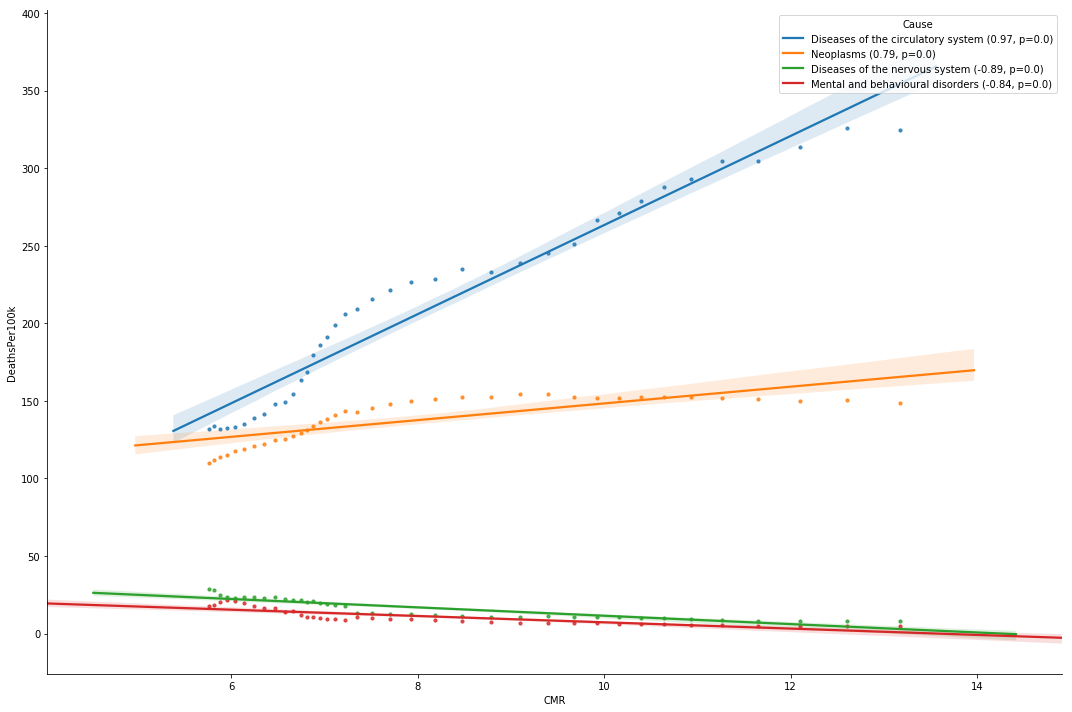

Enter alpha-3 country code: rus
Russian Federation


CountryCode             Country Cause                       CauseName  \
36         RUS  Russian Federation     2                       Neoplasms   
55         RUS  Russian Federation     2                       Neoplasms   
57         RUS  Russian Federation     2                       Neoplasms   
58         RUS  Russian Federation     2                       Neoplasms   
59         RUS  Russian Federation     2                       Neoplasms   
..         ...                 ...   ...                             ...   
75         RUS  Russian Federation     6  Diseases of the nervous system   
74         RUS  Russian Federation     6  Diseases of the nervous system   
73         RUS  Russian Federation     6  Diseases of the nervous system   
72         RUS  Russian Federation     6  Diseases of the nervous system   
77         RUS  Russian Federation     6  Diseases of the nervous system   

    Year  DeathsPer100k        CMR    Correl        pValue  
36  1980          144.1  23.160614  0.749570  1.434614e-07  
55  1999          152.5  17.145943  0.749570  1.434614e-07  
57  2001          148.2  15.699803  0.749570  1.434614e-07  
58  2002          146.6  14.787114  0.749570  1.434614e-07  
59  2003          145.0  13.800184  0.749570  1.434614e-07  
..   ...            ...        ...       ...           ...  
75  2002            9.3  14.787114 -0.527442  2.956826e-02  
74  2001            8.8  15.699803 -0.527442  2.956826e-02  
73  2000            8.4  16.499216 -0.527442  2.956826e-02  
72  1999            8.1  17.145943 -0.527442  2.956826e-02  
77  2004            9.7  12.811291 -0.527442  2.956826e-02  

[125 rows x 9 columns]

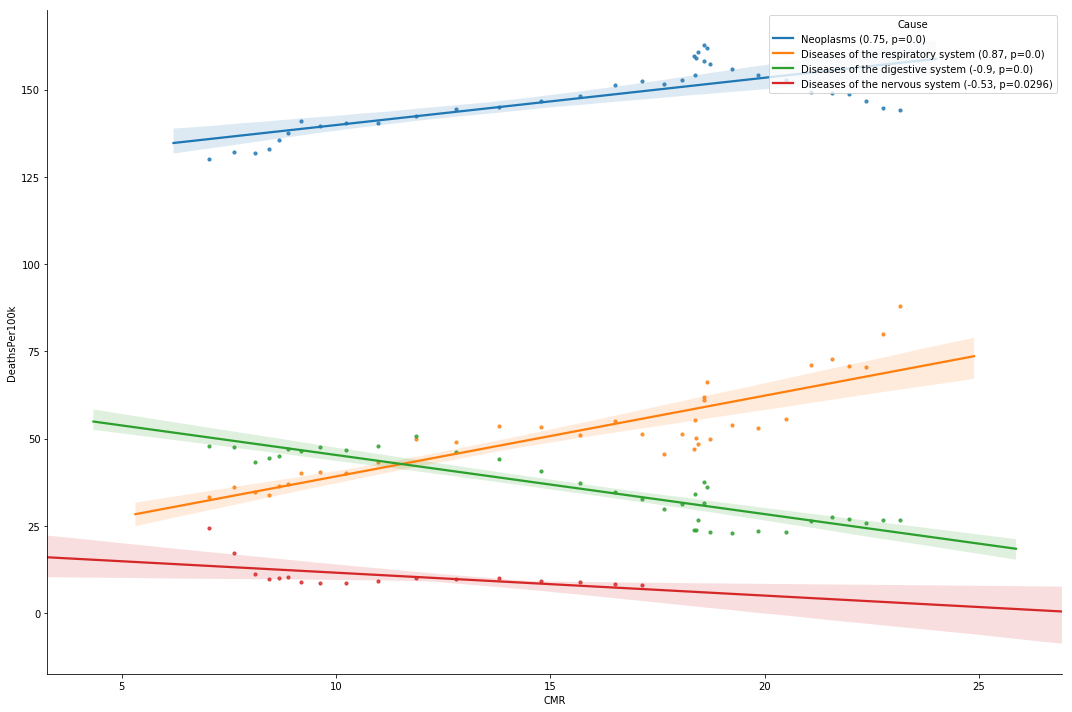

Enter alpha-3 country code: gbr
United Kingdom


CountryCode         Country Cause                           CauseName  \
112         GBR  United Kingdom     9  Diseases of the circulatory system   
138         GBR  United Kingdom     9  Diseases of the circulatory system   
131         GBR  United Kingdom     9  Diseases of the circulatory system   
132         GBR  United Kingdom     9  Diseases of the circulatory system   
133         GBR  United Kingdom     9  Diseases of the circulatory system   
..          ...             ...   ...                                 ...   
60          GBR  United Kingdom     5    Mental and behavioural disorders   
59          GBR  United Kingdom     5    Mental and behavioural disorders   
58          GBR  United Kingdom     5    Mental and behavioural disorders   
57          GBR  United Kingdom     5    Mental and behavioural disorders   
72          GBR  United Kingdom     5    Mental and behavioural disorders   

     Year  DeathsPer100k        CMR    Correl        pValue  
112  1980          361.3  12.068115  0.961258  3.592956e-21  
138  2006          146.5   5.037681  0.961258  3.592956e-21  
131  1999          205.2   5.659105  0.961258  3.592956e-21  
132  2000          191.3   5.569100  0.961258  3.592956e-21  
133  2001          191.5   5.483651  0.961258  3.592956e-21  
..    ...            ...        ...       ...           ...  
60   2002           13.0   5.401056 -0.704435  1.139751e-06  
59   2001           13.0   5.483651 -0.704435  1.139751e-06  
58   2000           10.6   5.569100 -0.704435  1.139751e-06  
57   1999           10.7   5.659105 -0.704435  1.139751e-06  
72   2014           23.4   3.892211 -0.704435  1.139751e-06  

[185 rows x 9 columns]

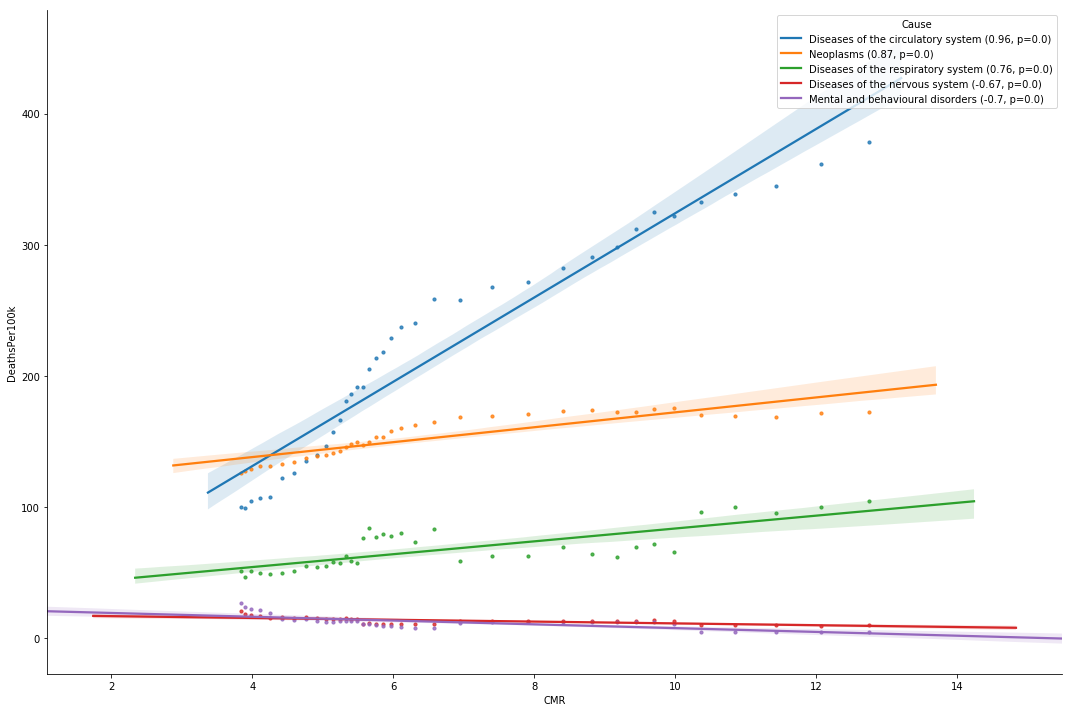

Enter alpha-3 country code: bra
Brazil


CountryCode Country Cause                                  CauseName  \
110         BRA  Brazil     9         Diseases of the circulatory system   
82          BRA  Brazil     9         Diseases of the circulatory system   
90          BRA  Brazil     9         Diseases of the circulatory system   
89          BRA  Brazil     9         Diseases of the circulatory system   
88          BRA  Brazil     9         Diseases of the circulatory system   
..          ...     ...   ...                                        ...   
24          BRA  Brazil     1  Certain infectious and parasitic diseases   
23          BRA  Brazil     1  Certain infectious and parasitic diseases   
22          BRA  Brazil     1  Certain infectious and parasitic diseases   
21          BRA  Brazil     1  Certain infectious and parasitic diseases   
0           BRA  Brazil     1  Certain infectious and parasitic diseases   

     Year  DeathsPer100k        CMR    Correl        pValue  
110  2015          167.5  14.046389  0.846563  4.071673e-11  
82   1987          237.9  58.420730  0.846563  4.071673e-11  
90   1995          285.7  40.903623  0.846563  4.071673e-11  
89   1994          292.0  43.342598  0.846563  4.071673e-11  
88   1993          299.4  45.764745  0.846563  4.071673e-11  
..    ...            ...        ...       ...           ...  
24   2003           31.5  25.023282  0.906555  1.137526e-14  
23   2002           31.1  26.703441  0.906555  1.137526e-14  
22   2001           31.7  28.459729  0.906555  1.137526e-14  
21   2000           32.0  30.300841  0.906555  1.137526e-14  
0    1979           62.6  79.486312  0.906555  1.137526e-14  

[111 rows x 9 columns]

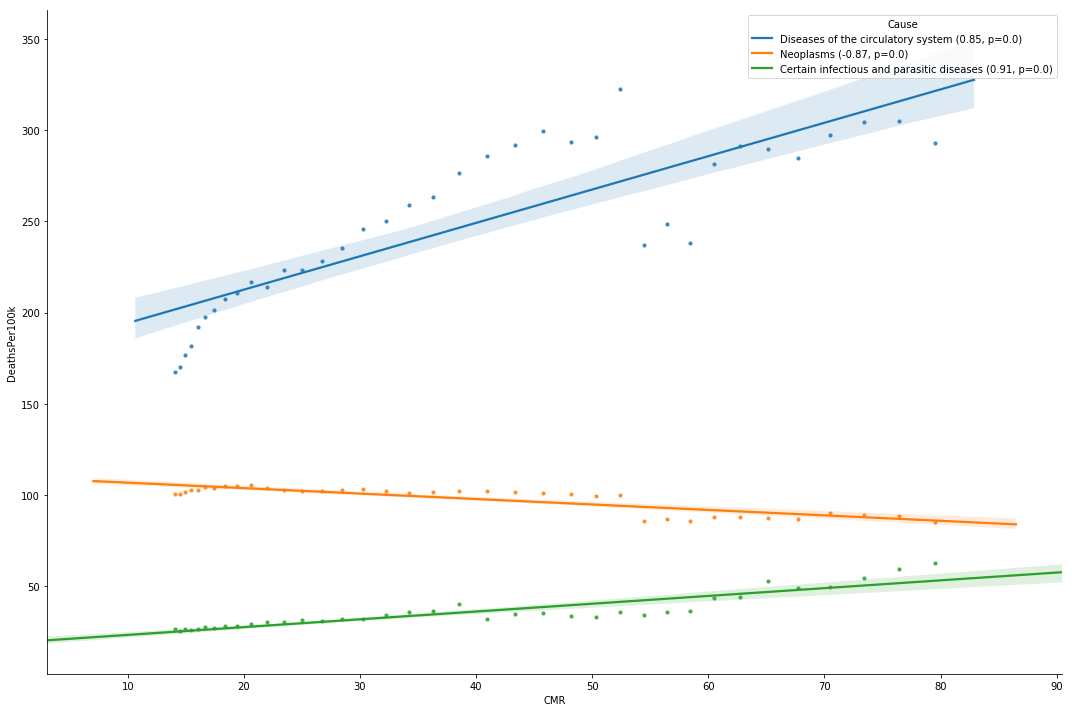

Enter alpha-3 country code: stop


In [45]:
reg_per_country(append_correl(cmrMort, "CMR", "DeathsPer100k").dropna(), "CMR")

Almost the reverse correlations as BMI. Once again, Russia is the anomaly here, with deaths due to digestive diseases correlating negatively with CMR. I cannot explain this with a direct reason. Perhaps it is due to the same reason as BMI, where as Russia gets more developed, its citizens eat unhealthily enough to develop digestive disorders.

### 4. Using an index consisting of BMI and CMR, is it possible to predict the trend of some major causes of death globally?
<a id='index'/>

#### Result
<a id='result4'>

The only cause of death that could be predicted to some extent from these two statistics is illnesses of the circulatory system. The model that has been created works best when the country is in the transition phase between developing and developed.

#### EDA
<a id='eda4'>

We will use the data for every developed country (HDI > 0.9) as over the course of 38 years, most of them have went through several stages of development and can be used as a predictor for the rest of the world in the future. This would be free from the variance (perhaps due to war and instabilities) that's present in developing countries. Feel free to adjust the HDI threshold to something other than 0.9, but from my experience doing so, the resulting model is really all over the place. The scatterplots look to be randomly generated in that case. **The failed graphs have been omitted for the sake of saliency.**

I will not be taking the mean of all countries throughout the years as that produces too few data points and is prone to overfitting.

In [46]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

altogether = pd.merge(
    bmiMort2.drop(['Correl', 'pValue'], axis=1),
    cmrMort2[["CountryCode", "Cause", "Year", "CMR"]],
    on=["CountryCode", "Cause", "Year"],
)

# to show that there is an hdi value for every country code in altogether
# notice number of rows is the same
display(len(altogether))
altogether = pd.merge(altogether, hdidf, on=["CountryCode", "Country"], how="left")
display(len(altogether))

# feel free to uncomment these lines for mean deaths per year,
# but there are too few data points, leading to underfitting
# when it comes to a country by country basis.

# it will not be plotted for the sake of saliency.

# for_mlm = pd.concat([get_mean_deaths(altogether,'BMI'),
#                      get_mean_deaths(altogether,'CMR')['CMR']],
#                     axis=1)
for_mlm = altogether[altogether.HDI > 0.9]
for_mlm

37836

37836

CountryCode        Country  Cause  \
1             AUS      Australia      1   
3             BEL        Belgium      1   
8             IRL        Ireland      1   
9             ISR         Israel      1   
11            JPN          Japan      1   
...           ...            ...    ...   
37822         AUT        Austria      4   
37827         ISL        Iceland      4   
37829         NLD    Netherlands      4   
37833         SWE         Sweden      4   
37835         USA  United States      4   

                                           CauseName  Year  DeathsPer100k  \
1          Certain infectious and parasitic diseases  1979            3.4   
3          Certain infectious and parasitic diseases  1979            5.4   
8          Certain infectious and parasitic diseases  1979            8.4   
9          Certain infectious and parasitic diseases  1979           12.1   
11         Certain infectious and parasitic diseases  1979           10.4   
...                                              ...   ...            ...   
37822  Endocrine, nutritional and metabolic diseases  2016           19.3   
37827  Endocrine, nutritional and metabolic diseases  2016            8.2   
37829  Endocrine, nutritional and metabolic diseases  2016            9.4   
37833  Endocrine, nutritional and metabolic diseases  2016           10.5   
37835  Endocrine, nutritional and metabolic diseases  2016           21.5   

        BMI        CMR       HDI  
1      24.2  11.297138  0.938379  
3      24.9  12.876635  0.918841  
8      24.0  13.043885  0.942473  
9      24.6  16.275730  0.906235  
11     22.2   7.832282  0.914696  
...     ...        ...       ...  
37822  25.6   2.993266  0.913809  
37827  26.2   1.707952  0.938474  
37829  25.6   3.428635  0.933495  
37833  26.0   2.287122  0.936628  
37835  28.9   5.764999  0.919926  

[9884 rows x 9 columns]

With the combined dataset manufactured, we can now proceed to create a multiple linear regression model using BMI and CMR to predict any cause of death we so choose. This data is free from outliers. `distplot`s will be used to determine roughly how good a model they are.

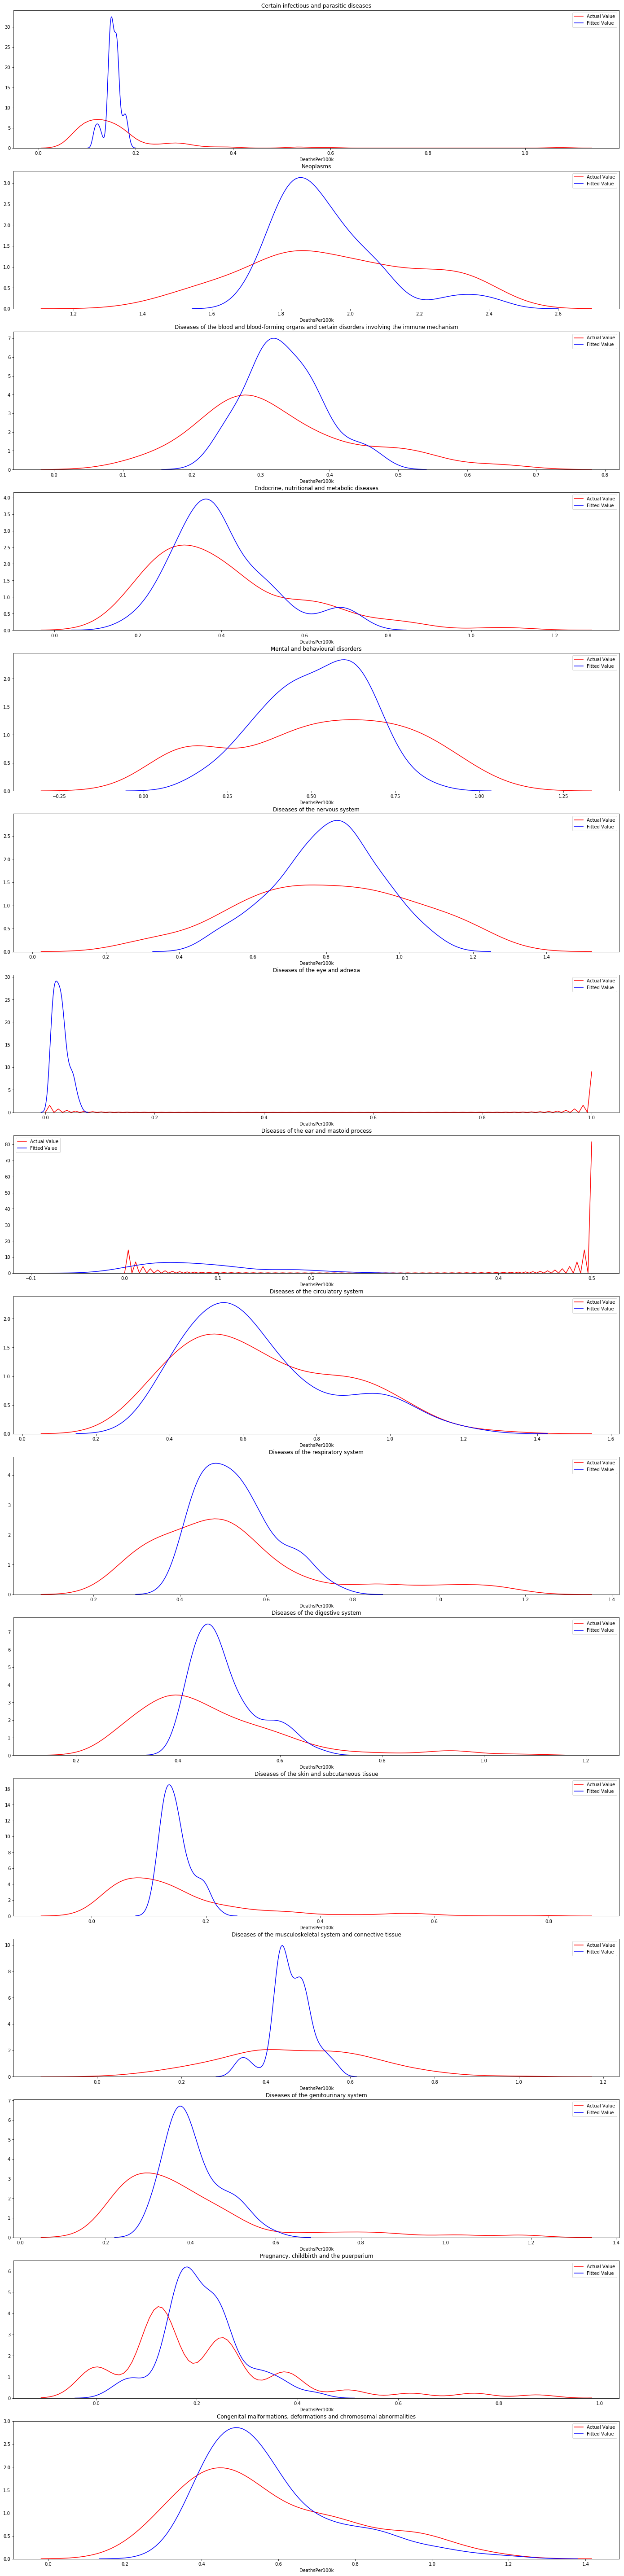

In [47]:
def build_model(cause):
    mlm = LinearRegression()
    by_cause = for_mlm.query("Cause==@cause")
    # normalize
    by_cause.DeathsPer100k /= (
        by_cause.DeathsPer100k.max() - by_cause.DeathsPer100k.min()
    )
    x_train, x_test, y_train, y_test = train_test_split(
        by_cause[["CMR", "BMI"]],
        by_cause["DeathsPer100k"],
        test_size=0.2,
        random_state=10,
    )
    mlm.fit(x_train, y_train)
    return (mlm.intercept_, mlm.coef_, mlm.predict(x_test), y_test)


fig, axes = plt.subplots(len(disease_codes), 1, figsize=(20, 80))
fig.tight_layout(pad=3.0)
models = []
for cause in range(1, len(disease_codes) + 1):
    model = build_model(cause)
    name = disease_codes.loc[cause, "name"]
    models.append([name, mean_squared_error(model[3], model[2]), model])
    ax1 = sns.distplot(
        model[3], hist=False, color="r", label="Actual Value", ax=axes[cause - 1]
    )
    axes[cause - 1].set_title(name)
    sns.distplot(model[2], hist=False, color="b", label="Fitted Value", ax=ax1)

The model is really bad at predictions for most causes of death, so let's narrow it down a bit.

Now, let's take the top five models ranked by mean-squared-error and see how they fare using some bar plots.

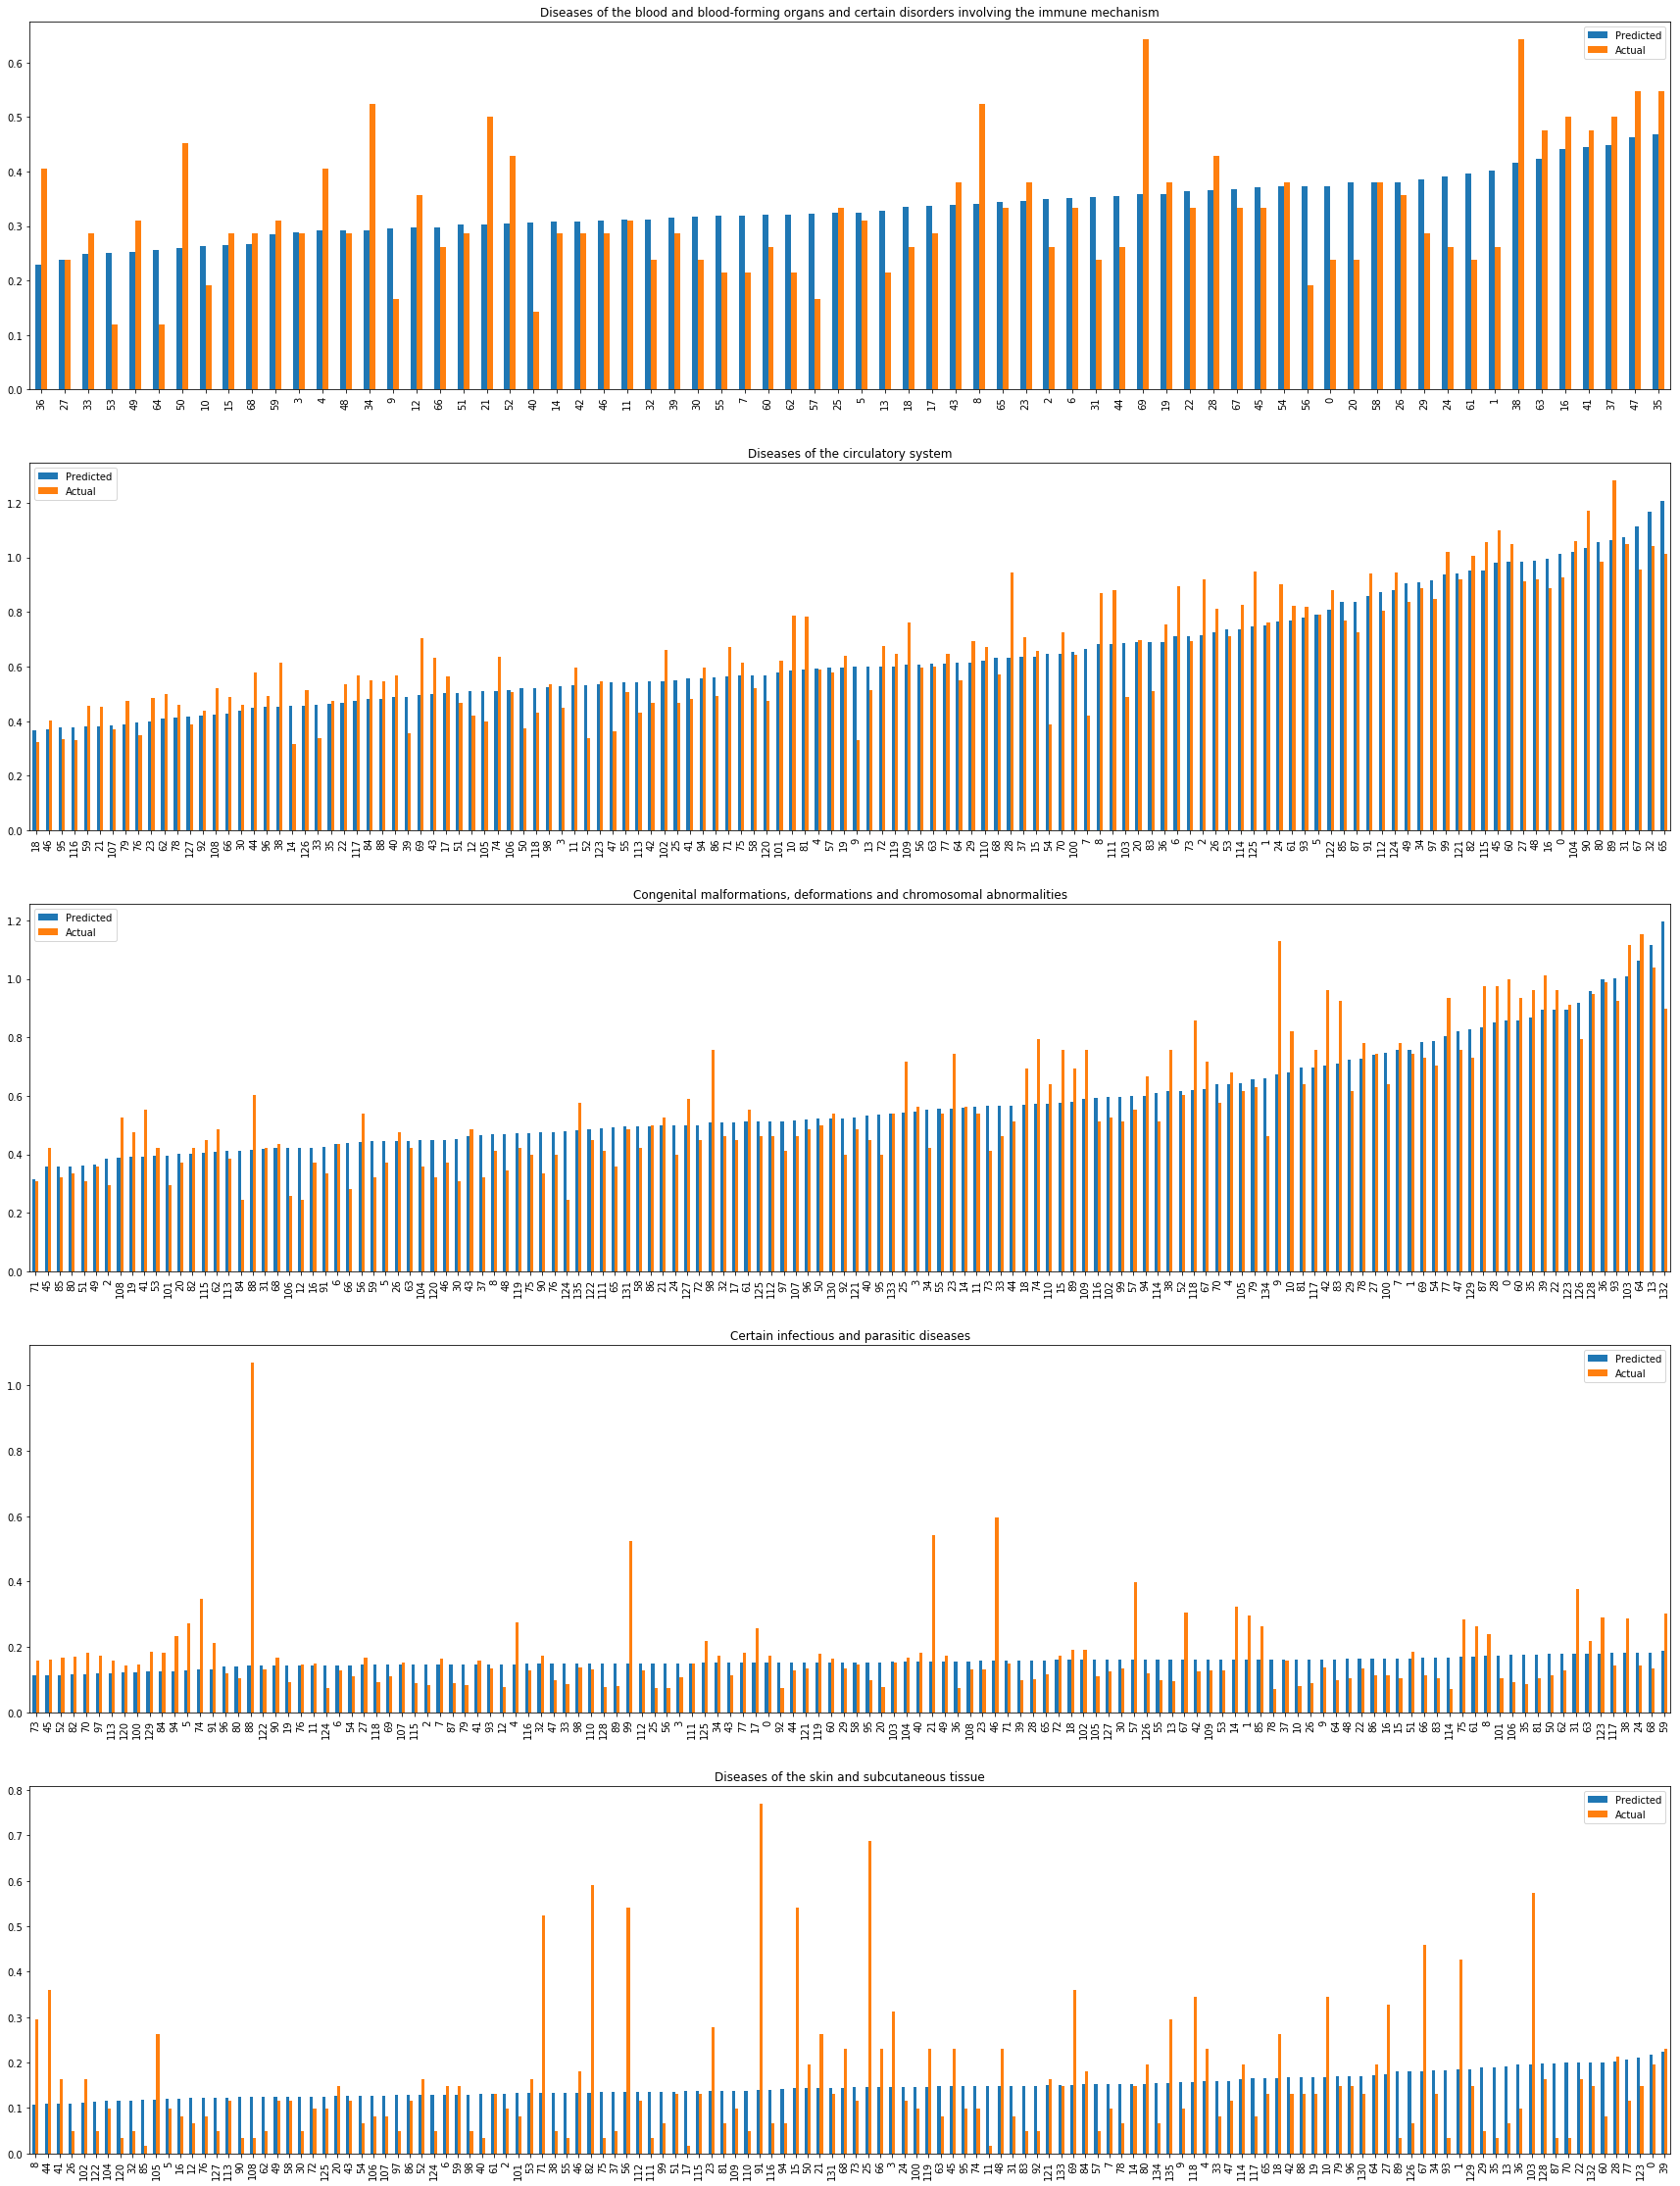

In [48]:
models.sort(key=lambda x: x[1])
fig, axes = plt.subplots(5, figsize=(30, 40))
for x in range(5):
    name = models[x][0]
    mse = models[x][1]
    actual_vs_predicted = pd.DataFrame([models[x][2][2], models[x][2][3]]).T
    axes[x].set_title(name)
    actual_vs_predicted.columns = ["Predicted", "Actual"]
    actual_vs_predicted.sort_values(by="Predicted", inplace=True)
    actual_vs_predicted.plot(kind="bar", ax=axes[x])

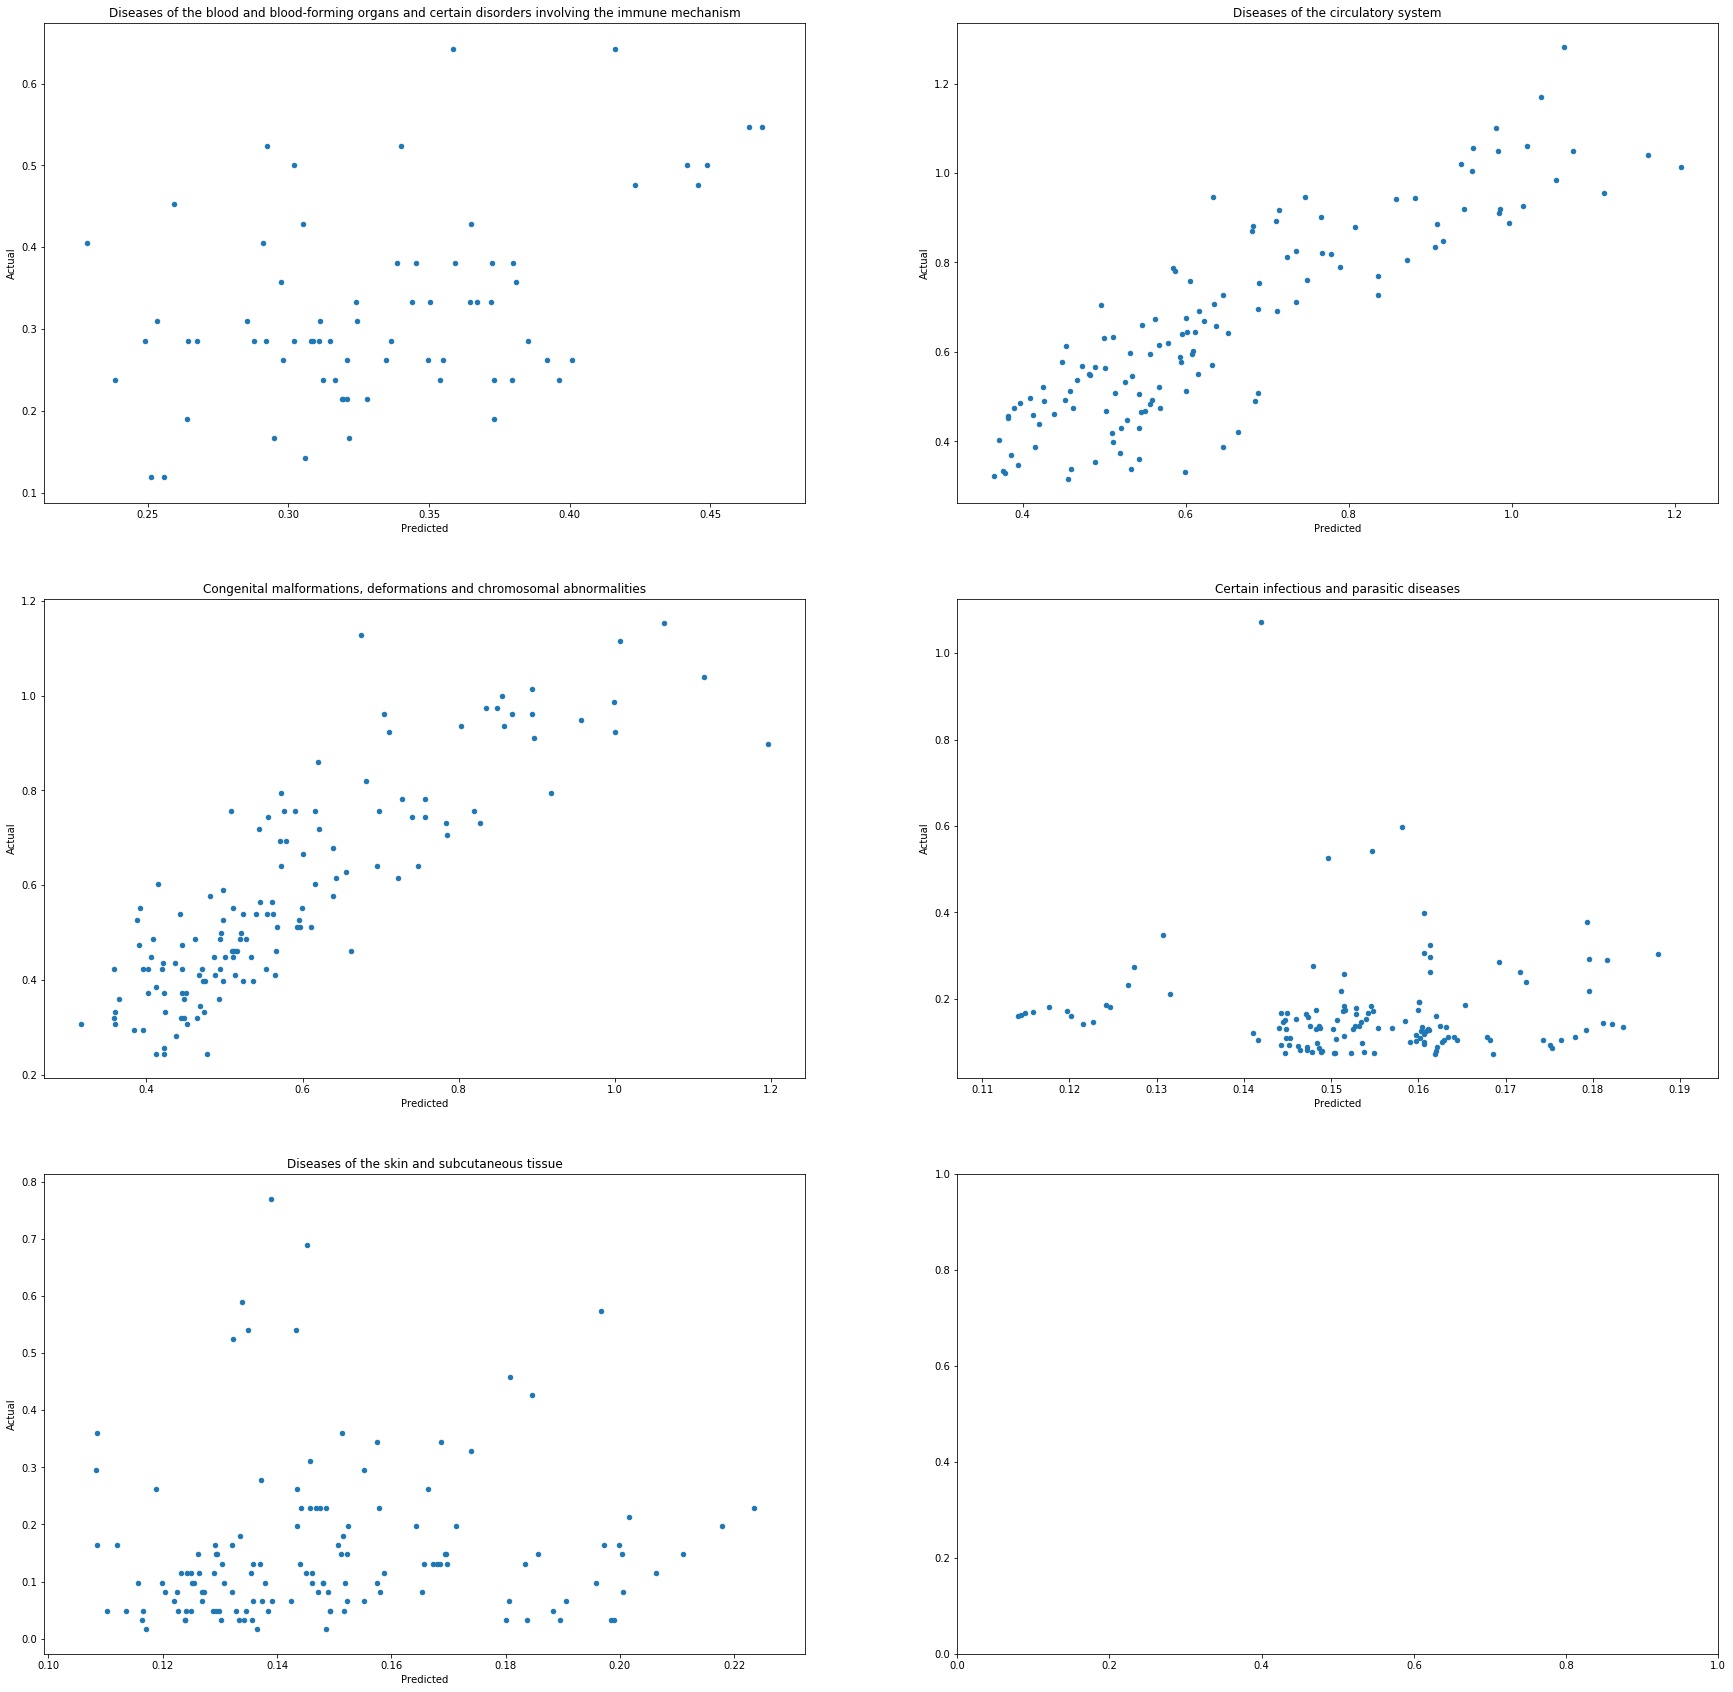

In [49]:
fig, axes = plt.subplots(3,2, figsize=(30, 30))
for x in range(5):
    name = models[x][0]
    mse = models[x][1]
    actual_vs_predicted = pd.DataFrame([models[x][2][2], models[x][2][3]]).T
    axes.ravel()[x].set_title(name)
    actual_vs_predicted.columns = ["Predicted", "Actual"]
    actual_vs_predicted.sort_values(by="Predicted", inplace=True)
    actual_vs_predicted.plot(kind="scatter", x='Predicted', y='Actual',ax=axes.ravel()[x])

The model for eye disease is clearly inaccurate. Diseases relating to blood has too few data points and is also too inaccurate. The only reason the model for infectious and parasitic diseases has low MSE is because few people die from infectious diseases in developed countries. That is clearly not a good model either.

Congenital malformations is directly correlated with CMR for obvious reasons, so it is not interesting. The only one left that is somewhat interesting is diseases of the circulatory system. Let's do some more analysis on that.

In [56]:
display(models[1])

['Diseases of the circulatory system',
 0.011696943094955246,
 (1.421149927364537,
  array([ 0.0619449 , -0.04554524]),
  array([1.01320986, 0.74883747, 0.71504685, 0.52851325, 0.59328728,
         0.78878355, 0.71049832, 0.66388696, 0.68076065, 0.59946076,
         0.58458243, 0.53137165, 0.50984966, 0.59984361, 0.45521879,
         0.63731264, 0.99656758, 0.50145469, 0.36518774, 0.59535215,
         0.6892643 , 0.38257759, 0.46675064, 0.39716693, 0.76639589,
         0.54975132, 0.72451511, 0.98416472, 0.63293239, 0.61571063,
         0.43835319, 1.07483376, 1.16698075, 0.45889425, 0.90853117,
         0.46189851, 0.6896345 , 0.63469345, 0.452749  , 0.48883828,
         0.48839824, 0.55566443, 0.54482413, 0.50024218, 0.4487615 ,
         0.98037096, 0.37088313, 0.54263672, 0.98603895, 0.90565033,
         0.51940608, 0.5016939 , 0.53308642, 0.73497007, 0.64549464,
         0.54291838, 0.60819444, 0.59464419, 0.56736086, 0.38143639,
         0.98329414, 0.76771394, 0.40955491, 0.60933

In [57]:
model_data = models[1][2]
by_cause = for_mlm.query("Cause==9")
scale_factor = by_cause.DeathsPer100k.max() - by_cause.DeathsPer100k.min()
values = np.array([model_data[0], model_data[1][0], model_data[1][1]])
values *= scale_factor


def predict_point(row):
#     display(row)
    bmi, cmr = row.BMI, row.CMR
    return values[0] + values[1]*cmr + values[2]*bmi


print(
    "Equation for Number of Deaths/100k: y = "
    + str(values[0])
    + " + "
    + str(values[1])
    + "a + "
    + str(values[2])
    + "b"
)

Equation for Number of Deaths/100k: y = 470.11639597218885 + 20.491371274424246a + -15.06636638748741b


Where a is CMR and b is BMI.

Let's try to use this model to predict a country's diseases of the circulatory system deaths per 100k as time progresses.

In [58]:
mses = []
for country in altogether.CountryCode.unique():
    df = altogether[(altogether.CountryCode==country)&(altogether.Cause==cause)]
    df['Predicted'] = df.apply(predict_point,axis=1)
    mses.append([country, mean_squared_error(df.Predicted, df.DeathsPer100k)])
mses.sort(key=lambda x: x[1])
mses = pd.DataFrame(mses,columns=['CountryCode', 'MSE'])
with pd.option_context("display.max_rows", None):
    display(mses)

CountryCode           MSE
0           CYP  1.740372e+04
1           FIN  2.467333e+04
2           SWE  2.729342e+04
3           DEU  2.878023e+04
4           ISL  3.010467e+04
5           NOR  3.071257e+04
6           DNK  3.125044e+04
7           CHE  3.222937e+04
8           ARE  4.197307e+04
9           ESP  4.220781e+04
10          CZE  4.233626e+04
11          SVN  4.391609e+04
12          QAT  4.451897e+04
13          CAN  4.511242e+04
14          JPN  4.540004e+04
15          NLD  4.588934e+04
16          AUS  4.704992e+04
17          LTU  4.772449e+04
18          IRL  4.817643e+04
19          FRA  4.857642e+04
20          GBR  5.116260e+04
21          BEL  5.140509e+04
22          GRC  5.147513e+04
23          AUT  5.398440e+04
24          MLT  5.416723e+04
25          SGP  5.439634e+04
26          USA  5.453492e+04
27          LUX  5.648239e+04
28          ITA  5.659736e+04
29          BRN  5.840215e+04
30          SVK  5.859178e+04
31          NZL  5.889963e+04
32          ISR  5.894437e+04
33          SRB  6.215356e+04
34          HRV  6.223903e+04
35          HUN  6.747743e+04
36          LVA  6.976550e+04
37          EST  7.228053e+04
38          OMN  7.775096e+04
39          POL  8.231107e+04
40          BLR  8.290434e+04
41          KWT  8.311700e+04
42          CUB  9.113505e+04
43          BHR  9.181189e+04
44          MNE  9.210937e+04
45          PRT  9.363588e+04
46          ATG  9.506889e+04
47          TUR  1.102212e+05
48          KOR  1.122351e+05
49          CHL  1.193670e+05
50          UKR  1.199796e+05
51          CRI  1.216161e+05
52          BGR  1.345717e+05
53          GRD  1.491319e+05
54          MDV  1.535097e+05
55          BRB  1.627330e+05
56          RUS  1.688311e+05
57          BHS  1.725713e+05
58          LCA  1.762677e+05
59          NIC  1.886207e+05
60          ROU  1.898958e+05
61          MKD  1.920069e+05
62          MDA  1.931759e+05
63          URY  1.955611e+05
64          SYC  1.966674e+05
65          BIH  1.989081e+05
66          FJI  2.162581e+05
67          THA  2.248597e+05
68          MUS  2.316944e+05
69          VCT  2.626821e+05
70          ARG  2.774602e+05
71          CPV  2.858328e+05
72          JAM  2.984975e+05
73          VEN  2.992691e+05
74          BLZ  3.216909e+05
75          COL  3.278327e+05
76          PAN  3.355367e+05
77          LKA  3.763193e+05
78          TTO  3.968606e+05
79          ALB  4.077687e+05
80          SUR  4.954395e+05
81          PHL  5.312201e+05
82          MEX  5.390589e+05
83          SLV  5.687712e+05
84          GEO  5.991424e+05
85          PRY  6.142993e+05
86          KAZ  6.987230e+05
87          ARM  7.165464e+05
88          ECU  7.326683e+05
89          ZAF  7.575296e+05
90          GUY  7.808774e+05
91          EGY  8.708117e+05
92          BRA  1.010236e+06
93          KGZ  1.084460e+06
94          MNG  1.165316e+06
95          GTM  1.277447e+06
96          UZB  1.665627e+06
97          KIR  1.728419e+06
98          TKM  1.811960e+06
99          STP  2.143979e+06
100         AZE  2.327631e+06

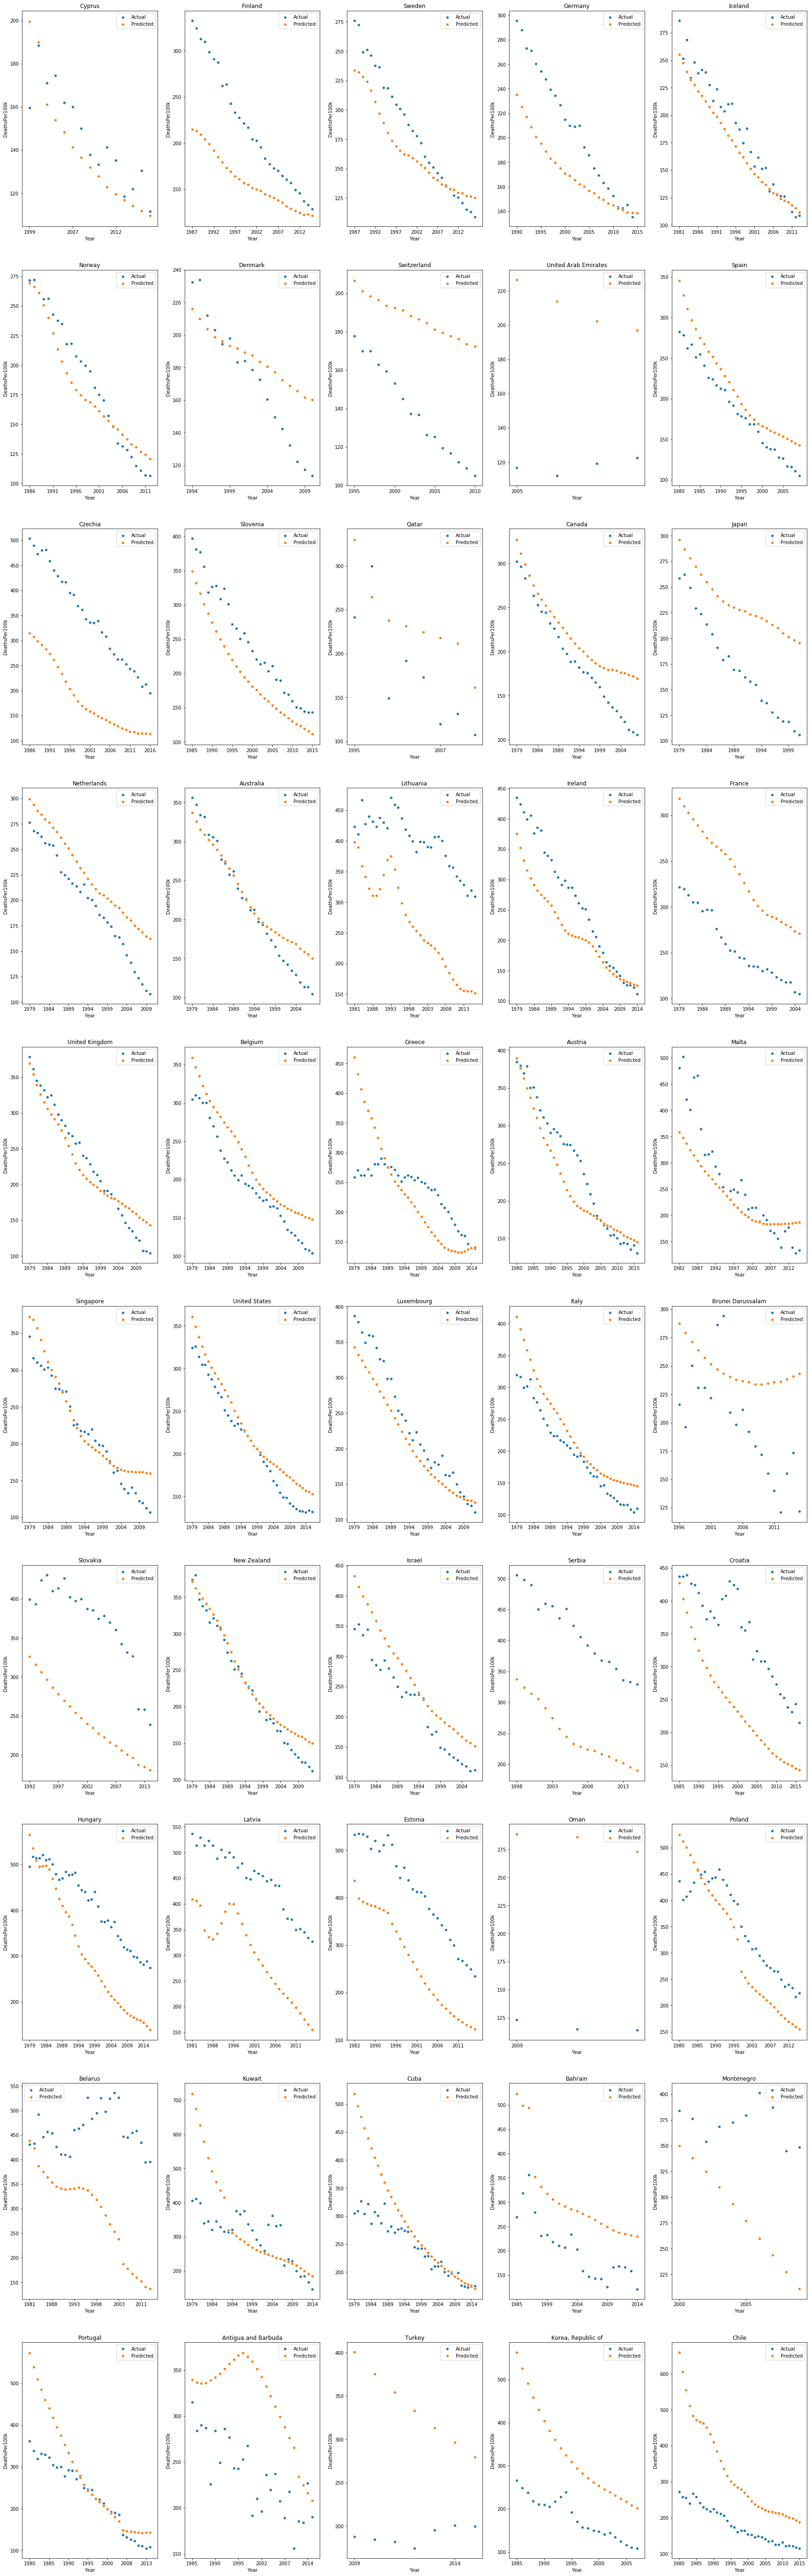

In [59]:
fig, axes = plt.subplots(10,5,figsize=(30,100))
def predict_countries(countries, cause):
    for x in range(len(countries)):
        country = countries[x]
        ax = axes.ravel()[x]
        df = altogether[(altogether.CountryCode==country)&(altogether.Cause==cause)]
        df['Predicted'] = df.apply(predict_point,axis=1)
        sns.scatterplot(data=df, x='Year', y='DeathsPer100k',ax=ax)
        sns.scatterplot(data=df, x='Year', y='Predicted',ax=ax)
        ax.set_xticks(ax.get_xticks()[::5])
        ax.set_title(df.iloc[0]['Country'])
        ax.set_ylabel('DeathsPer100k')
        ax.legend(['Actual','Predicted'])
predict_countries(mses.loc[:49,'CountryCode'],9)

Nice! This model appears to work for most developed and in-transition countries. A few countries look to be off by a simple translation parallel to the y-axis. This may be perhaps due to a genetic predisposition to die less from heart-related disorders or some other external factor. Countries can calibrate this model for their own usage with a few years of mortality, CMR and BMI data.

I will now show you in detail some curated graphs that display this model's effectiveness.

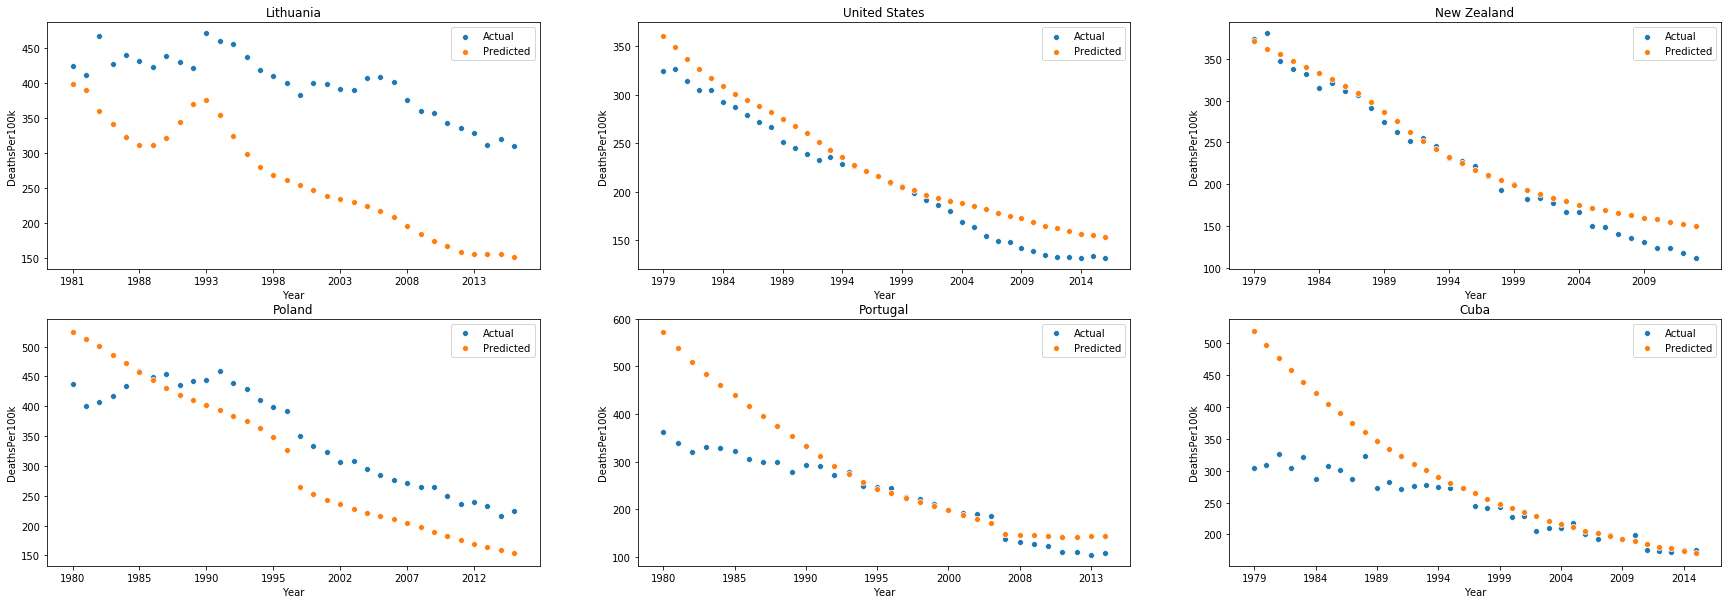

In [60]:
curated = ['LTU','USA','NZL','POL','PRT','CUB']
fig, axes = plt.subplots(2,3,figsize=(30,10))
predict_countries(curated,9)

Lithuania: The prediction is off by a simple translation, but I would like to draw attention to around the 1993 mark. When the actual figures unexpectedly (at least against the year) increased, the predicted values also increased. This shows that something happened in Lithuania that year which shifted deaths due to cardiovascular causes and BMI or CMR.

Poland: Same as Lithuania but at the 1996 mark. I wonder if it's due to the Soviet Union disintegrating.

United States: Pretty good prediction for one of the world's most important countries, starts deviating a bit towards the end, perhaps as the country reaches stages of late-development.

New Zealand: This model in general works well for developed countries, which is expected as the model is based off their data. The other option (use all data) would have way too much variability due to developing countries, and is much worse than this.

Cuba: As Cuba transitions towards being less of a developing country and in general becoming more stable, the actual figures become more in line with the predicted ones.

Portugal: Same as Cuba. This model is quite effective during the transition stage between developing and developed.

In [55]:
def predict_country(cause):
    country = ""
    while country != "STOP":
        country = input("Enter alpha-3 country code: ").upper()
        if country in altogether.CountryCode.values:
            df = altogether[(altogether.CountryCode==country)&(altogether.Cause==cause)]
            df['Predicted'] = df.apply(predict_point,axis=1)
            display(df)
            plt.figure(figsize=(20,10))
            ax = sns.scatterplot(data=df, x='Year', y='DeathsPer100k')
            sns.scatterplot(data=df, x='Year', y='Predicted',ax=ax)
            ax.set_title(df.iloc[0]['Country'])
            ax.set_ylabel('DeathsPer100k')
            ax.legend(['Actual','Predicted'])
            plt.show()
# uncomment this to choose any country you want to be displayed
# predict_country(9)

## Conclusion and Recommendations
<a id='conclusion'/>

Countries with exceptionally low rates of death due to mental disorders should monitor the mental health of children more closely, and diagnose mental disorders early on. This would ensure that appropriate care is given to them but the truth is that in the end many of them will die later on life nonetheless due to their condition. Therefore, when a country's rate of death due to mental disorders is high, it means that it has succeeded in given it's disabled children a few extra years of life.

Countries can use their leading cause of death to judge their current state of development. If it is infectious diseases, then they are far behind the rest of the world and should work on sanitation. If it is illnesses of the circulatory system, then they are average and should implement measures such as advocating for a healthy lifestyle. If it is neoplasms, then they are very developed and there is not much they can do about it unless cancer can be cured. 

Countries in the transition phase of their development can use the model in question 4 to roughly determine the number of deaths due to illnesses of the circulatory system. They can then compare the predicted value with the actual value to see if they have a disproportionately high or low number of deaths due to that cause at their current stage of development. If it is overly high, then the country should work on equipping its public spaces with facilities necessary (e.g. AEDs) to prevent deaths due to heart disease from occurring.

Russia should really advocate for a healthier diet among its citizens.